In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
# sidm_path = str(sys.path[0]).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, cutflow
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting

import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from tqdm.notebook import tqdm
import coffea.util
import numpy as np

In [2]:
client = scaleout.make_dask_client("tls://localhost:8786")
client

<Client: 'tls://192.168.235.27:8786' processes=0 threads=0, memory=0 B>

In [3]:
samples = [
    "2Mu2E_200GeV_5p0GeV_0p2mm",
    "2Mu2E_200GeV_5p0GeV_200p0mm",
    "2Mu2E_1000GeV_0p25GeV_0p002mm",
    "2Mu2E_1000GeV_0p25GeV_2p0mm",
]

In [4]:
fileset = utilities.make_fileset(samples[0:4], 
                                 "llpNanoAOD_v2", 
                                 location_cfg="signal_2mu2e_v10.yaml",
                                 max_files = -1,
                                )

In [5]:
runner = processor.Runner(
    executor=processor.DaskExecutor(client=client),
    # executor=processor.IterativeExecutor(),
    # executor=processor.FuturesExecutor(), 
    schema=NanoAODSchema,
#    maxchunks=10, 
    skipbadfiles=True
)

channels = [
    "baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p02_muon_charge",
    "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"
]

p = sidm_processor.SidmProcessor(
    channels,
    ["muon_base", "muon_crosscleaning_base", "dsaMuon_base", "genMu_base", "mu_lj_base", "genA_ratio", "lepton_genLepton_genA_base"],
    lj_reco_choices=["0.4"],
    unweighted_hist=True,
)

import coffea.util as coffea_util
coffea_util.save(p, "processor.coffea")
print(coffea_util.load("processor.coffea"))
with performance_report(filename="dask-report.html"):
    output = runner.run(fileset, treename="Events", processor_instance=p)
out = output["out"]

Signal not in xs cfg, assuming 1fb#######] | 100% Completed | 16min 58.0s
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb


In [9]:
def print_summary(out, label_map, key_levels, quantity_keys):
    for quantity_label in ["Muons", "LJs"]:
        print("\n" + "="*10 + f" {quantity_label} Summary " + "="*10)
        for level_label, counter_key in key_levels:
            print(f"\n{level_label}")
            for label, path in label_map.items():
                values = out
                try:
                    for key in path:
                        values = values[key]
                    data = values[counter_key]
                    print(f"{label:<30} ->", end=" ")
                    for q in quantity_keys[quantity_label]:
                        print(f"{q}: {data[q]}", end=", ")
                    print("")
                except KeyError:
                    print(f"{label:<30} -> Data not found")
                    
# Define label map
label_map = {
    "2Mu2E_200GeV_5p0GeV_0p2mm":     ["2Mu2E_200GeV_5p0GeV_0p2mm", "counters", "0.4"],
    "2Mu2E_200GeV_5p0GeV_200p0mm":   ["2Mu2E_200GeV_5p0GeV_200p0mm", "counters", "0.4"],
    "2Mu2E_1000GeV_0p25GeV_0p002mm": ["2Mu2E_1000GeV_0p25GeV_0p002mm", "counters", "0.4"],
    "2Mu2E_1000GeV_0p25GeV_2p0mm":   ["2Mu2E_1000GeV_0p25GeV_2p0mm", "counters", "0.4"],
}

# Define the list of levels and keys
key_levels = [
    ("Basic", "baseNoLj_basic"),
    ("Only DP matching Applied", "baseNoLj_DP_matching"),
    ("dR(DSA, PF) > 0.02 and DP matching Applied", "baseNoLj_DP_matching_dR0p02"),
    ("dR(DSA, PF) > 0.02, DP matching, and Muon charge == 0 Applied", "baseNoLj_DP_matching_dR0p02_muon_charge")
]

# Define which keys to extract under each category
quantity_keys = {
    "Muons": ["PF Muons", "DSA Muons"],
    "LJs": ["PF LJs", "DSA LJs"],
}

# Call the function
print_summary(out, label_map, key_levels, quantity_keys)


========== Muons Summary ==========

Basic
2Mu2E_200GeV_5p0GeV_0p2mm      -> PF Muons: 45903, DSA Muons: 39433, 
2Mu2E_200GeV_5p0GeV_200p0mm    -> PF Muons: 5937, DSA Muons: 16340, 
2Mu2E_1000GeV_0p25GeV_0p002mm  -> PF Muons: 121882, DSA Muons: 95226, 
2Mu2E_1000GeV_0p25GeV_2p0mm    -> PF Muons: 4916, DSA Muons: 7054, 

Only DP matching Applied
2Mu2E_200GeV_5p0GeV_0p2mm      -> PF Muons: 45225, DSA Muons: 39199, 
2Mu2E_200GeV_5p0GeV_200p0mm    -> PF Muons: 5612, DSA Muons: 16234, 
2Mu2E_1000GeV_0p25GeV_0p002mm  -> PF Muons: 118523, DSA Muons: 93481, 
2Mu2E_1000GeV_0p25GeV_2p0mm    -> PF Muons: 4490, DSA Muons: 6788, 

dR(DSA, PF) > 0.02 and DP matching Applied
2Mu2E_200GeV_5p0GeV_0p2mm      -> PF Muons: 45225, DSA Muons: 16359, 
2Mu2E_200GeV_5p0GeV_200p0mm    -> PF Muons: 5612, DSA Muons: 13947, 
2Mu2E_1000GeV_0p25GeV_0p002mm  -> PF Muons: 118523, DSA Muons: 19778, 
2Mu2E_1000GeV_0p25GeV_2p0mm    -> PF Muons: 4490, DSA Muons: 3628, 

dR(DSA, PF) > 0.02, DP matching, and Muon charge ==

Text(4, 0.4, 'Baseline+DP match+dR cut')

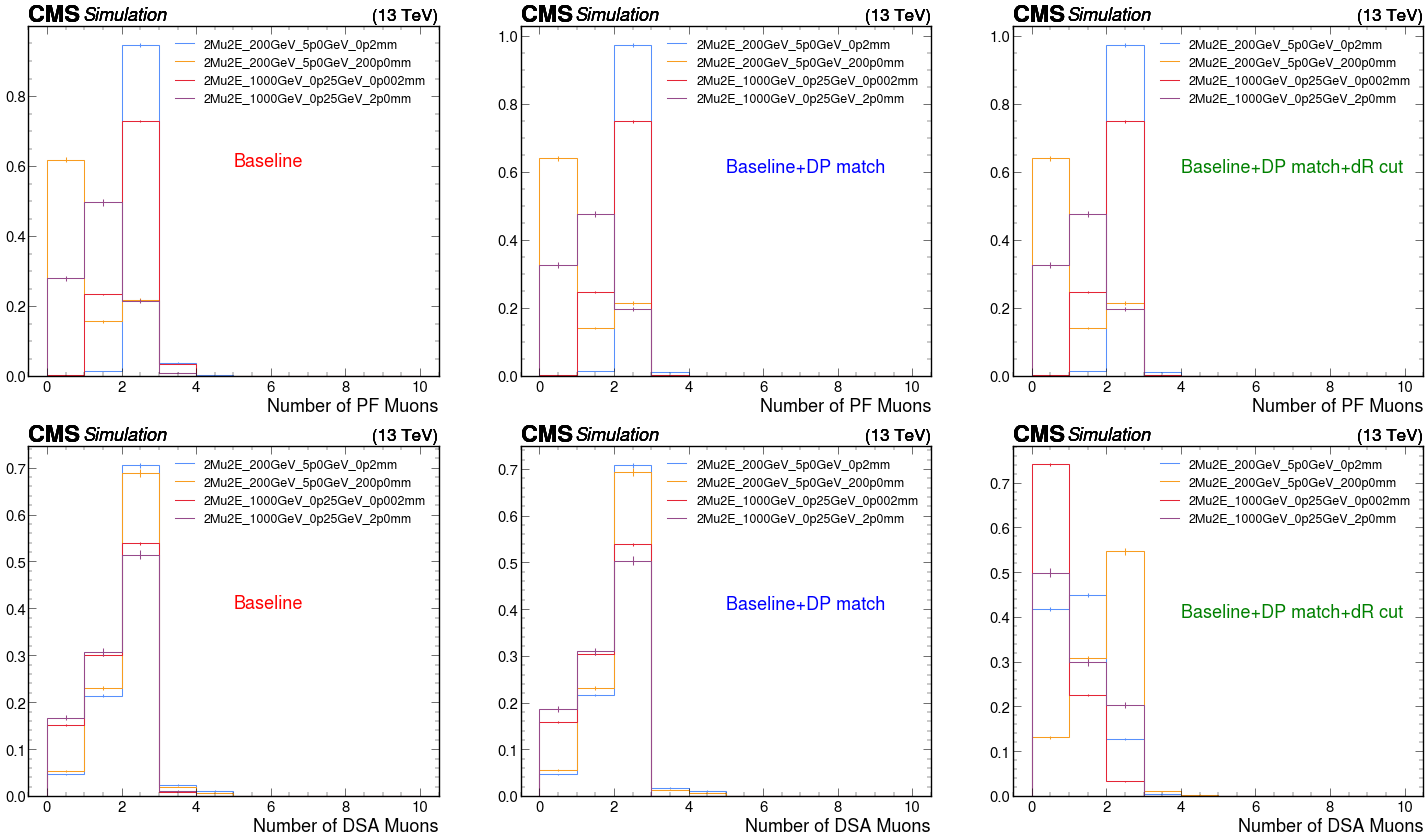

In [30]:
plt.subplots(2,3,figsize=(36,20))

plt.subplot(2,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,0.6,"Baseline", color='r')

plt.subplot(2,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_n"][channels[1], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,0.6,"Baseline+DP match", color='b')

plt.subplot(2,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_n"][channels[2], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(4,0.6,"Baseline+DP match+dR cut", color='g')

plt.subplot(2,3,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,0.4,"Baseline", color='r')

plt.subplot(2,3,5)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_n"][channels[1], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,0.4,"Baseline+DP match", color='b')

plt.subplot(2,3,6)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_n"][channels[2], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(4,0.4,"Baseline+DP match+dR cut", color='g')

Text(1, 0, 'Number of DSA Muons [Inside Mu-LJ]')

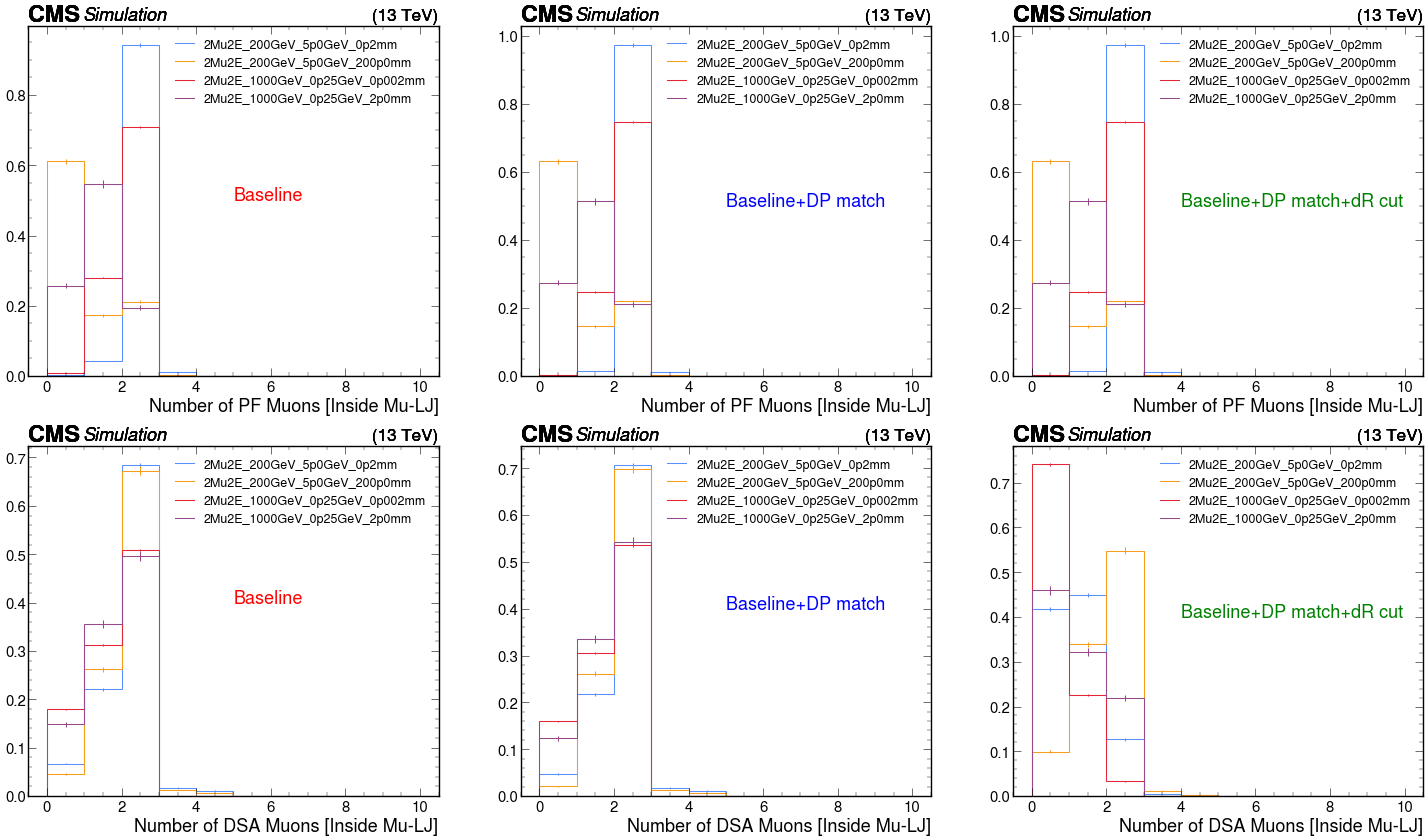

In [32]:
plt.subplots(2,3,figsize=(36,20))

plt.subplot(2,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["mu_lj_pfMu_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,.5,"Baseline", color='r')
plt.xlabel("Number of PF Muons [Inside Mu-LJ]")

plt.subplot(2,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["mu_lj_pfMu_n"][channels[1], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,.5,"Baseline+DP match", color='b')
plt.xlabel("Number of PF Muons [Inside Mu-LJ]")

plt.subplot(2,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["mu_lj_pfMu_n"][channels[2], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(4,.5,"Baseline+DP match+dR cut", color='g')
plt.xlabel("Number of PF Muons [Inside Mu-LJ]")

plt.subplot(2,3,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["mu_lj_dsaMu_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,.4,"Baseline", color='r')
plt.xlabel("Number of DSA Muons [Inside Mu-LJ]")

plt.subplot(2,3,5)
for sample in samples:
    utilities.plot(out[sample]["hists"]["mu_lj_dsaMu_n"][channels[1], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,.4,"Baseline+DP match", color='b')
plt.xlabel("Number of DSA Muons [Inside Mu-LJ]")

plt.subplot(2,3,6)
for sample in samples:
    utilities.plot(out[sample]["hists"]["mu_lj_dsaMu_n"][channels[2], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(4,.4,"Baseline+DP match+dR cut", color='g')
plt.xlabel("Number of DSA Muons [Inside Mu-LJ]")

Text(4, 0.6, 'Baseline+DP match+dR cut')

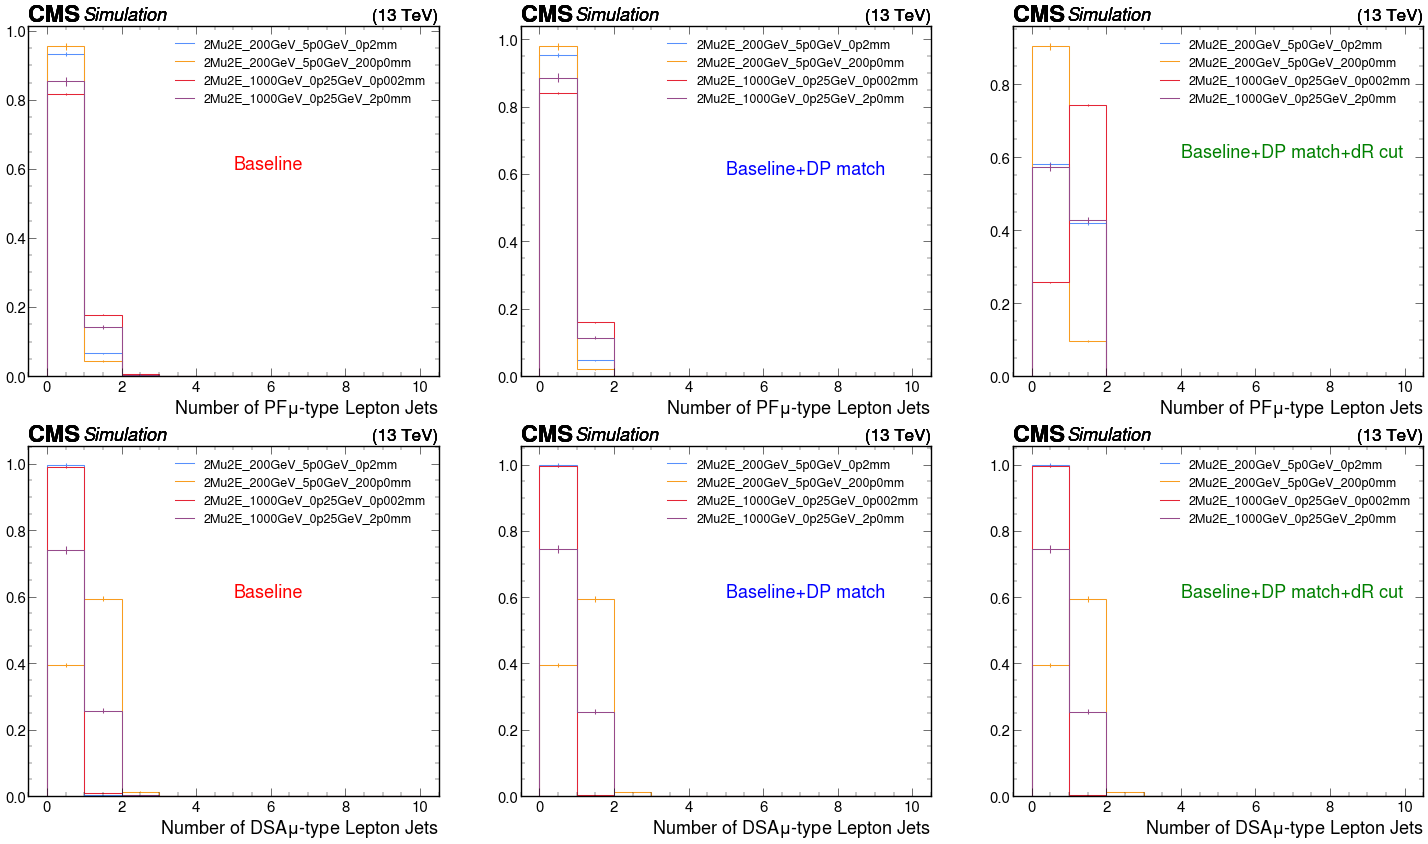

In [34]:
plt.subplots(2,3,figsize=(36,20))

plt.subplot(2,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfmu_lj_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,.6,"Baseline", color='r')

plt.subplot(2,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfmu_lj_n"][channels[1], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,.6,"Baseline+DP match", color='b')

plt.subplot(2,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfmu_lj_n"][channels[2], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(4,.6,"Baseline+DP match+dR cut", color='g')

plt.subplot(2,3,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsamu_lj_n"][channels[0], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,.6,"Baseline", color='r')

plt.subplot(2,3,5)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsamu_lj_n"][channels[1], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(5,.6,"Baseline+DP match", color='b')

plt.subplot(2,3,6)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsamu_lj_n"][channels[2], :], density=True)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(4,.6,"Baseline+DP match+dR cut", color='g')

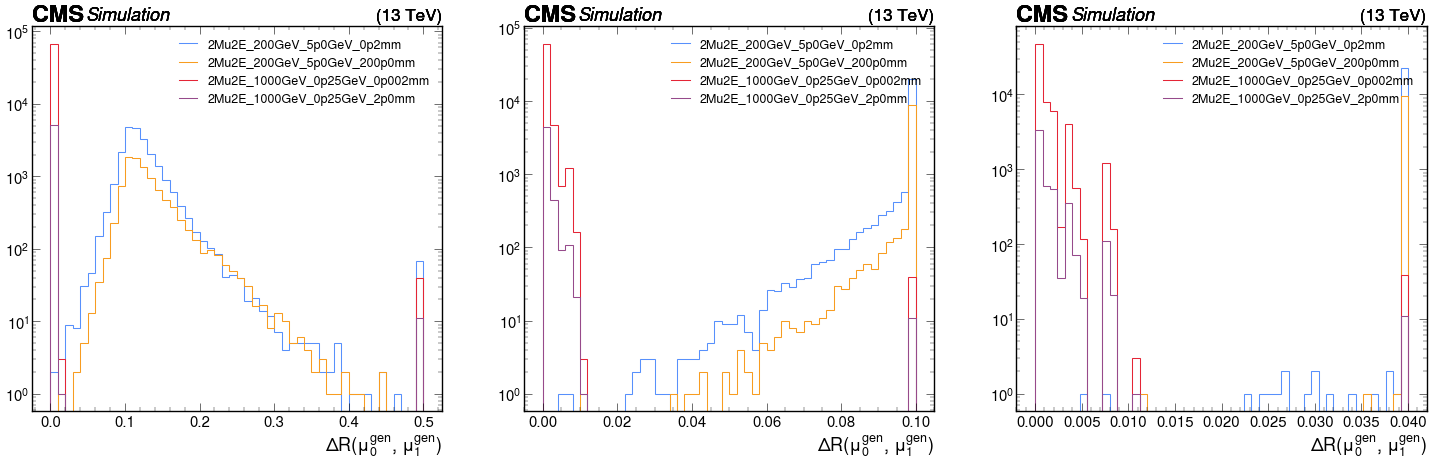

In [20]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genMu_genMu_dR_lowRange"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(1,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genMu_genMu_dR_XLowRange"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(1,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genMu_genMu_dR_XXLowRange"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

Text(2, 500, 'Baseline+DP match+dR cut')

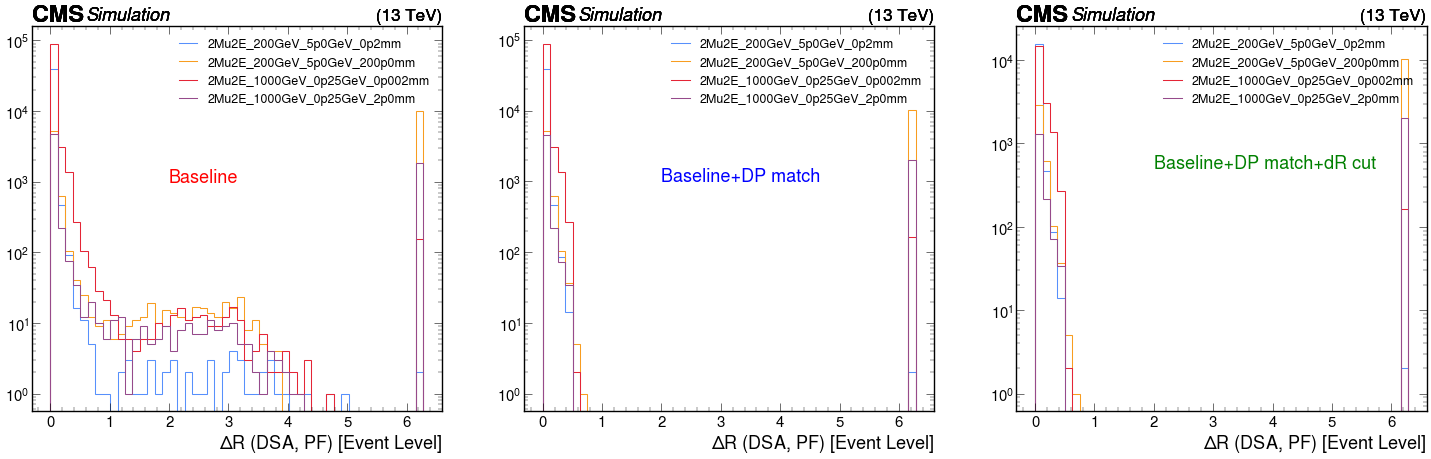

In [42]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")
plt.text(2,1000,"Baseline", color='r')

plt.subplot(1,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")
plt.text(2,1000,"Baseline+DP match", color='b')

plt.subplot(1,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")
plt.text(2,500,"Baseline+DP match+dR cut", color='g')

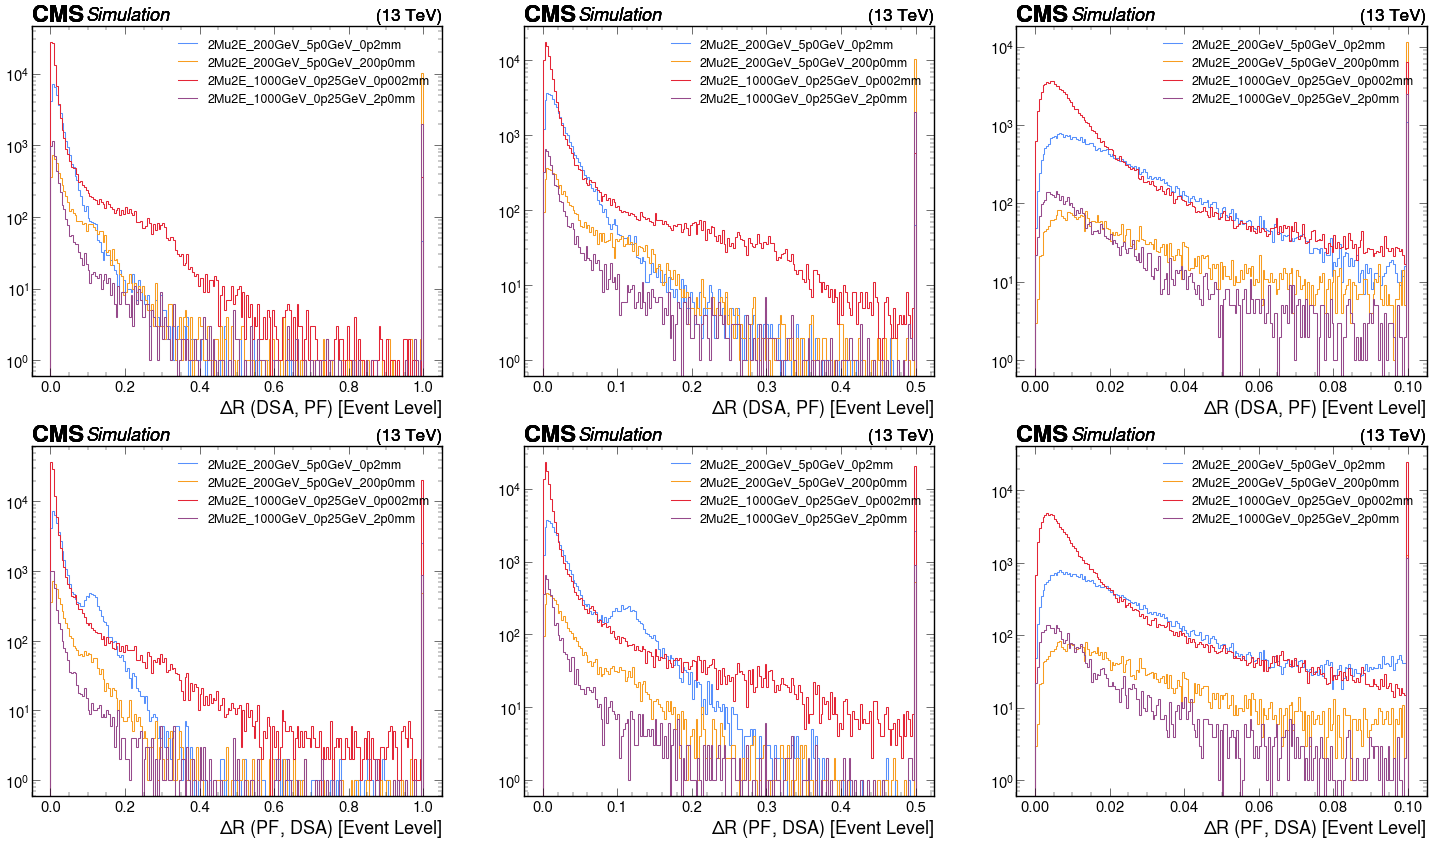

In [6]:
plt.subplots(2,3,figsize=(36,20))

plt.subplot(2,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_lowRange_extrabin"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_XlowRange_extrabin"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_XXlowRange_extrabin"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_lowRange_extrabin"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,5)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_XlowRange_extrabin"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,6)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_XXlowRange_extrabin"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

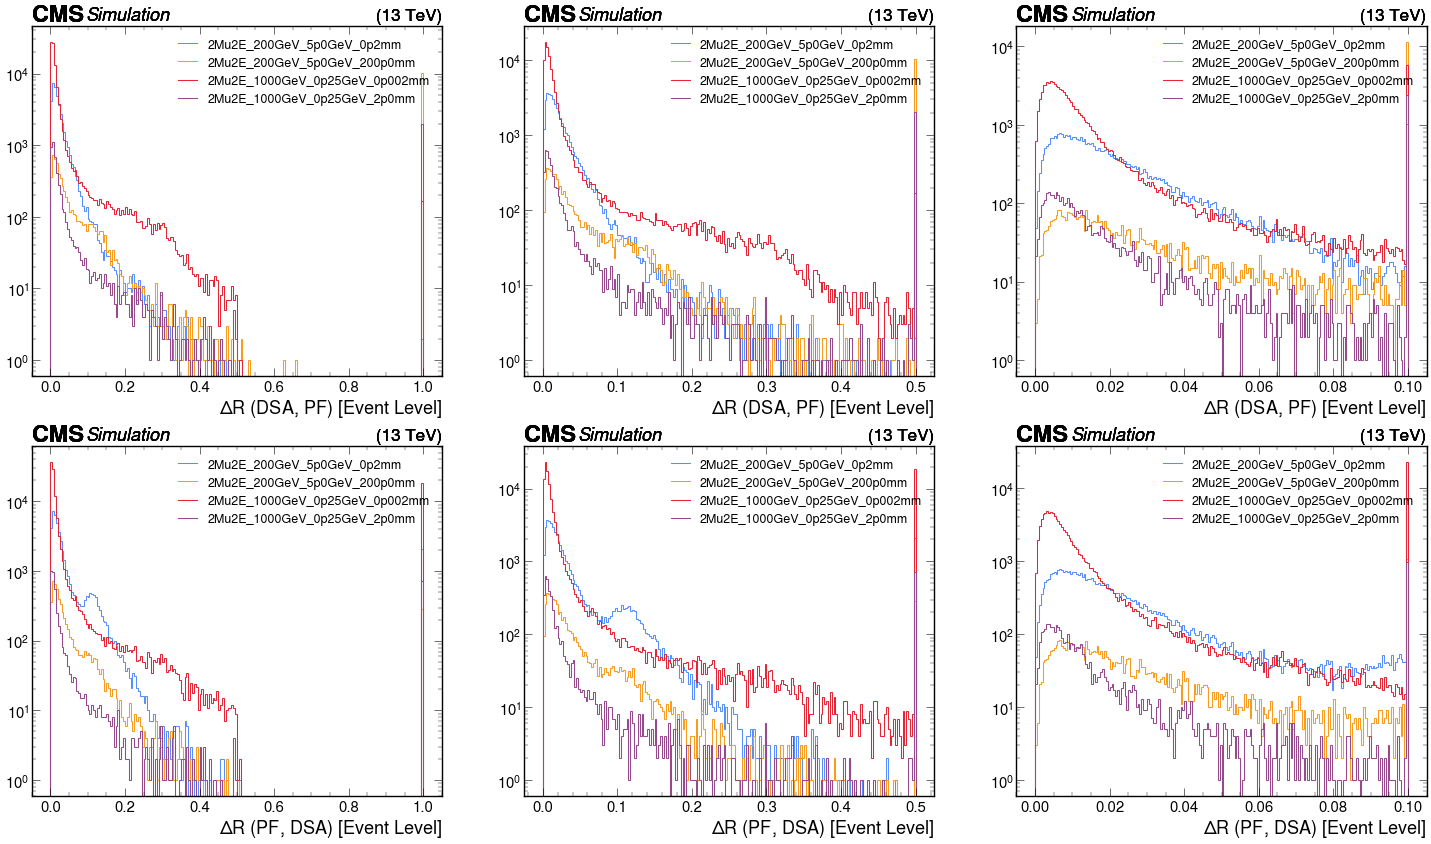

In [7]:
plt.subplots(2,3,figsize=(36,20))

plt.subplot(2,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_lowRange_extrabin"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_XlowRange_extrabin"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_XXlowRange_extrabin"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_lowRange_extrabin"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,5)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_XlowRange_extrabin"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,6)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_XXlowRange_extrabin"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

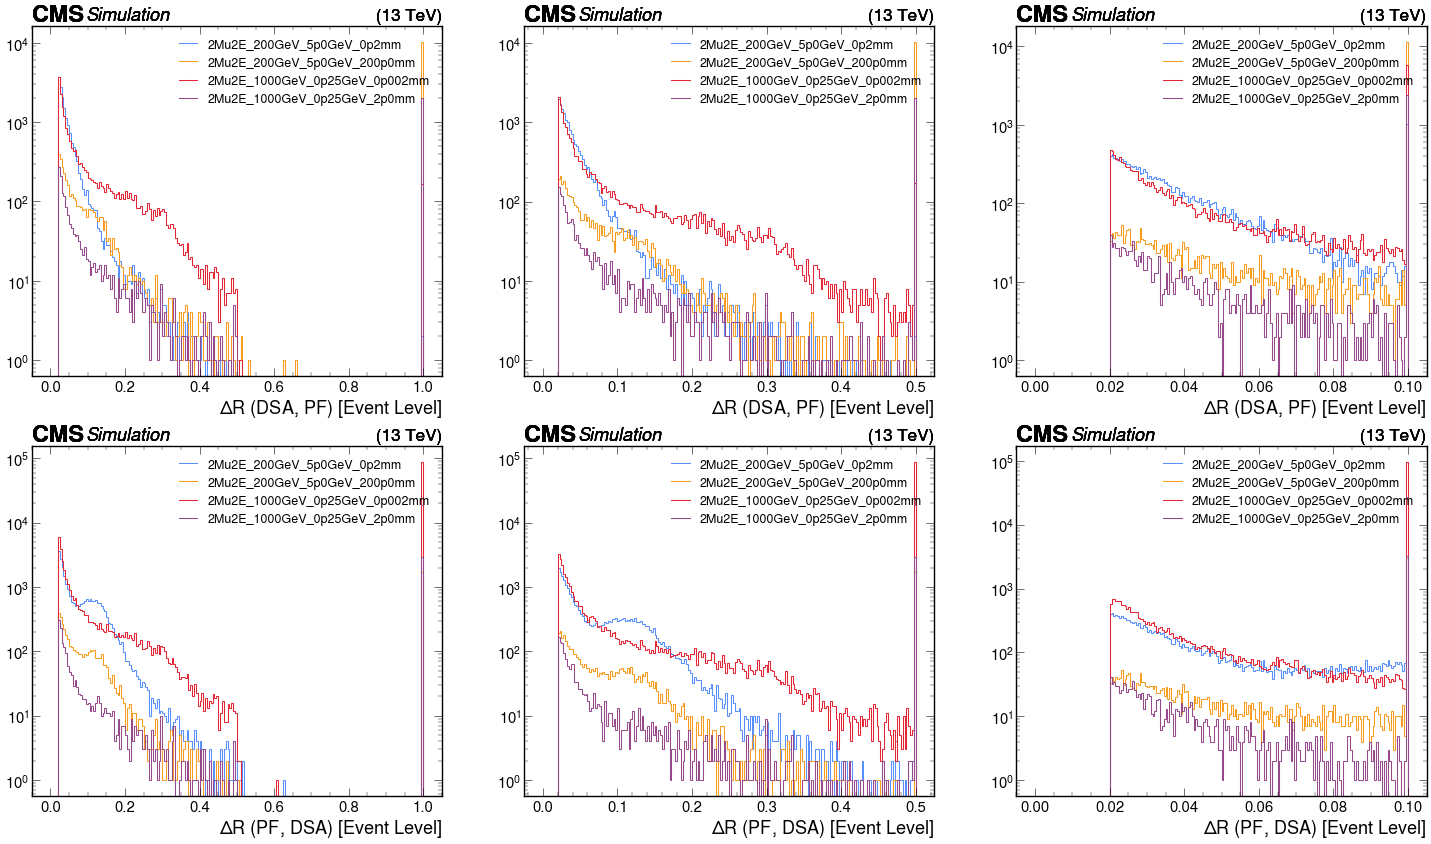

In [8]:
plt.subplots(2,3,figsize=(36,20))

plt.subplot(2,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_lowRange_extrabin"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_XlowRange_extrabin"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["dsaMuon_pfMuon_dR_XXlowRange_extrabin"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_lowRange_extrabin"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,5)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_XlowRange_extrabin"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,3,6)
for sample in samples:
    utilities.plot(out[sample]["hists"]["pfMuon_dsaMuon_dR_XXlowRange_extrabin"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

In [10]:
col_dsapf_hist_array_low_flow = out["2Mu2E_1000GeV_0p25GeV_0p002mm"]["hists"]["dsaMuon_pfMuon_dR_lowRange_extrabin"][channels[0], :].values(flow=True)
col_dsapf_hist_array_high_flow = out["2Mu2E_1000GeV_0p25GeV_2p0mm"]["hists"]["dsaMuon_pfMuon_dR_lowRange_extrabin"][channels[0], :].values(flow=True)
col_pfdsa_hist_array_low_flow = out["2Mu2E_1000GeV_0p25GeV_0p002mm"]["hists"]["pfMuon_dsaMuon_dR_lowRange_extrabin"][channels[0], :].values(flow=True)
col_pfdsa_hist_array_high_flow = out["2Mu2E_1000GeV_0p25GeV_2p0mm"]["hists"]["pfMuon_dsaMuon_dR_lowRange_extrabin"][channels[0], :].values(flow=True)

nocol_dsapf_hist_array_low_flow = out["2Mu2E_200GeV_5p0GeV_0p2mm"]["hists"]["dsaMuon_pfMuon_dR_lowRange_extrabin"][channels[0], :].values(flow=True)
nocol_dsapf_hist_array_high_flow = out["2Mu2E_200GeV_5p0GeV_200p0mm"]["hists"]["dsaMuon_pfMuon_dR_lowRange_extrabin"][channels[0], :].values(flow=True)
nocol_pfdsa_hist_array_low_flow = out["2Mu2E_200GeV_5p0GeV_0p2mm"]["hists"]["pfMuon_dsaMuon_dR_lowRange_extrabin"][channels[0], :].values(flow=True)
nocol_pfdsa_hist_array_high_flow = out["2Mu2E_200GeV_5p0GeV_200p0mm"]["hists"]["pfMuon_dsaMuon_dR_lowRange_extrabin"][channels[0], :].values(flow=True)

bin_edges = out["2Mu2E_1000GeV_0p25GeV_0p002mm"]["hists"]["dsaMuon_pfMuon_dR_lowRange_extrabin"].axes[1].edges

In [11]:
col_dsapf_hist_array_low = col_dsapf_hist_array_low_flow[1:]
col_dsapf_hist_array_high = col_dsapf_hist_array_high_flow[1:]

col_pfdsa_hist_array_low = col_pfdsa_hist_array_low_flow[1:]
col_pfdsa_hist_array_high = col_pfdsa_hist_array_high_flow[1:]

col_dsapf_total_low = np.sum(col_dsapf_hist_array_low)
col_dsapf_total_high = np.sum(col_dsapf_hist_array_high)

col_pfdsa_total_low = np.sum(col_pfdsa_hist_array_low)
col_pfdsa_total_high = np.sum(col_pfdsa_hist_array_high)

In [12]:
print(col_dsapf_total_low)
print(col_dsapf_total_high)
print(col_pfdsa_total_low)
print(col_pfdsa_total_high)

95226.0
7054.0
121882.0
4916.0


In [13]:
nocol_dsapf_hist_array_low = nocol_dsapf_hist_array_low_flow[1:]
nocol_dsapf_hist_array_high = nocol_dsapf_hist_array_high_flow[1:]

nocol_pfdsa_hist_array_low = nocol_pfdsa_hist_array_low_flow[1:]
nocol_pfdsa_hist_array_high = nocol_pfdsa_hist_array_high_flow[1:]

nocol_dsapf_total_low = np.sum(nocol_dsapf_hist_array_low)
nocol_dsapf_total_high = np.sum(nocol_dsapf_hist_array_high)

nocol_pfdsa_total_low = np.sum(nocol_pfdsa_hist_array_low)
nocol_pfdsa_total_high = np.sum(nocol_pfdsa_hist_array_high)

In [14]:
print(nocol_dsapf_total_low)
print(nocol_dsapf_total_high)
print(nocol_pfdsa_total_low)
print(nocol_pfdsa_total_high)

39433.0
16340.0
45903.0
5937.0


In [39]:
def compute_ratio(hist_array, total):
    return np.array([np.sum(hist_array[i:]) / total for i in range(len(hist_array))])

def compute_ratio_inverse(hist_array):
    total = np.sum(hist_array)
    ratios = np.cumsum(hist_array) / total
    # ratios[ratios == 0] = 1e-4
    return ratios

In [40]:
col_dsapf_ratios_low = compute_ratio(col_dsapf_hist_array_low, col_dsapf_total_low)
col_dsapf_ratios_high = compute_ratio(col_dsapf_hist_array_high, col_dsapf_total_high)

col_pfdsa_ratios_low = compute_ratio(col_pfdsa_hist_array_low, col_pfdsa_total_low)
col_pfdsa_ratios_high = compute_ratio(col_pfdsa_hist_array_high, col_pfdsa_total_high)

In [41]:
nocol_dsapf_ratios_low = compute_ratio(nocol_dsapf_hist_array_low, nocol_dsapf_total_low)
nocol_dsapf_ratios_high = compute_ratio(nocol_dsapf_hist_array_high, nocol_dsapf_total_high)

nocol_pfdsa_ratios_low = compute_ratio(nocol_pfdsa_hist_array_low, nocol_pfdsa_total_low)
nocol_pfdsa_ratios_high = compute_ratio(nocol_pfdsa_hist_array_high, nocol_pfdsa_total_high)

In [42]:
col_dsapf_adjustment_low = np.full_like(col_dsapf_ratios_low, col_dsapf_ratios_low[-1], dtype=float)
col_dsapf_adjustment_low[0] = 0 

col_dsapf_adjustment_high = np.full_like(col_dsapf_ratios_high, col_dsapf_ratios_high[-1], dtype=float)
col_dsapf_adjustment_high[0] = 0 

col_pfdsa_adjustment_low = np.full_like(col_pfdsa_ratios_low, col_pfdsa_ratios_low[-1], dtype=float)
col_pfdsa_adjustment_low[0] = 0 

col_pfdsa_adjustment_high = np.full_like(col_pfdsa_ratios_high, col_pfdsa_ratios_high[-1], dtype=float)
col_pfdsa_adjustment_high[0] = 0 

In [43]:
nocol_dsapf_adjustment_low = np.full_like(nocol_dsapf_ratios_low, nocol_dsapf_ratios_low[-1], dtype=float)
nocol_dsapf_adjustment_low[0] = 0 

nocol_dsapf_adjustment_high = np.full_like(nocol_dsapf_ratios_high, nocol_dsapf_ratios_high[-1], dtype=float)
nocol_dsapf_adjustment_high[0] = 0 

nocol_pfdsa_adjustment_low = np.full_like(nocol_pfdsa_ratios_low, nocol_pfdsa_ratios_low[-1], dtype=float)
nocol_pfdsa_adjustment_low[0] = 0 

nocol_pfdsa_adjustment_high = np.full_like(nocol_pfdsa_ratios_high, nocol_pfdsa_ratios_high[-1], dtype=float)
nocol_pfdsa_adjustment_high[0] = 0 

In [44]:
col_dsapf_ratios_high_new = col_dsapf_ratios_high - col_dsapf_adjustment_high
col_dsapf_ratios_low_new = col_dsapf_ratios_low - col_dsapf_adjustment_low

col_pfdsa_ratios_high_new = col_pfdsa_ratios_high - col_pfdsa_adjustment_high
col_pfdsa_ratios_low_new = col_pfdsa_ratios_low - col_pfdsa_adjustment_low

In [45]:
nocol_dsapf_ratios_high_new = nocol_dsapf_ratios_high - nocol_dsapf_adjustment_high
nocol_dsapf_ratios_low_new = nocol_dsapf_ratios_low - nocol_dsapf_adjustment_low

nocol_pfdsa_ratios_high_new = nocol_pfdsa_ratios_high - nocol_pfdsa_adjustment_high
nocol_pfdsa_ratios_low_new = nocol_pfdsa_ratios_low - nocol_pfdsa_adjustment_low

In [46]:
dr_thresholds = bin_edges

In [47]:
col_dsapf_ratios_low_inverse = compute_ratio_inverse(col_dsapf_hist_array_low)
col_dsapf_ratios_high_inverse = compute_ratio_inverse(col_dsapf_hist_array_high)
col_pfdsa_ratios_low_inverse = compute_ratio_inverse(col_pfdsa_hist_array_low)
col_pfdsa_ratios_high_inverse = compute_ratio_inverse(col_pfdsa_hist_array_high)

In [48]:
nocol_dsapf_ratios_low_inverse = compute_ratio_inverse(nocol_dsapf_hist_array_low)
nocol_dsapf_ratios_high_inverse = compute_ratio_inverse(nocol_dsapf_hist_array_high)
nocol_pfdsa_ratios_low_inverse = compute_ratio_inverse(nocol_pfdsa_hist_array_low)
nocol_pfdsa_ratios_high_inverse = compute_ratio_inverse(nocol_pfdsa_hist_array_high)

In [49]:
bin_edges_wo_underflow = bin_edges[1:]
bin_width = bin_edges[-1] - bin_edges[-2]
overflow_edge = bin_edges[-1] + bin_width
dr_thresholds = np.append(bin_edges_wo_underflow, overflow_edge)

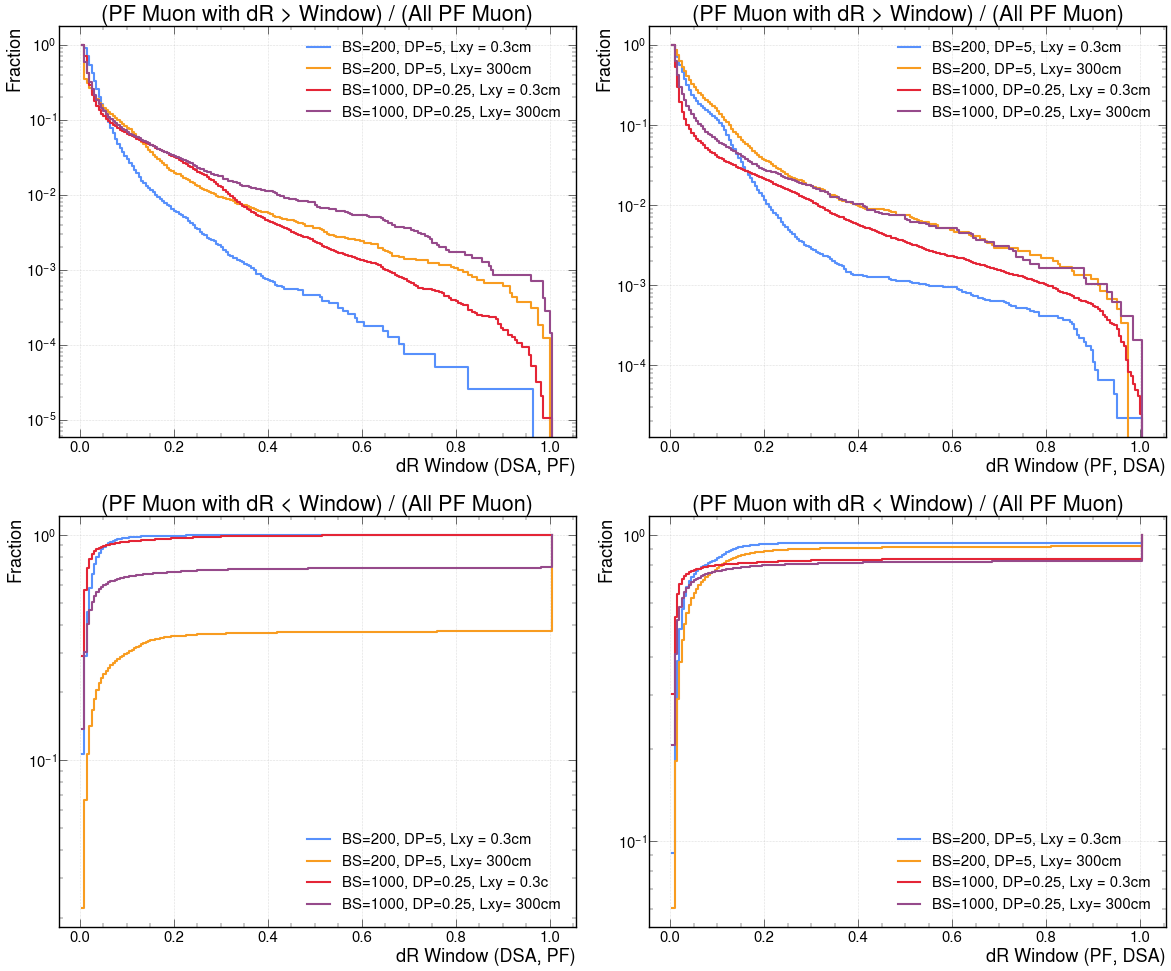

In [53]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
plt.step(dr_thresholds, nocol_dsapf_ratios_low_new, where='post', label='BS=200, DP=5, Lxy = 0.3cm', linewidth=3)
plt.step(dr_thresholds, nocol_dsapf_ratios_high_new, where='post', label='BS=200, DP=5, Lxy= 300cm', linewidth=3)
plt.step(dr_thresholds, col_dsapf_ratios_low_new, where='post', label='BS=1000, DP=0.25, Lxy = 0.3cm', linewidth=3)
plt.step(dr_thresholds, col_dsapf_ratios_high_new, where='post', label='BS=1000, DP=0.25, Lxy= 300cm', linewidth=3)
plt.xlabel("dR Window (DSA, PF)")
plt.ylabel("Fraction")
plt.title("(PF Muon with dR > Window) / (All PF Muon)")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.tight_layout()
plt.yscale("log")

plt.subplot(2,2,2)
plt.step(dr_thresholds, nocol_pfdsa_ratios_low_new, where='post', label='BS=200, DP=5, Lxy = 0.3cm', linewidth=3)
plt.step(dr_thresholds, nocol_pfdsa_ratios_high_new, where='post', label='BS=200, DP=5, Lxy= 300cm', linewidth=3)
plt.step(dr_thresholds, col_pfdsa_ratios_low_new, where='post', label='BS=1000, DP=0.25, Lxy = 0.3cm', linewidth=3)
plt.step(dr_thresholds, col_pfdsa_ratios_high_new, where='post', label='BS=1000, DP=0.25, Lxy= 300cm', linewidth=3)
plt.xlabel("dR Window (PF, DSA)")
plt.ylabel("Fraction")
plt.title("(PF Muon with dR > Window) / (All PF Muon)")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.xlim(0,0.2)
plt.yscale("log")

plt.subplot(2,2,3)
plt.step(dr_thresholds, nocol_dsapf_ratios_low_inverse, where='post', label='BS=200, DP=5, Lxy = 0.3cm', linewidth=3)
plt.step(dr_thresholds, nocol_dsapf_ratios_high_inverse, where='post', label='BS=200, DP=5, Lxy= 300cm', linewidth=3)
plt.step(dr_thresholds, col_dsapf_ratios_low_inverse, where='post', label='BS=1000, DP=0.25, Lxy = 0.3c', linewidth=3)
plt.step(dr_thresholds, col_dsapf_ratios_high_inverse, where='post', label='BS=1000, DP=0.25, Lxy= 300cm', linewidth=3)
plt.xlabel("dR Window (DSA, PF)")
plt.ylabel("Fraction")
plt.title("(PF Muon with dR < Window) / (All PF Muon)")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.xlim(0,0.2)
plt.yscale("log")

plt.subplot(2,2,4)
plt.step(dr_thresholds, nocol_pfdsa_ratios_low_inverse, where='post', label='BS=200, DP=5, Lxy = 0.3cm', linewidth=3)
plt.step(dr_thresholds, nocol_pfdsa_ratios_high_inverse, where='post', label='BS=200, DP=5, Lxy= 300cm', linewidth=3)
plt.step(dr_thresholds, col_pfdsa_ratios_low_inverse, where='post', label='BS=1000, DP=0.25, Lxy = 0.3cm', linewidth=3)
plt.step(dr_thresholds, col_pfdsa_ratios_high_inverse, where='post', label='BS=1000, DP=0.25, Lxy= 300cm', linewidth=3)
# plt.xlim(0,0.2)
plt.xlabel("dR Window (PF, DSA)")
plt.ylabel("Fraction")
plt.title("(PF Muon with dR < Window) / (All PF Muon)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.yscale("log")

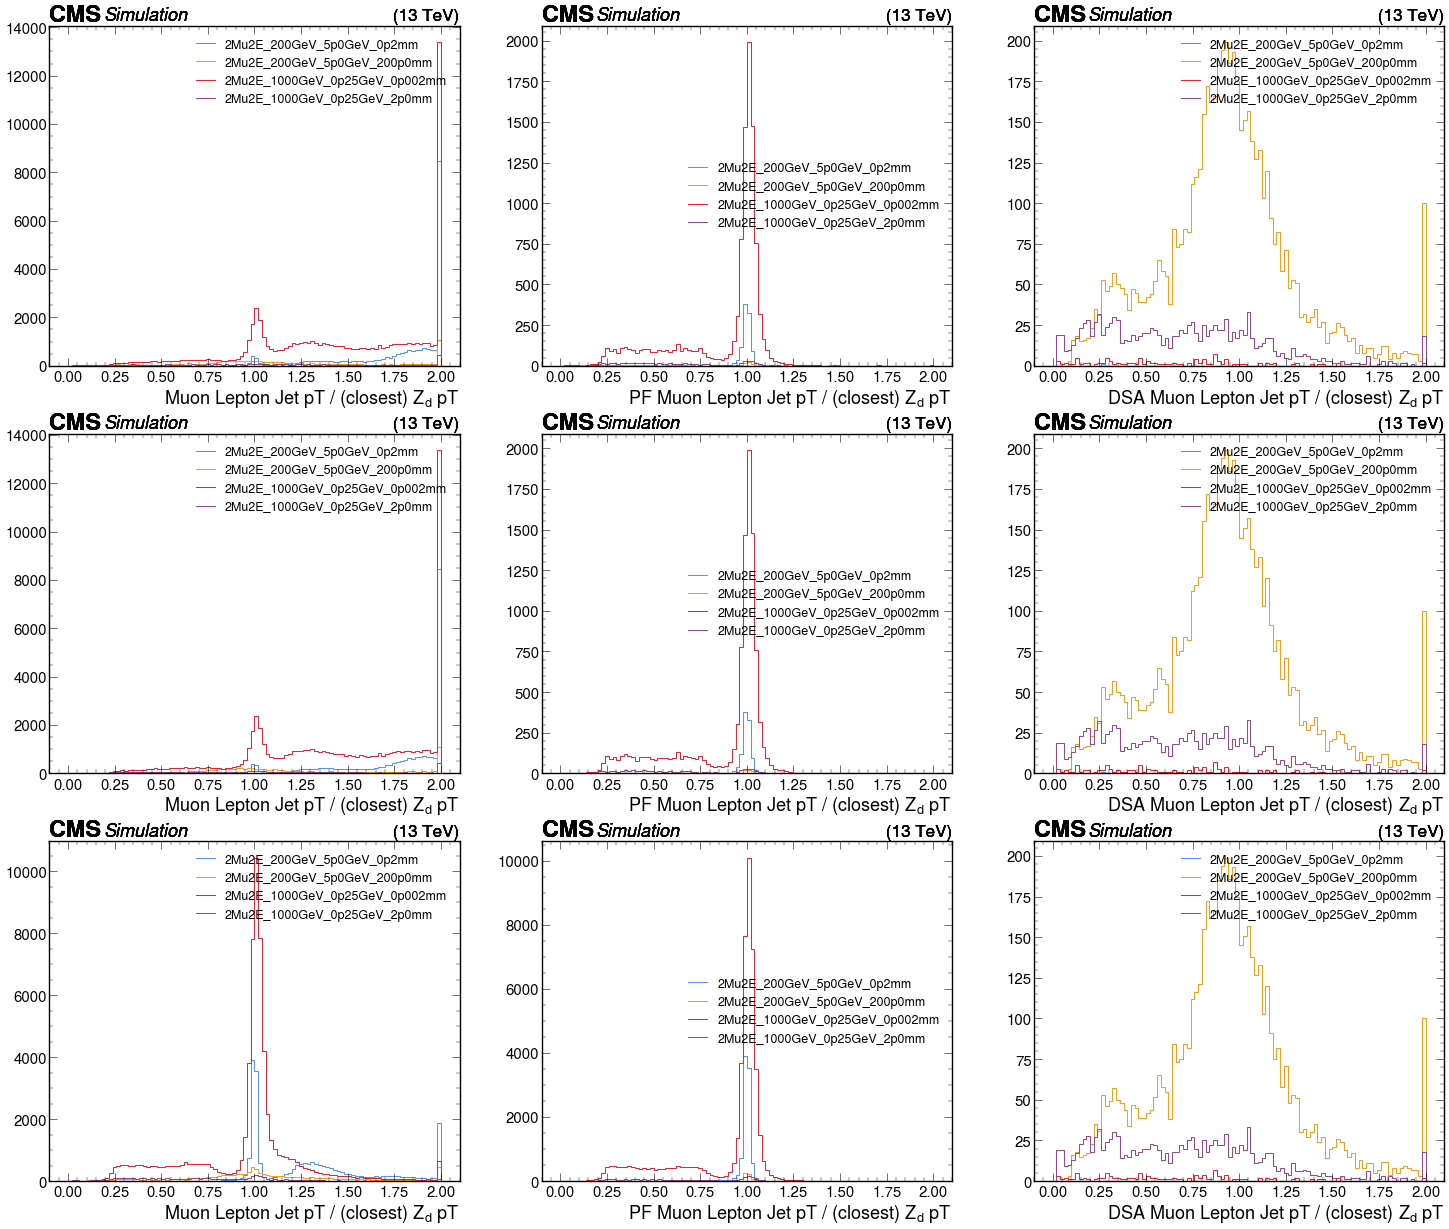

In [73]:
plt.subplots(3,3,figsize=(36,30))

plt.subplot(3,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_muLj_ptRatio"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(3,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_pfMuonLj_ptRatio"][channels[0], :], density=False, yerr=False)
plt.legend(samples, prop={'size': 18})

plt.subplot(3,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_dsaMuonLj_ptRatio"][channels[0], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(3,3,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_muLj_ptRatio"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(3,3,5)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_pfMuonLj_ptRatio"][channels[1], :], density=False, yerr=False)
plt.legend(samples, prop={'size': 18})

plt.subplot(3,3,6)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_dsaMuonLj_ptRatio"][channels[1], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(3,3,7)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_muLj_ptRatio"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(3,3,8)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_pfMuonLj_ptRatio"][channels[2], :], density=False, yerr=False)
plt.legend(samples, prop={'size': 18})

plt.subplot(3,3,9)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_dsaMuonLj_ptRatio"][channels[2], :], density=False, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

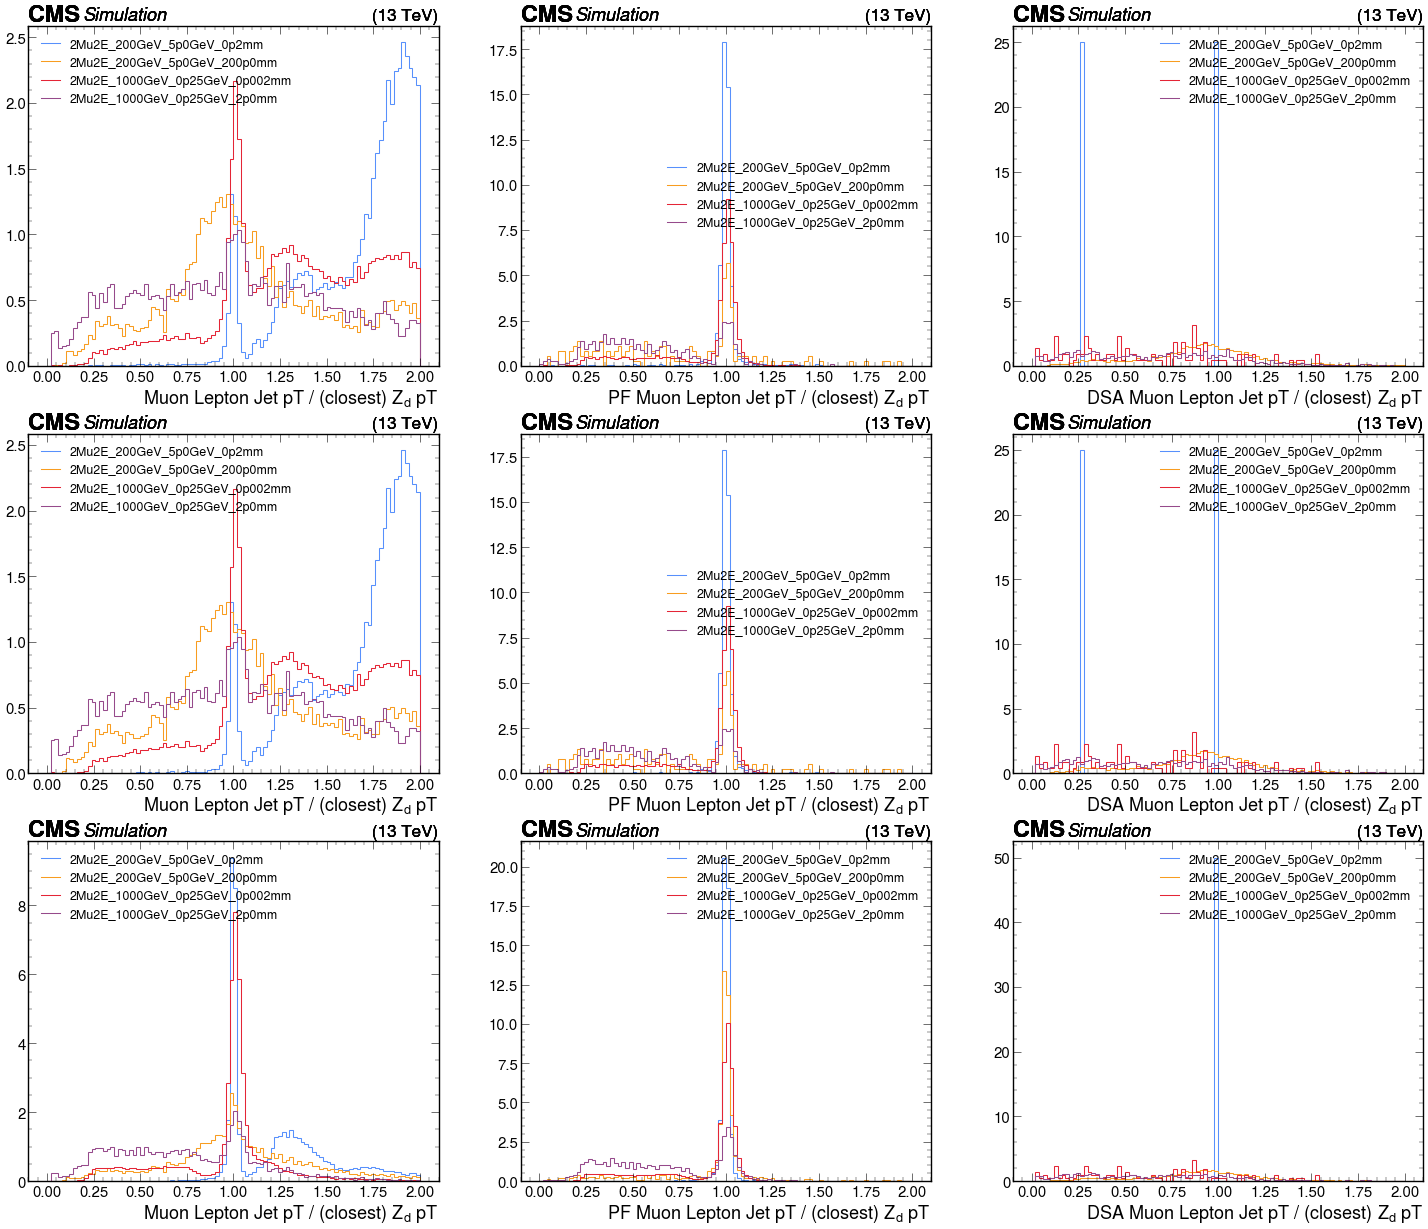

In [45]:
plt.subplots(3,3,figsize=(36,30))

density_op = True

plt.subplot(3,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_muLj_ptRatio"][channels[0], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, loc=2, prop={'size': 18})

plt.subplot(3,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_pfMuonLj_ptRatio"][channels[0], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, prop={'size': 18})

plt.subplot(3,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_dsaMuonLj_ptRatio"][channels[0], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(3,3,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_muLj_ptRatio"][channels[1], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, loc=2, prop={'size': 18})

plt.subplot(3,3,5)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_pfMuonLj_ptRatio"][channels[1], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, prop={'size': 18})

plt.subplot(3,3,6)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_dsaMuonLj_ptRatio"][channels[1], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(3,3,7)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_muLj_ptRatio"][channels[2], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, loc=2, prop={'size': 18})

plt.subplot(3,3,8)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_pfMuonLj_ptRatio"][channels[2], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(3,3,9)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_dsaMuonLj_ptRatio"][channels[2], :], density=density_op, yerr=False, flow='none')
plt.legend(samples, loc=1, prop={'size': 18})

Text(0.0, 10, '$\\mu$ charge sum == 0')

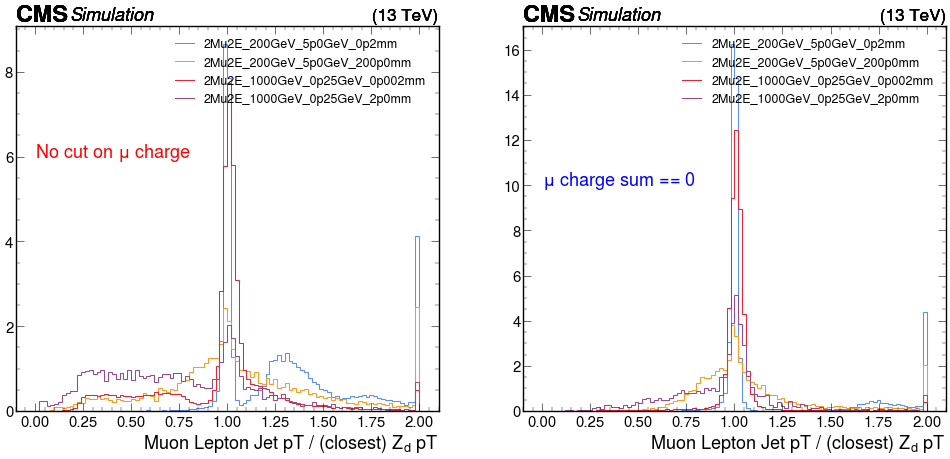

In [81]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_muLj_ptRatio"][channels[2], :], density=True, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(0, 6, "No cut on $\mu$ charge", color='r')

plt.subplot(1,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genA_muLj_ptRatio"][channels[3], :], density=True, yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.text(0.0, 10, "$\mu$ charge sum == 0", color='b')

In [6]:
histnames = [
    "genAs_toMu_lxy_nosel", "genAs_toMu_lxy_noDSA", "genAs_toMu_lxy_oneDSA", "genAs_toMu_lxy_twoDSA",
    "genAs_toMu_lxy_noPF", "genAs_toMu_lxy_noPF_noDSA", "genAs_toMu_lxy_noPF_oneDSA", "genAs_toMu_lxy_noPF_twoDSA",
    "genAs_toMu_lxy_onePF", "genAs_toMu_lxy_onePF_noDSA", "genAs_toMu_lxy_onePF_oneDSA", "genAs_toMu_lxy_onePF_twoDSA",
    "genAs_toMu_lxy_twoPF", "genAs_toMu_lxy_twoPF_noDSA", "genAs_toMu_lxy_twoPF_oneDSA", "genAs_toMu_lxy_twoPF_twoDSA"
]

histnames_large = [
    "genAs_toMu_lxy_nosel_large", "genAs_toMu_lxy_noDSA_large", "genAs_toMu_lxy_oneDSA_large", "genAs_toMu_lxy_twoDSA_large",
    "genAs_toMu_lxy_noPF_large", "genAs_toMu_lxy_noPF_noDSA_large", "genAs_toMu_lxy_noPF_oneDSA_large", "genAs_toMu_lxy_noPF_twoDSA_large",
    "genAs_toMu_lxy_onePF_large", "genAs_toMu_lxy_onePF_noDSA_large", "genAs_toMu_lxy_onePF_oneDSA_large", "genAs_toMu_lxy_onePF_twoDSA_large",
    "genAs_toMu_lxy_twoPF_large", "genAs_toMu_lxy_twoPF_noDSA_large", "genAs_toMu_lxy_twoPF_oneDSA_large", "genAs_toMu_lxy_twoPF_twoDSA_large"
]

histtitle= ["PF=nosel, DSA=nosel", "PF=nosel, DSA=0", "PF=nosel, DSA=1", "PF=nosel, DSA=2",
            "PF=0, DSA=nosel", "PF=0, DSA=0", "PF=0, DSA=1", "PF=0, DSA=2",
            "PF=1, DSA=nosel", "PF=1, DSA=0", "PF=1, DSA=1", "PF=1, DSA=2",
            "PF=2, DSA=nosel", "PF=2, DSA=0", "PF=2, DSA=1", "PF=2, DSA=2",
           ]

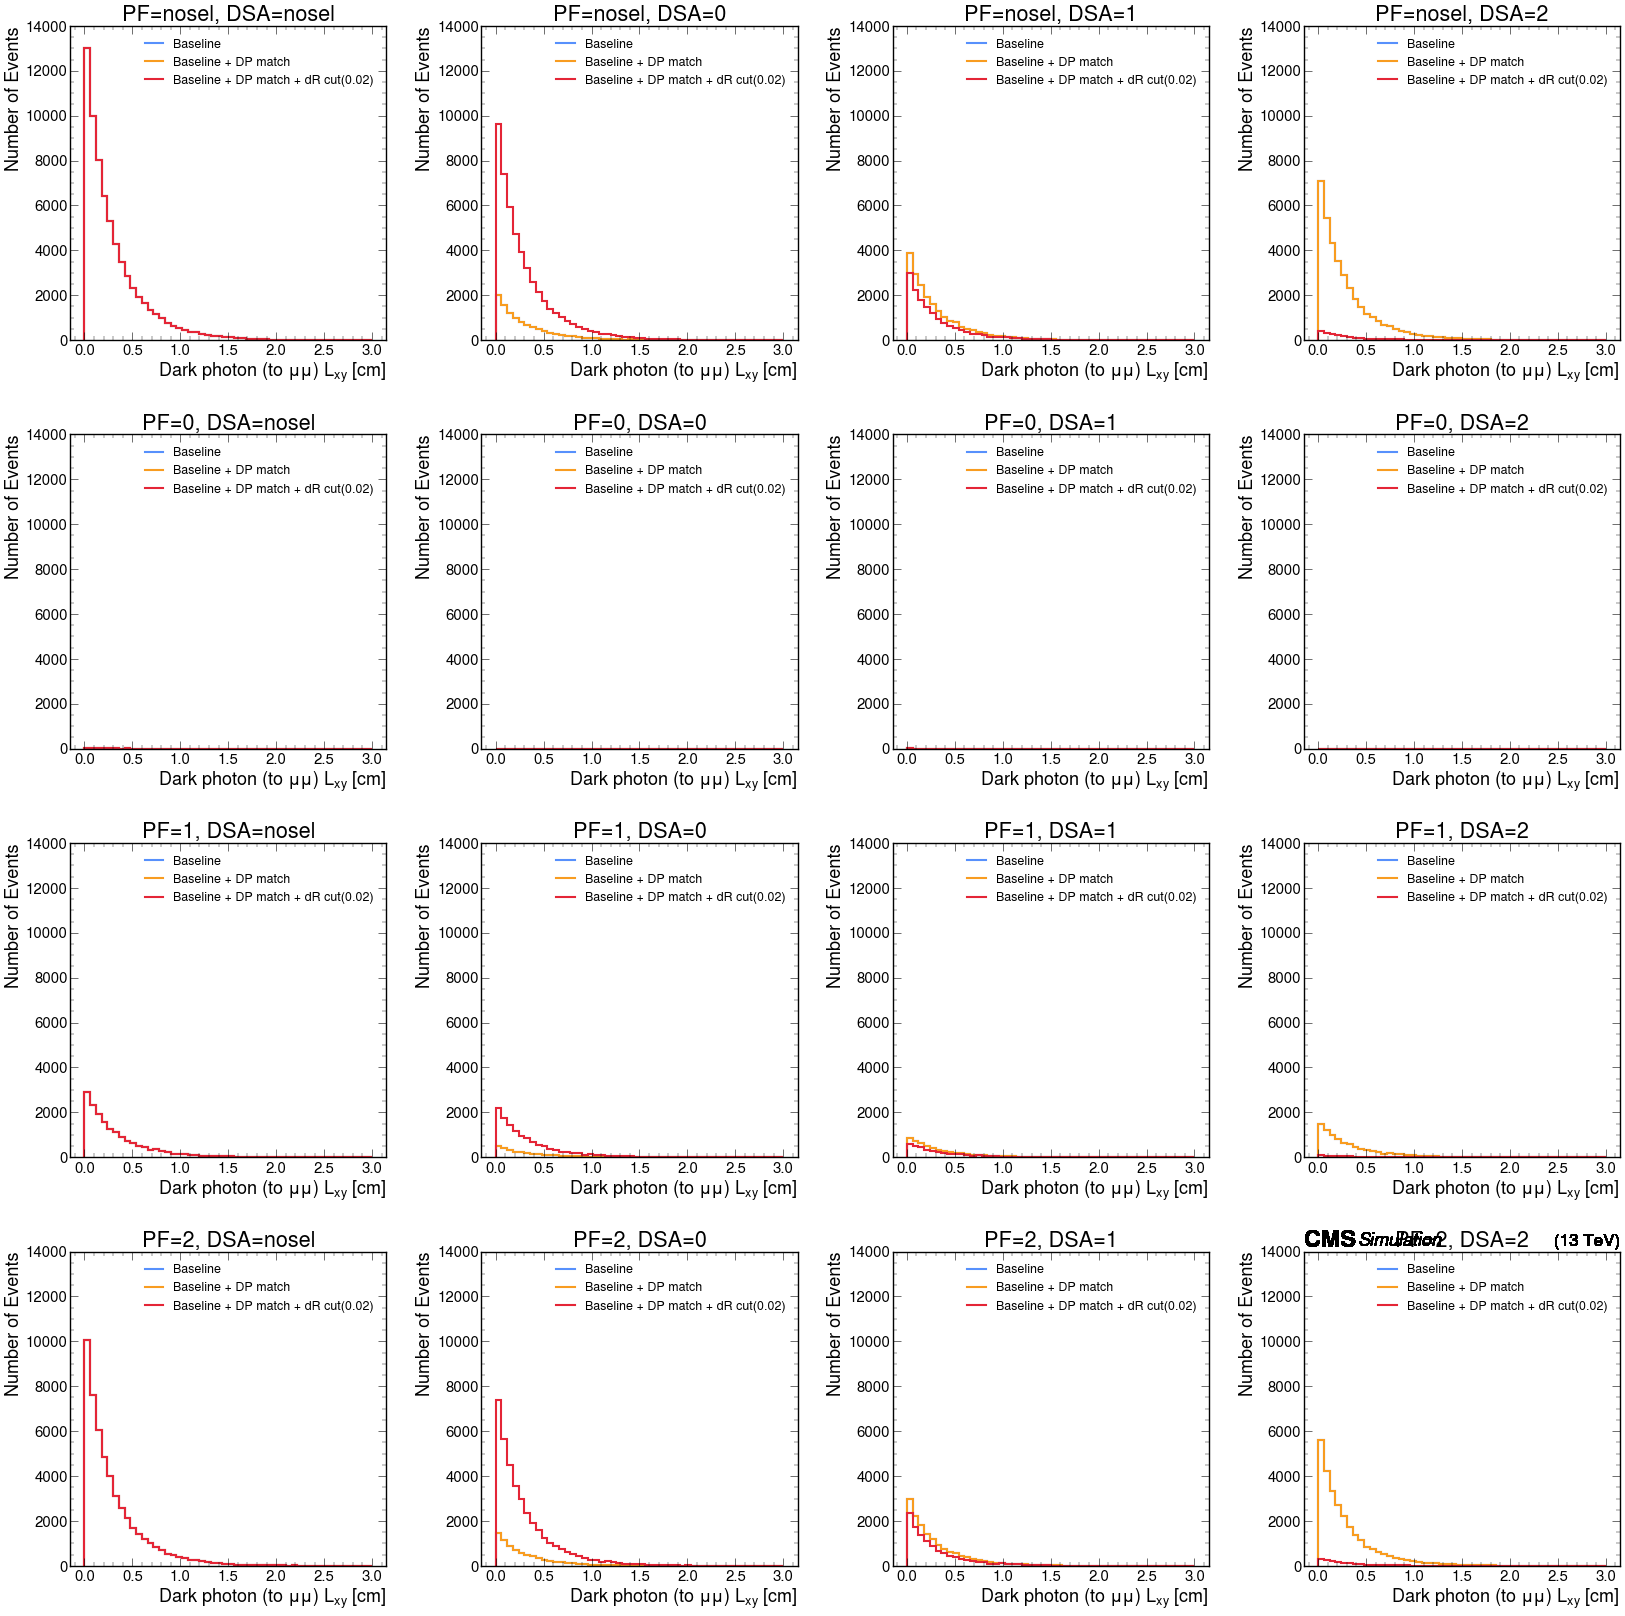

In [10]:
sample = "2Mu2E_1000GeV_0p25GeV_0p002mm"

channels = ["baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02"]
legends = ["Baseline", "Baseline + DP match", "Baseline + DP match + dR cut(0.02)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 14000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

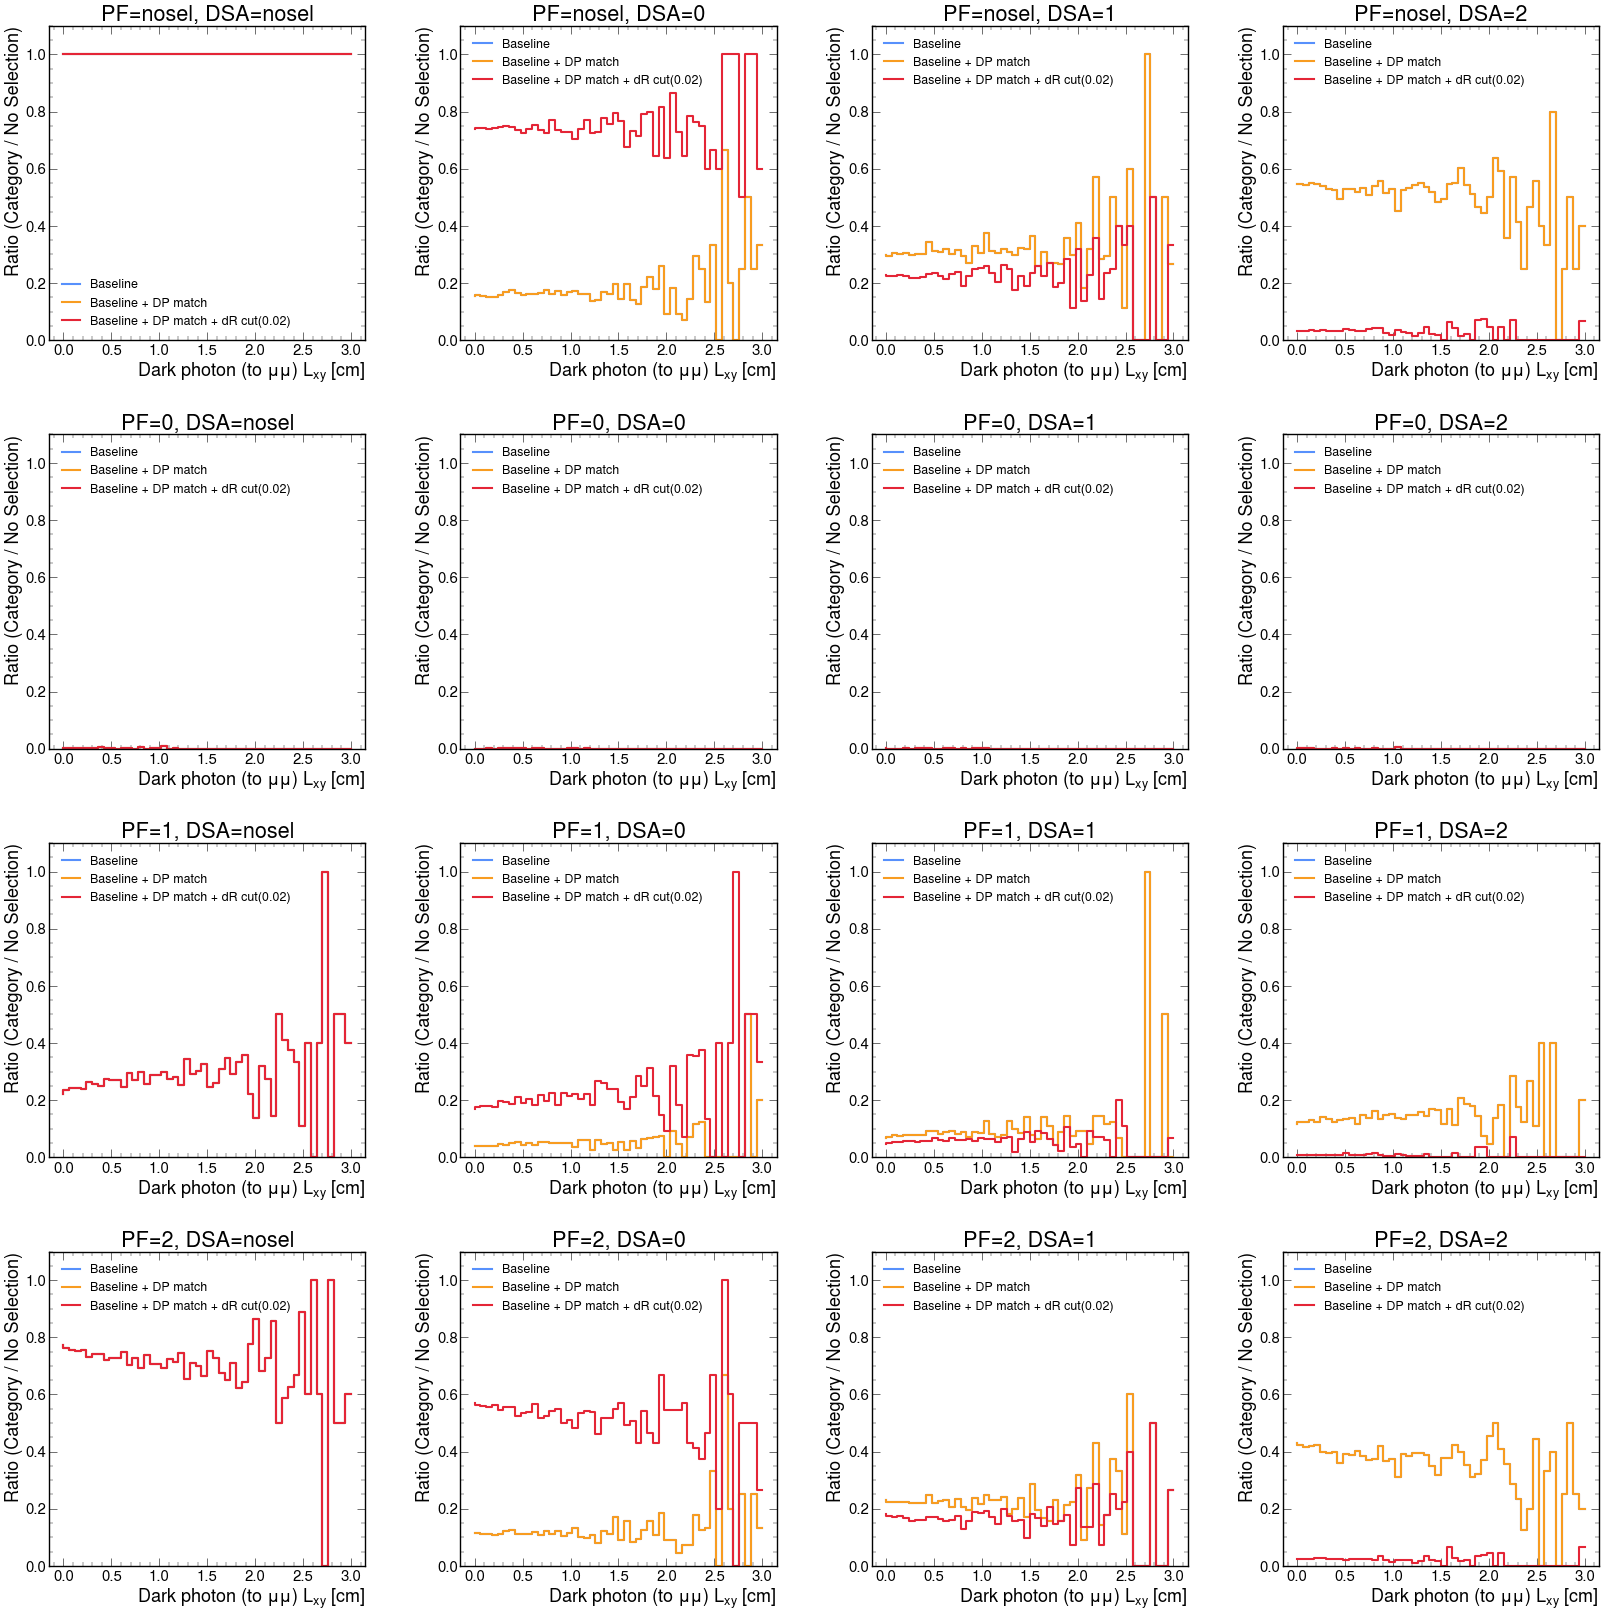

In [9]:
channels = ["baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02"]
legends = ["Baseline", "Baseline + DP match", "Baseline + DP match + dR cut(0.02)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_basic", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_basic", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

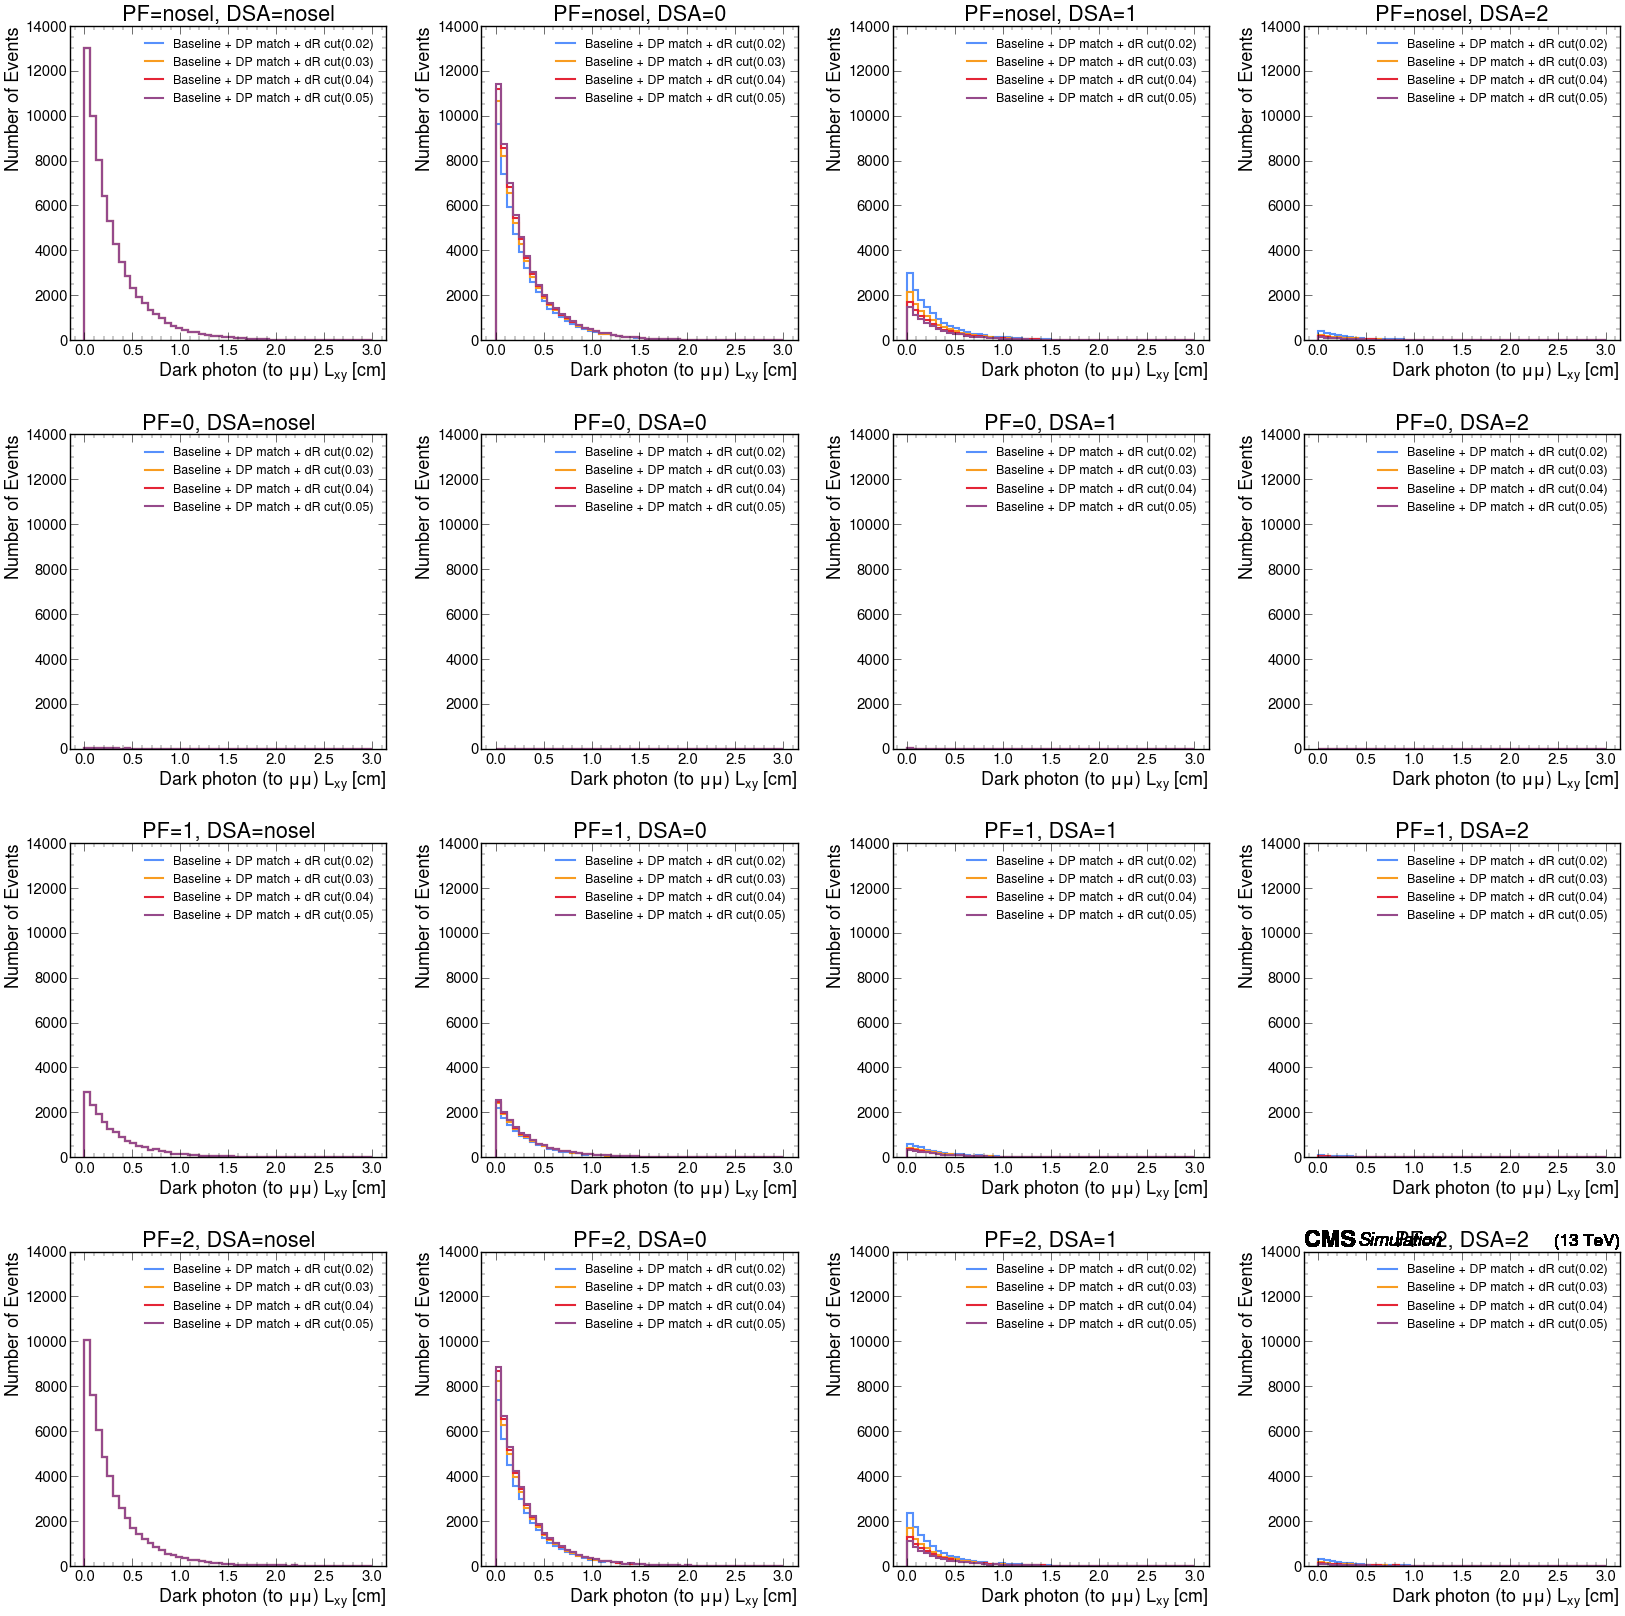

In [10]:
channels = ["baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"]
legends = ["Baseline + DP match + dR cut(0.02)", "Baseline + DP match + dR cut(0.03)", "Baseline + DP match + dR cut(0.04)", "Baseline + DP match + dR cut(0.05)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 14000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

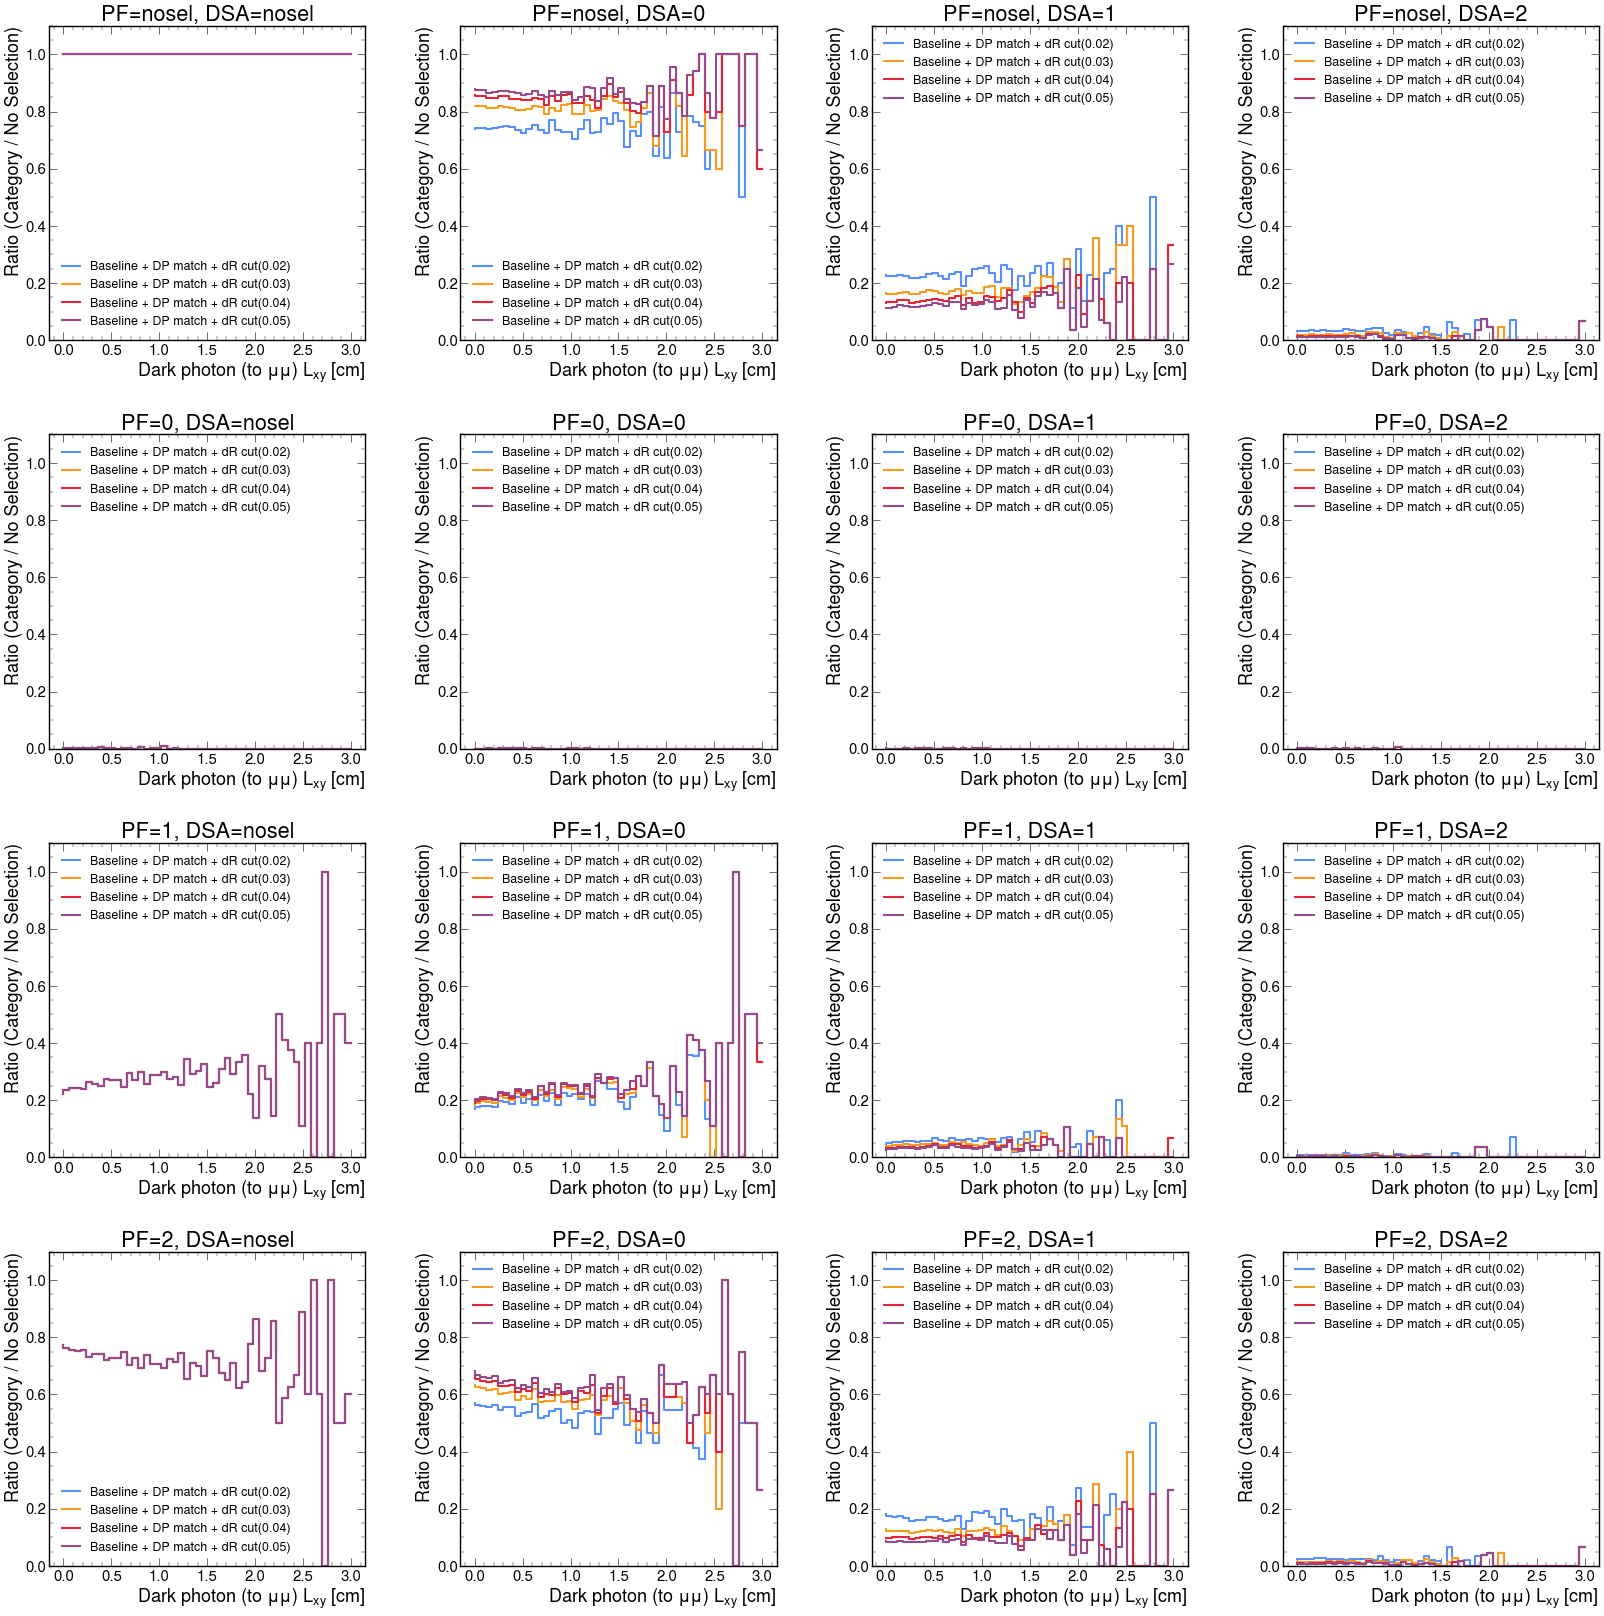

In [11]:
channels = ["baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"]
legends = ["Baseline + DP match + dR cut(0.02)", "Baseline + DP match + dR cut(0.03)", "Baseline + DP match + dR cut(0.04)", "Baseline + DP match + dR cut(0.05)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_basic", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_basic", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 1:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 12:
        ax.legend(loc='lower left', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

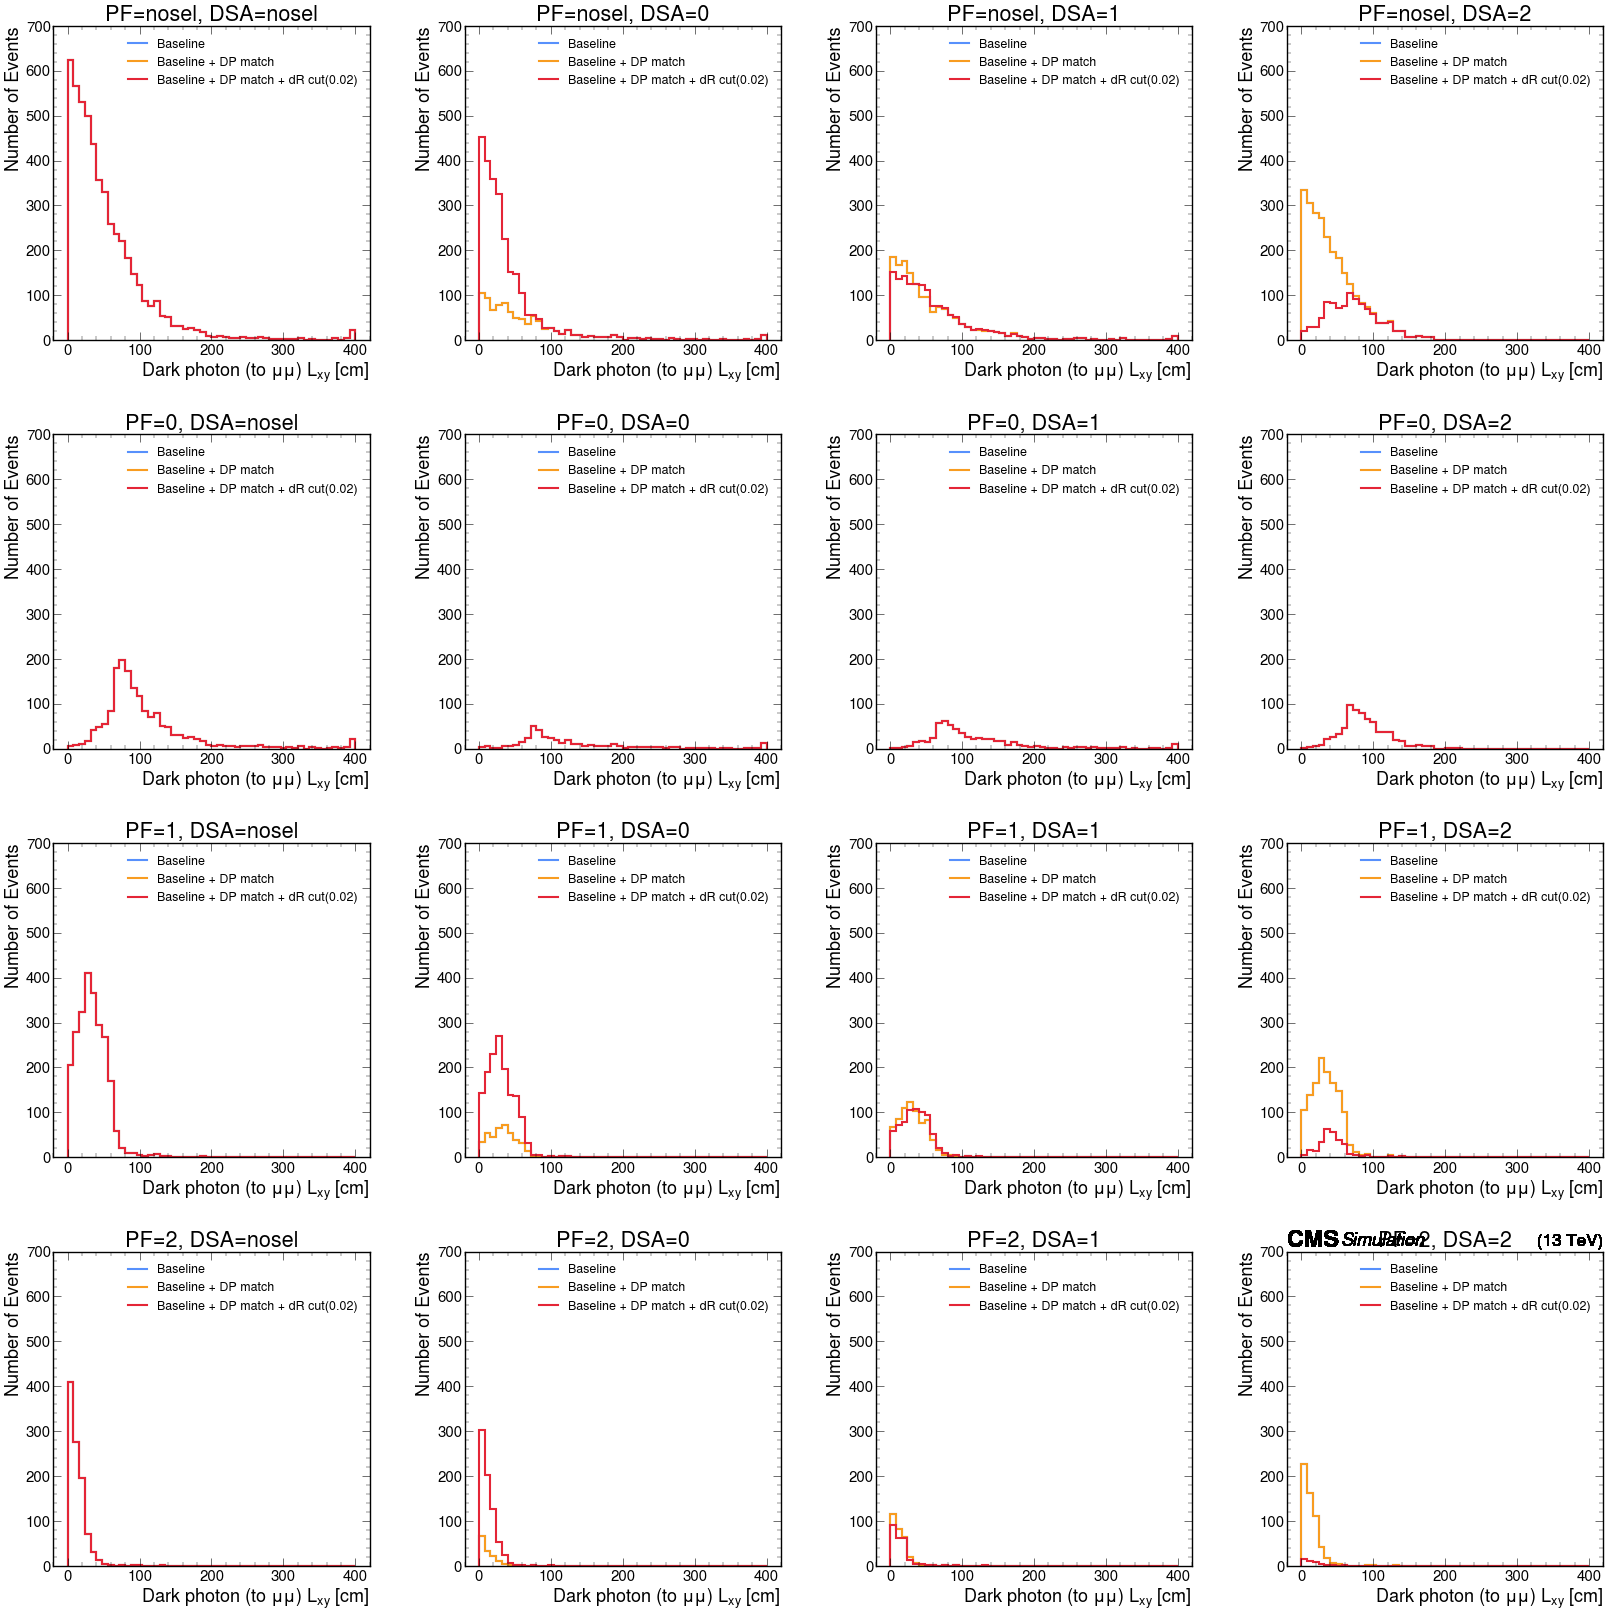

In [13]:
sample = "2Mu2E_1000GeV_0p25GeV_2p0mm"

channels = ["baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02"]
legends = ["Baseline", "Baseline + DP match", "Baseline + DP match + dR cut(0.02)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 700)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

/tmp/ipykernel_133/3285954696.py:21: RuntimeWarning: invalid value encountered in divide
  ratio_vals = numerator / denominator


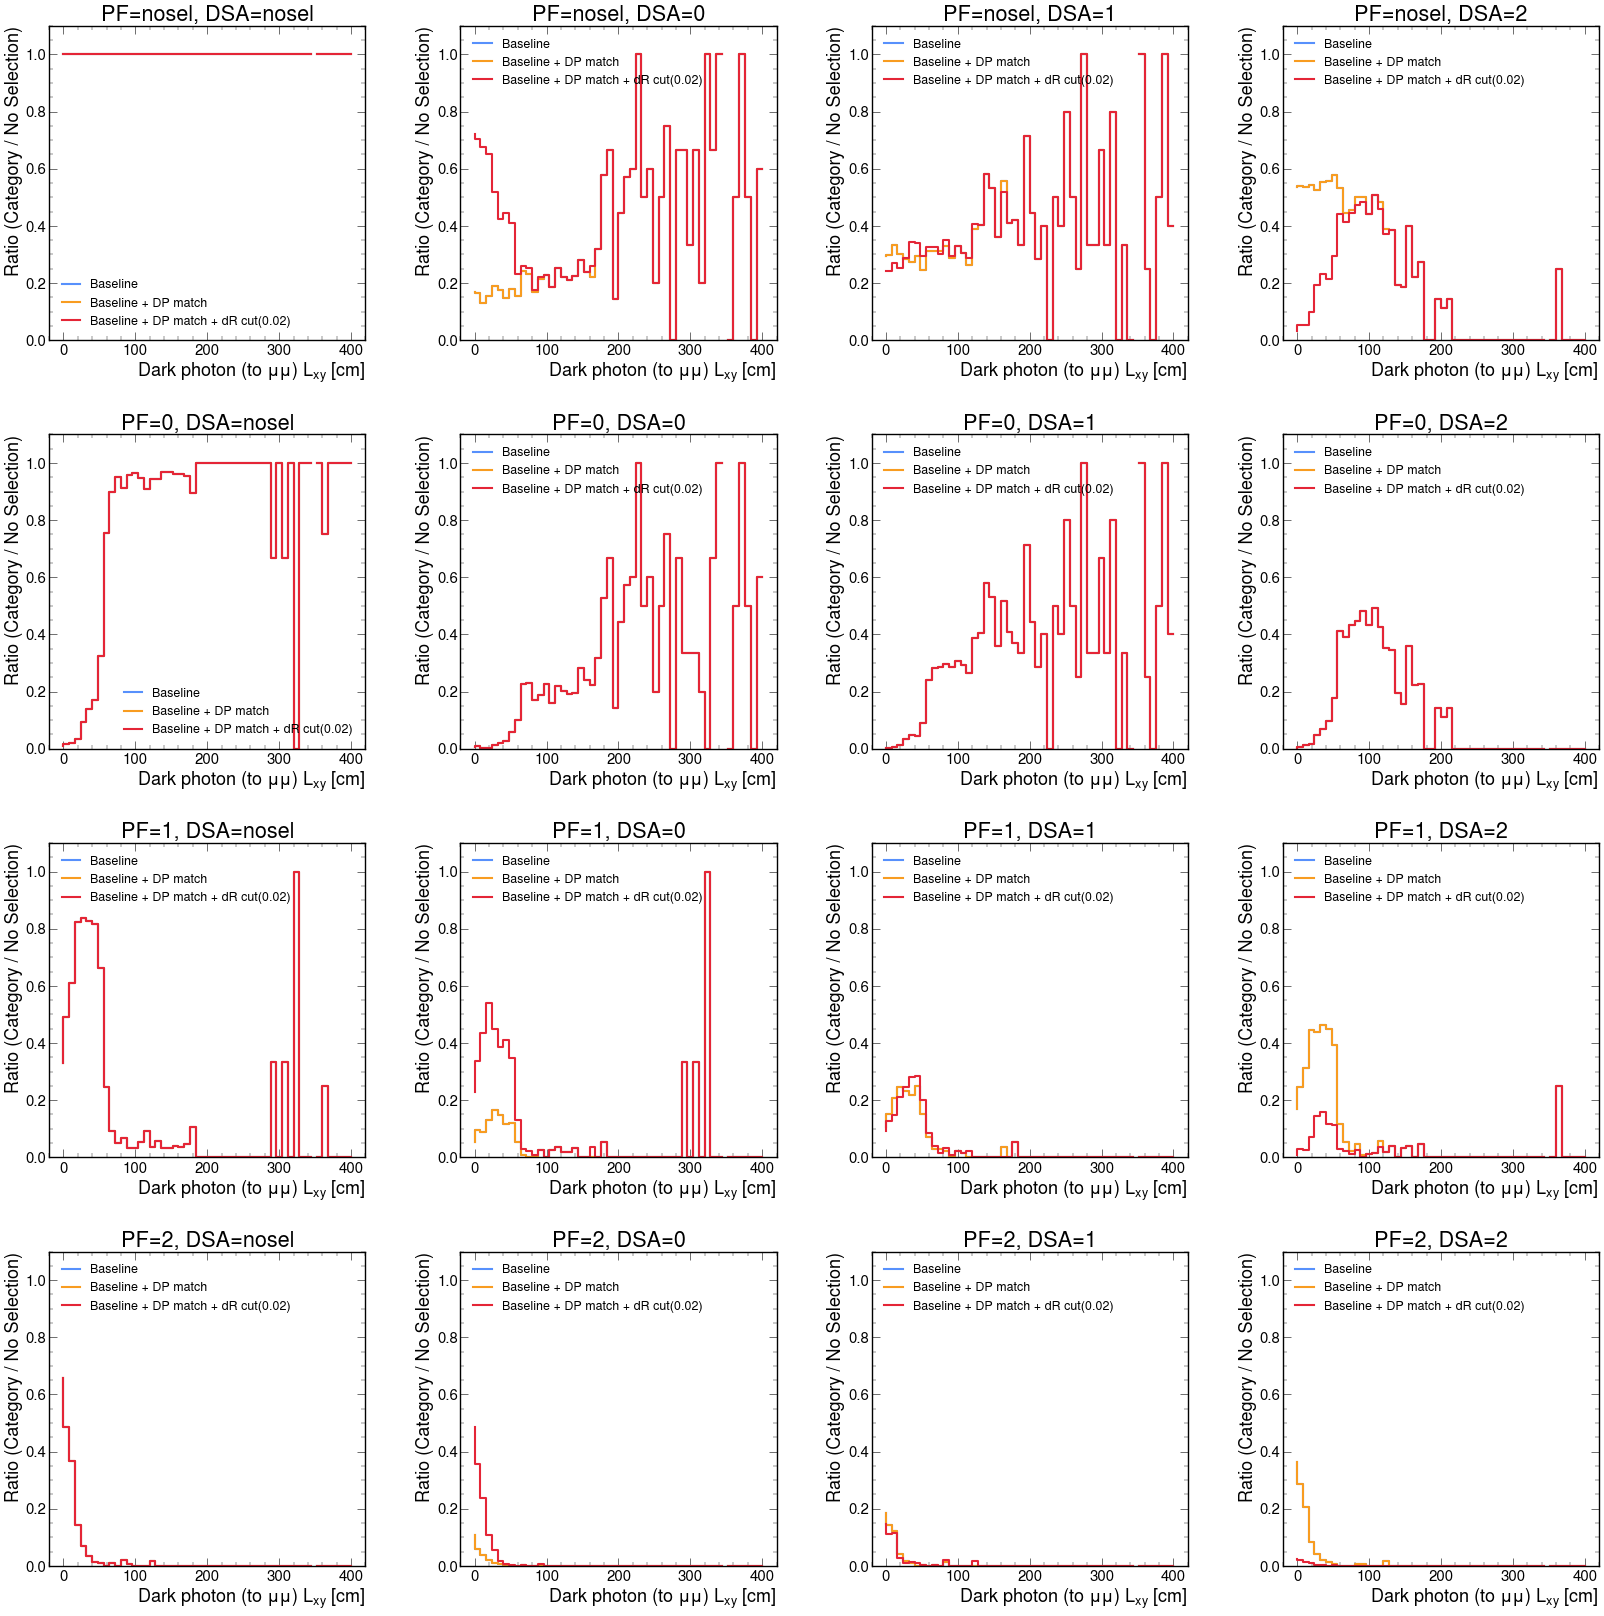

In [14]:
channels = ["baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02"]
legends = ["Baseline", "Baseline + DP match", "Baseline + DP match + dR cut(0.02)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_basic", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_basic", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 4:
        ax.legend(loc='lower right', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

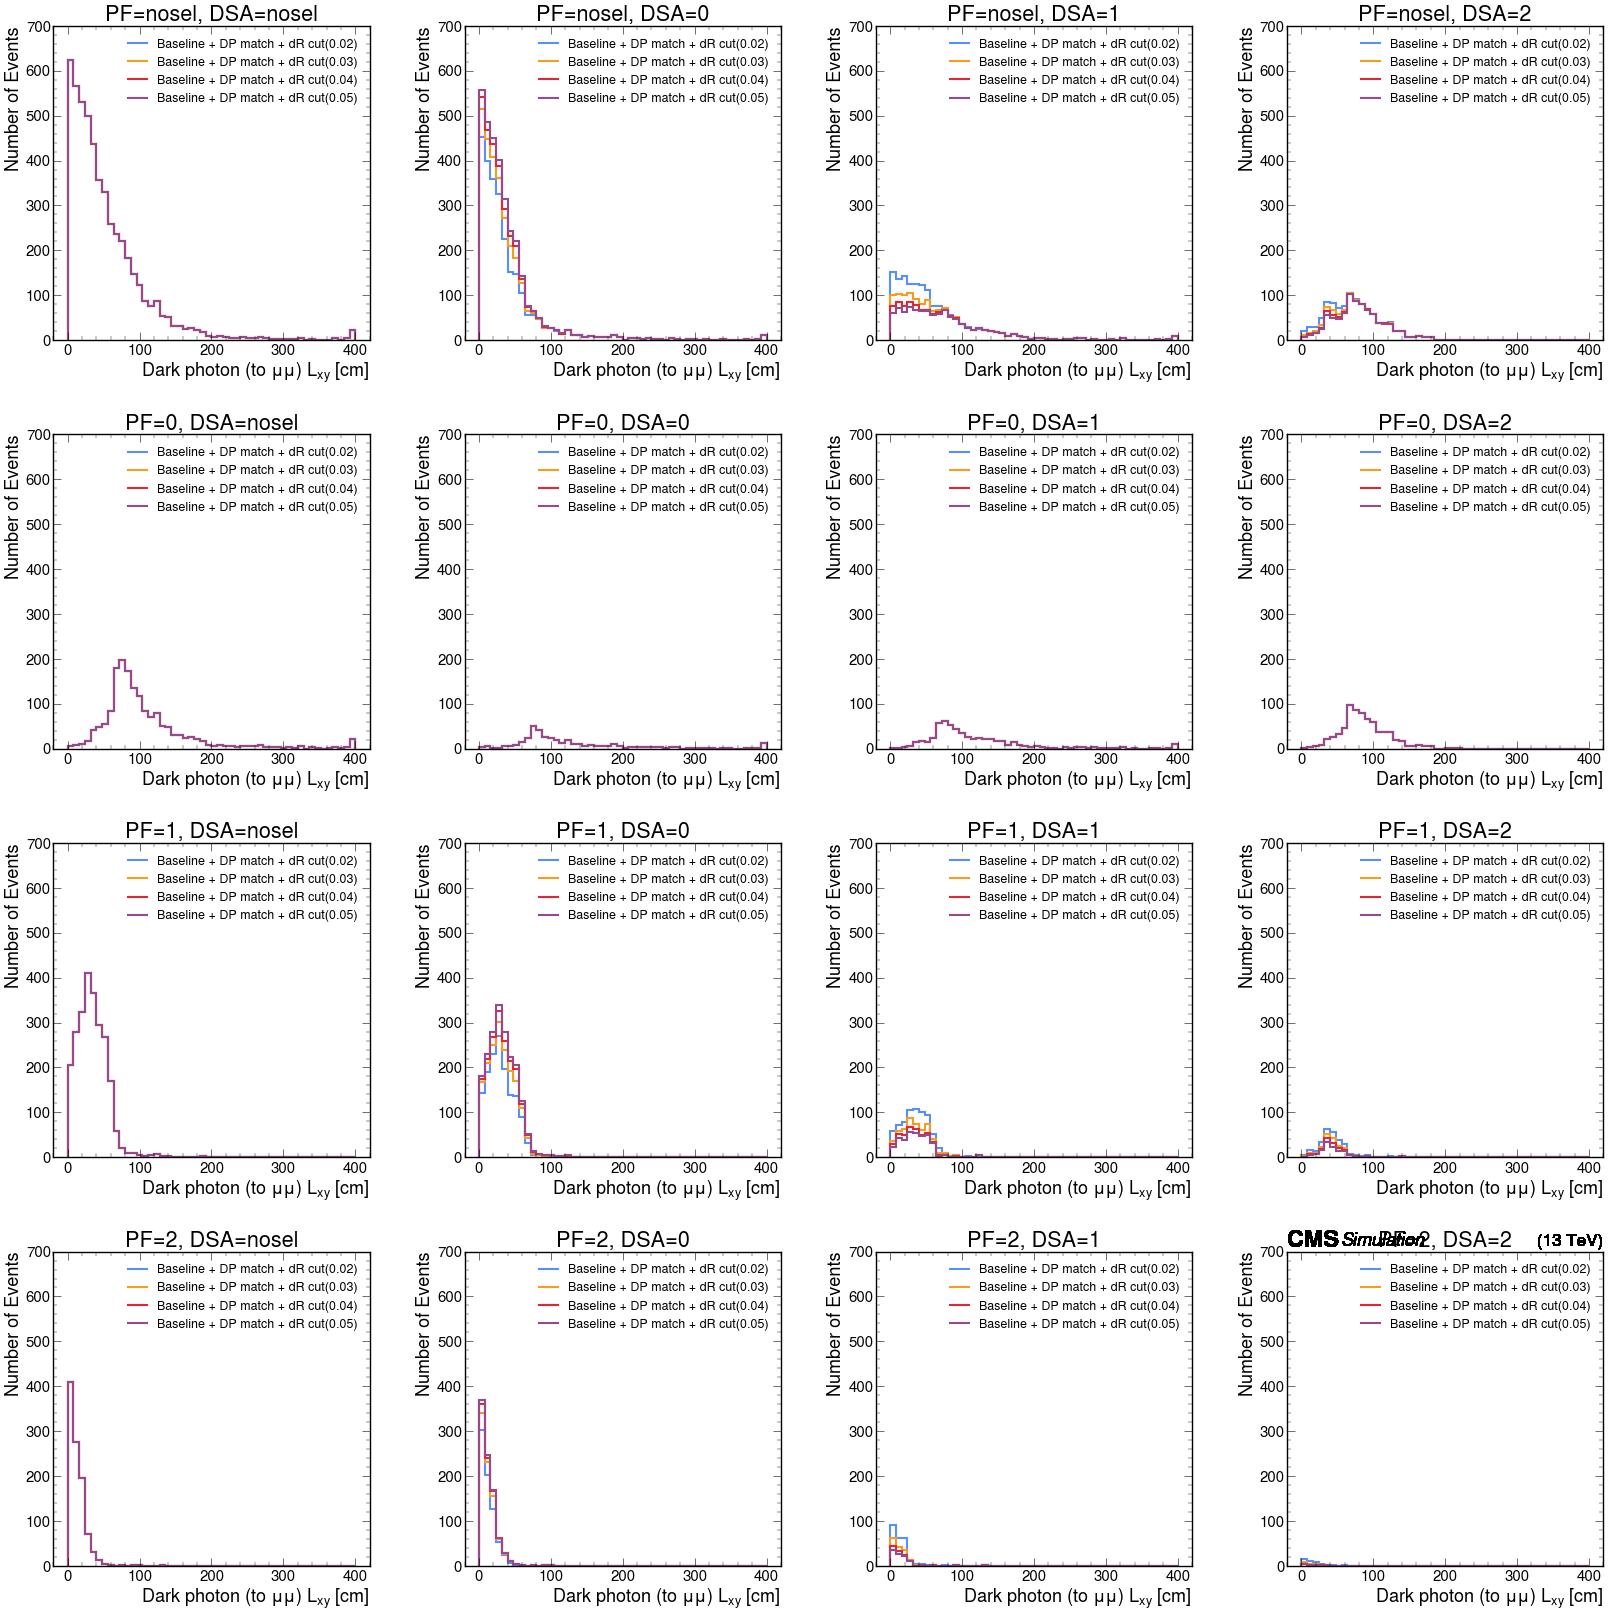

In [16]:
channels = ["baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"]
legends = ["Baseline + DP match + dR cut(0.02)", "Baseline + DP match + dR cut(0.03)", "Baseline + DP match + dR cut(0.04)", "Baseline + DP match + dR cut(0.05)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 700)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

/tmp/ipykernel_133/2277923315.py:21: RuntimeWarning: invalid value encountered in divide
  ratio_vals = numerator / denominator


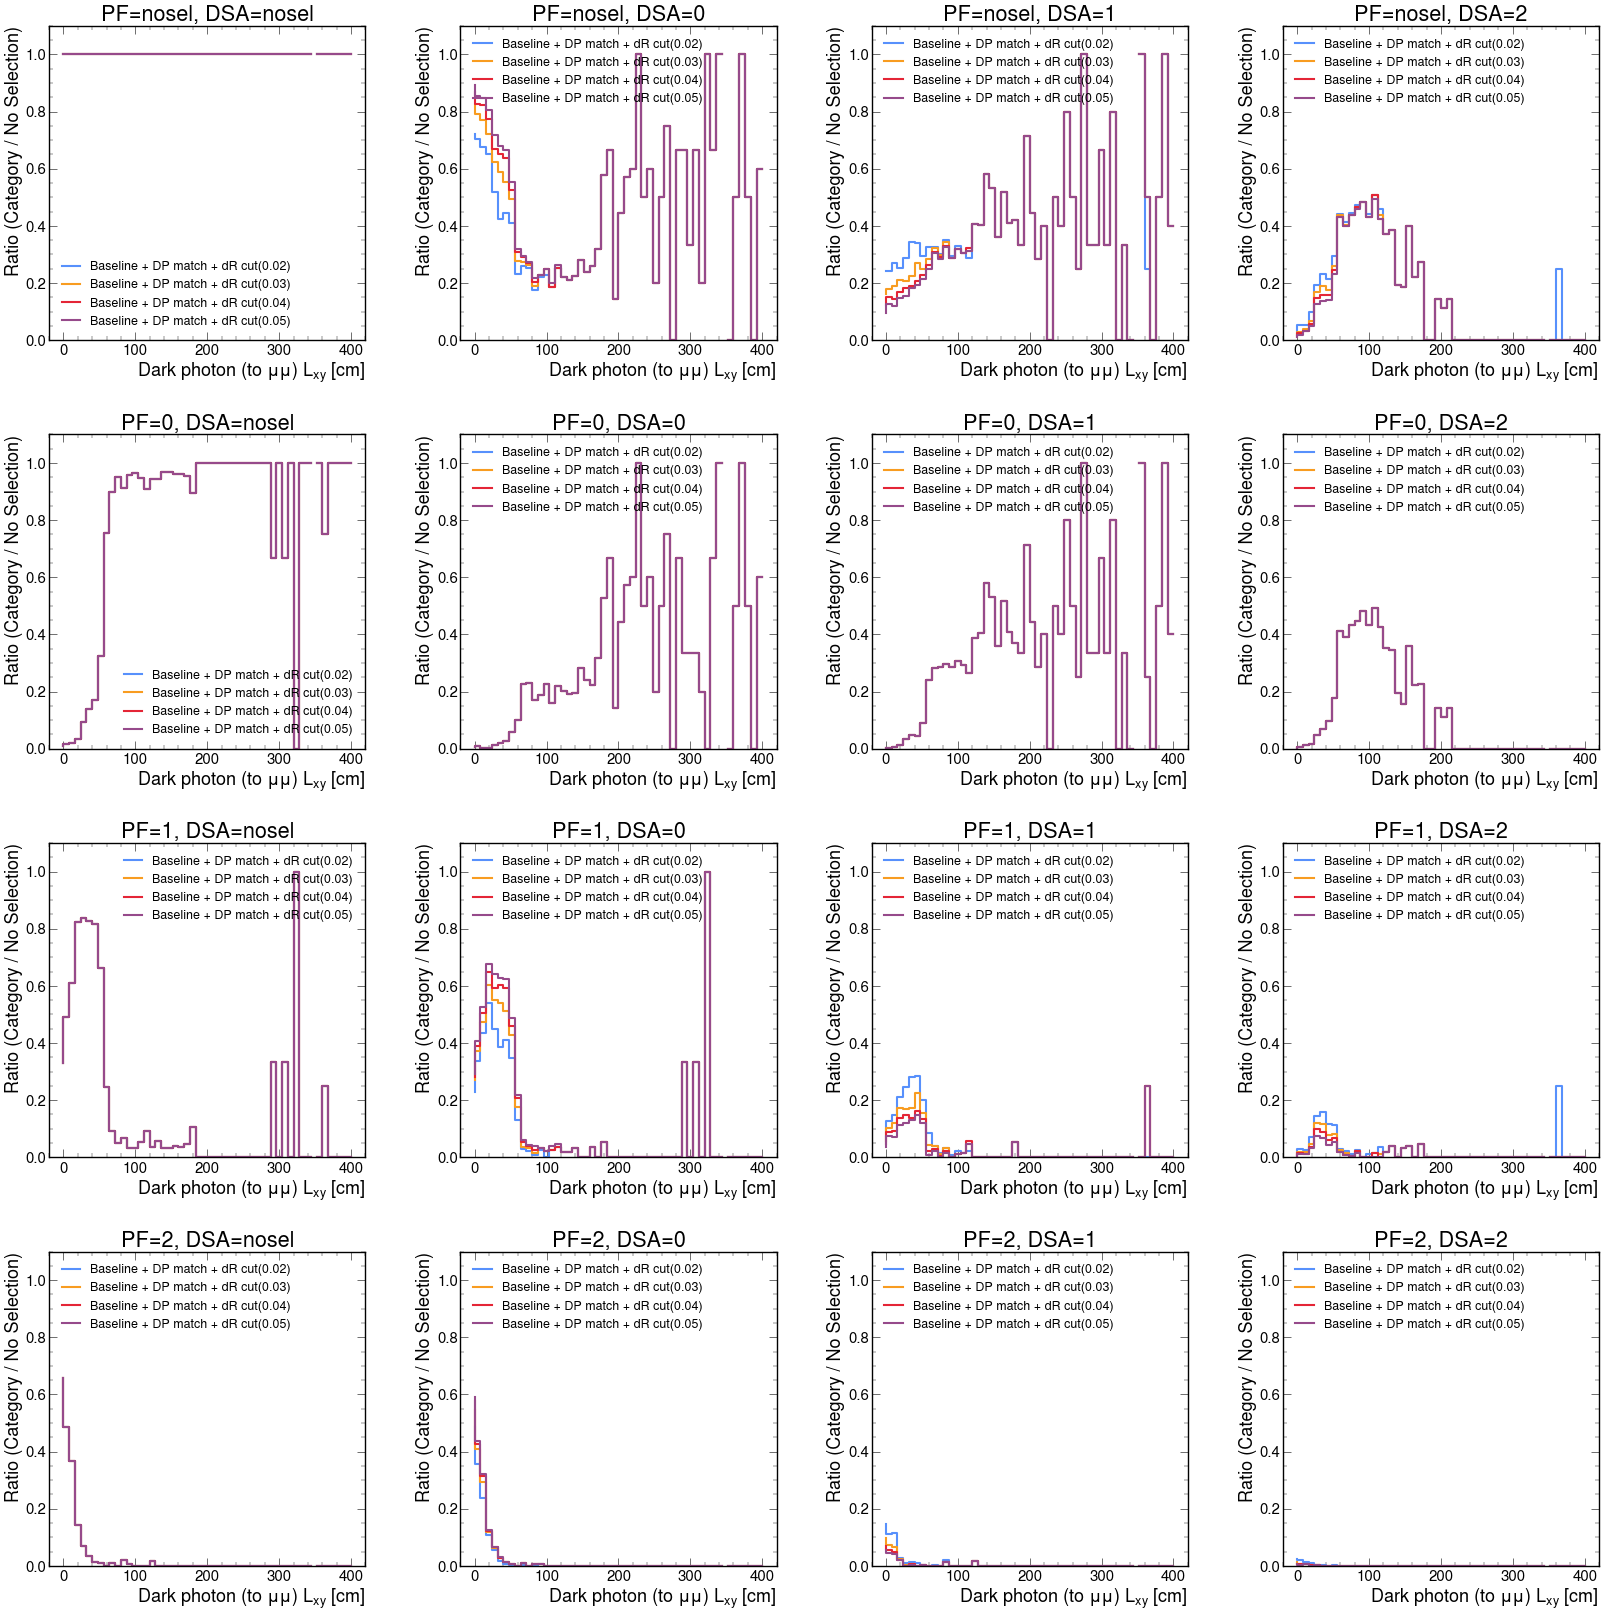

In [17]:
channels = ["baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"]
legends = ["Baseline + DP match + dR cut(0.02)", "Baseline + DP match + dR cut(0.03)", "Baseline + DP match + dR cut(0.04)", "Baseline + DP match + dR cut(0.05)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_basic", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_basic", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 4:
        ax.legend(loc='lower right', fontsize=18)
    elif i == 8:
        ax.legend(loc='upper right', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


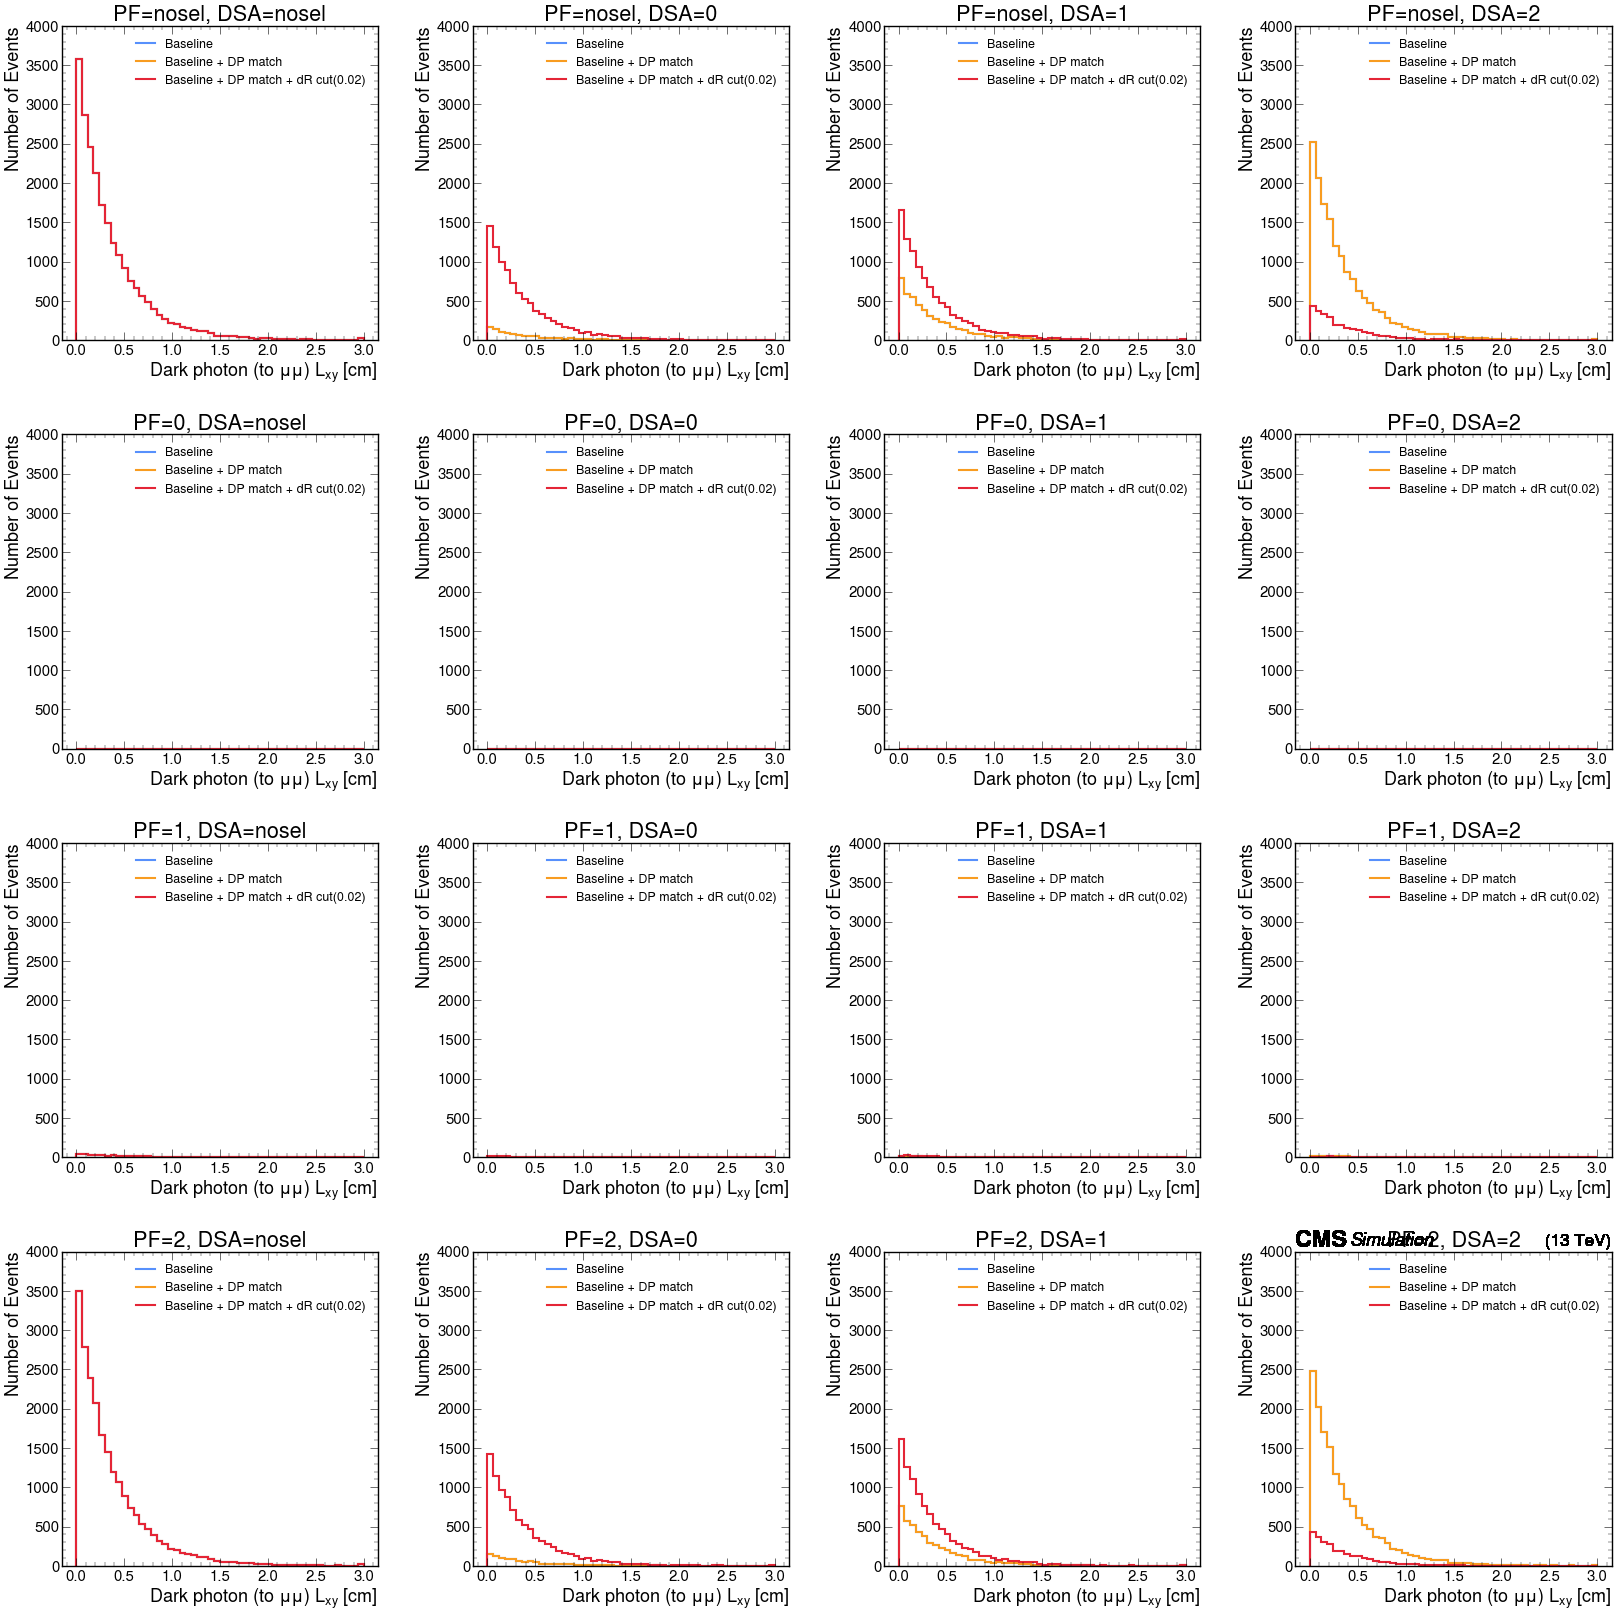

In [18]:
sample = "2Mu2E_200GeV_5p0GeV_0p2mm"

channels = ["baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02"]
legends = ["Baseline", "Baseline + DP match", "Baseline + DP match + dR cut(0.02)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 4000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

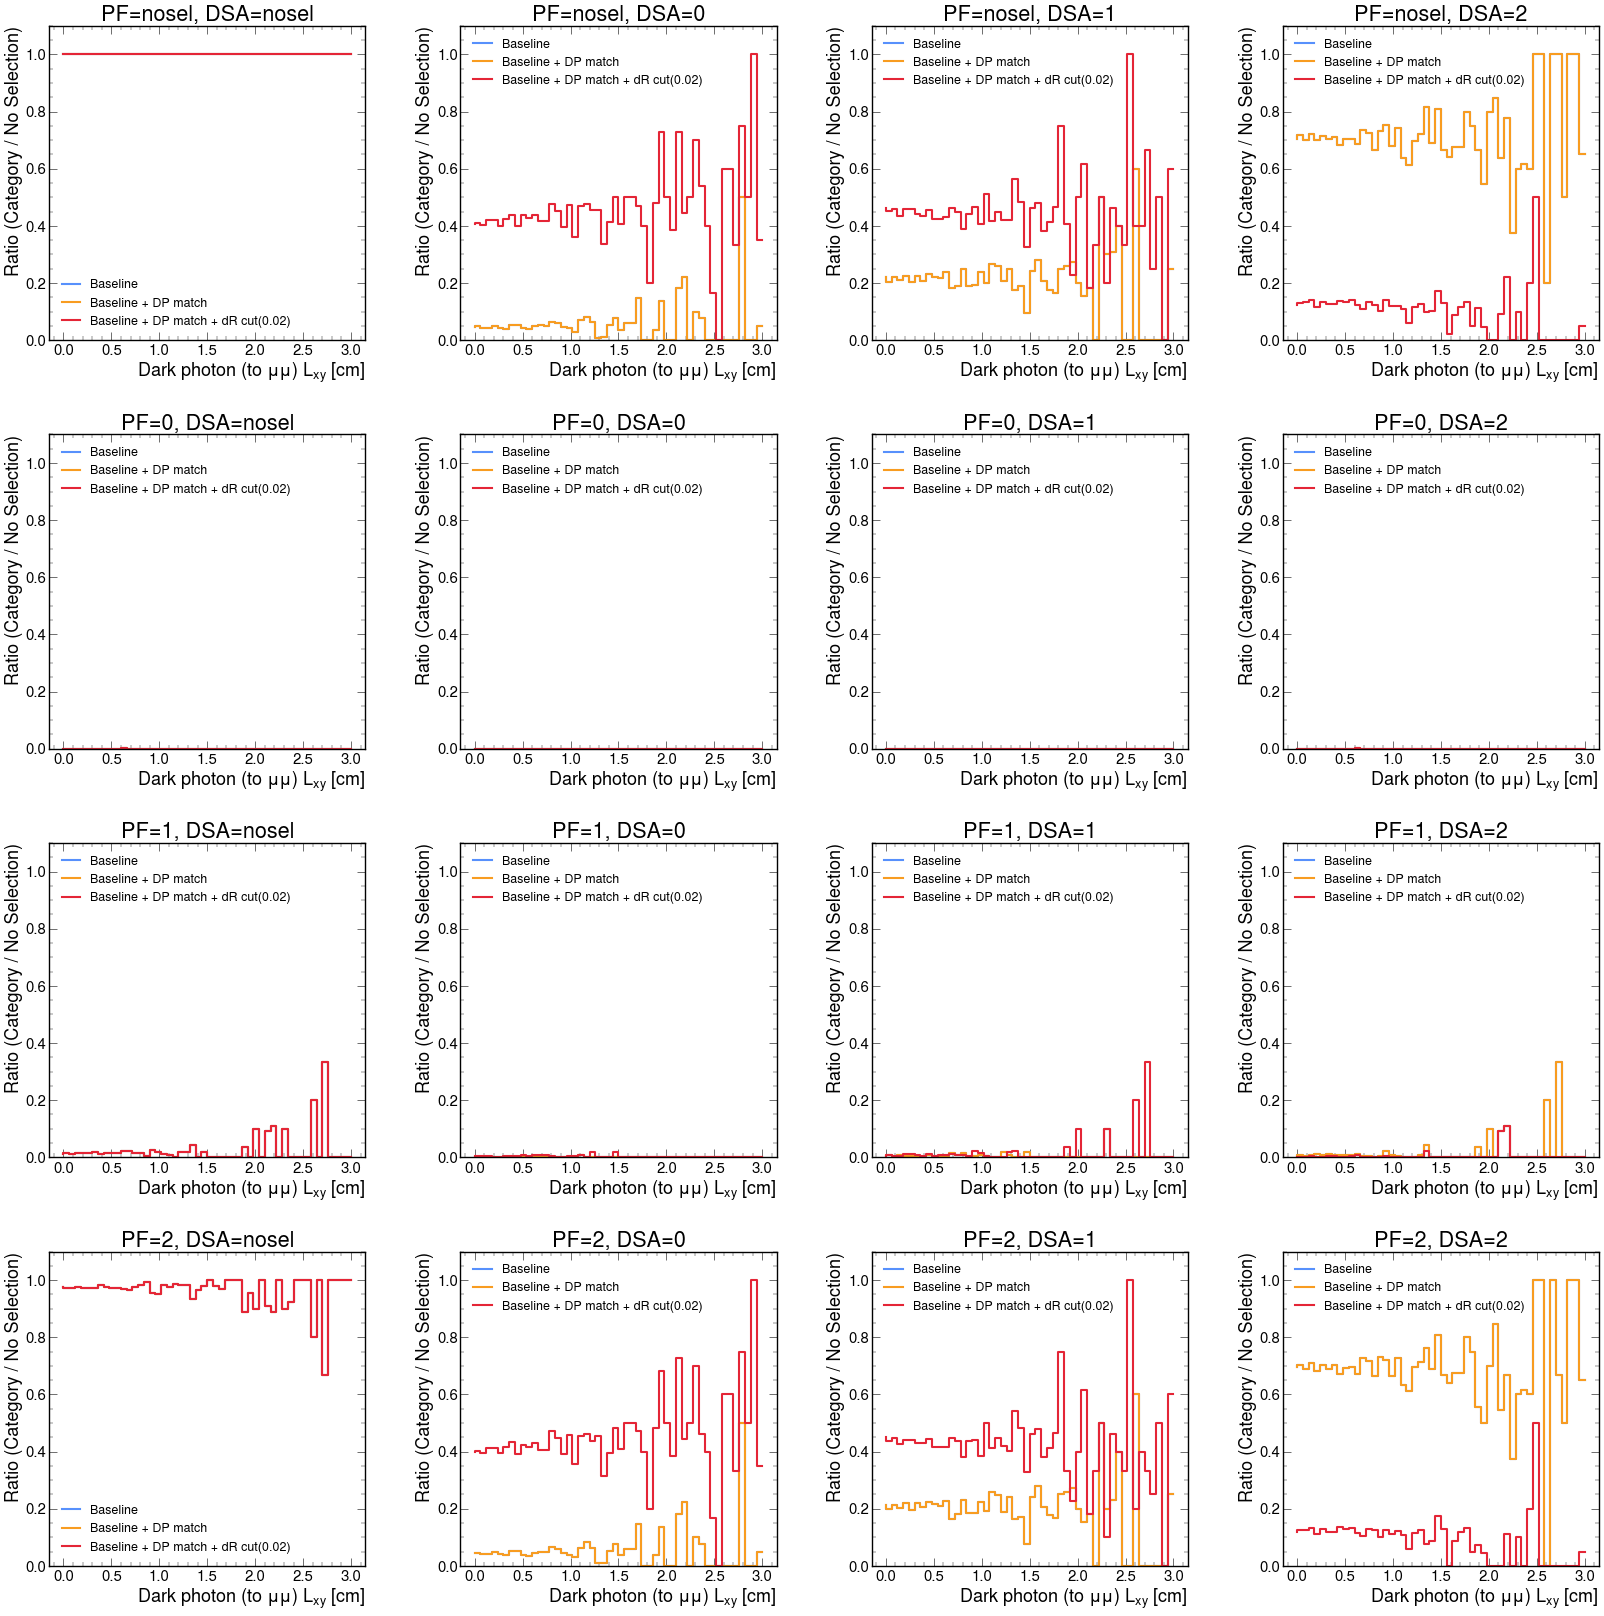

In [22]:
channels = ["baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02"]
legends = ["Baseline", "Baseline + DP match", "Baseline + DP match + dR cut(0.02)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_basic", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_basic", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 12:
        ax.legend(loc='lower left', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/usr/local/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


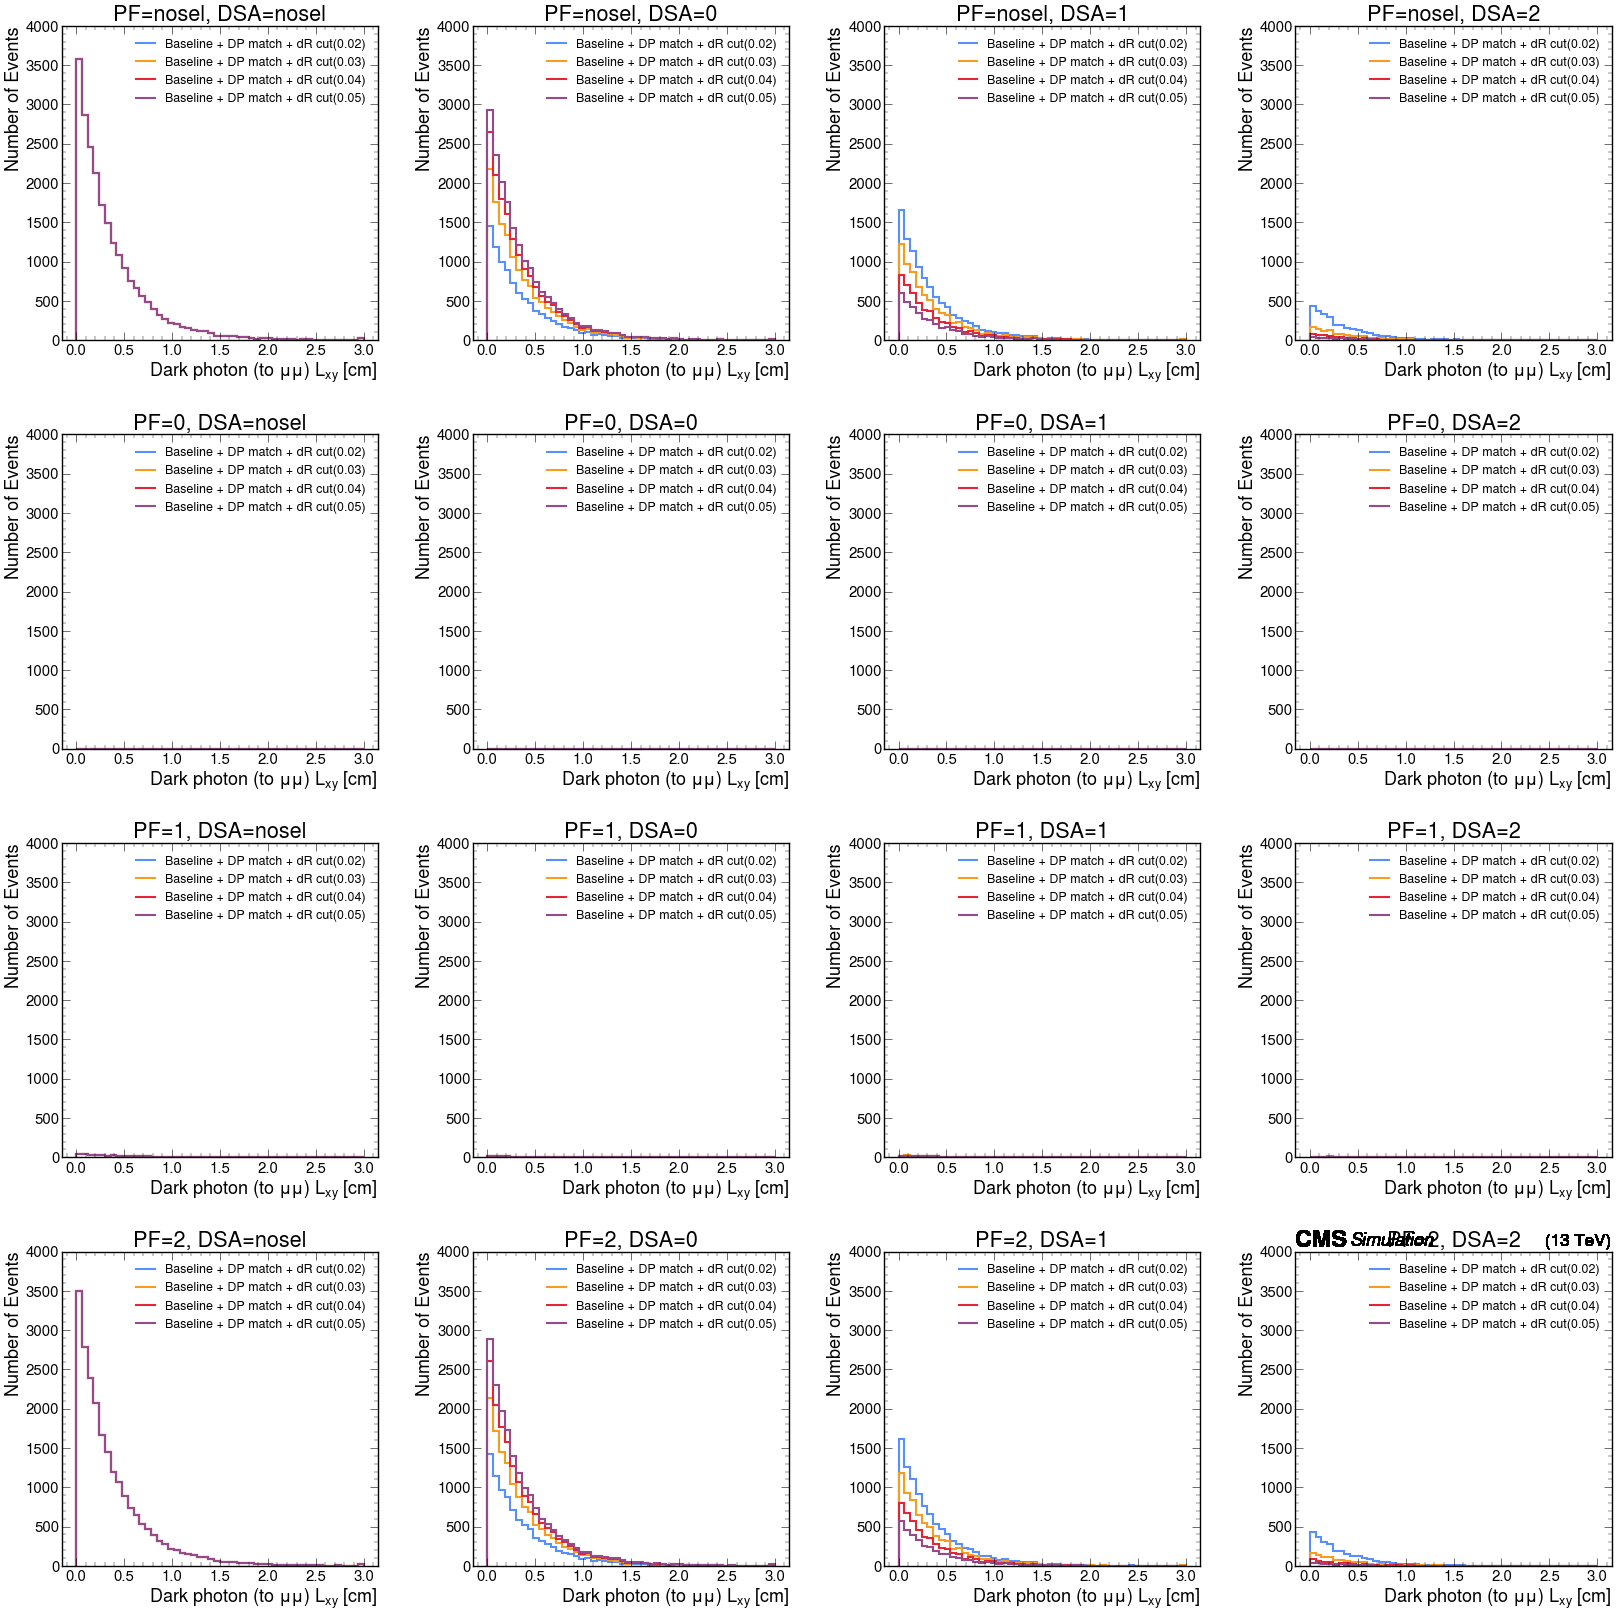

In [23]:
channels = ["baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"]
legends = ["Baseline + DP match + dR cut(0.02)", "Baseline + DP match + dR cut(0.03)", "Baseline + DP match + dR cut(0.04)", "Baseline + DP match + dR cut(0.05)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 4000)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    ax.legend(loc='upper right', fontsize=18)

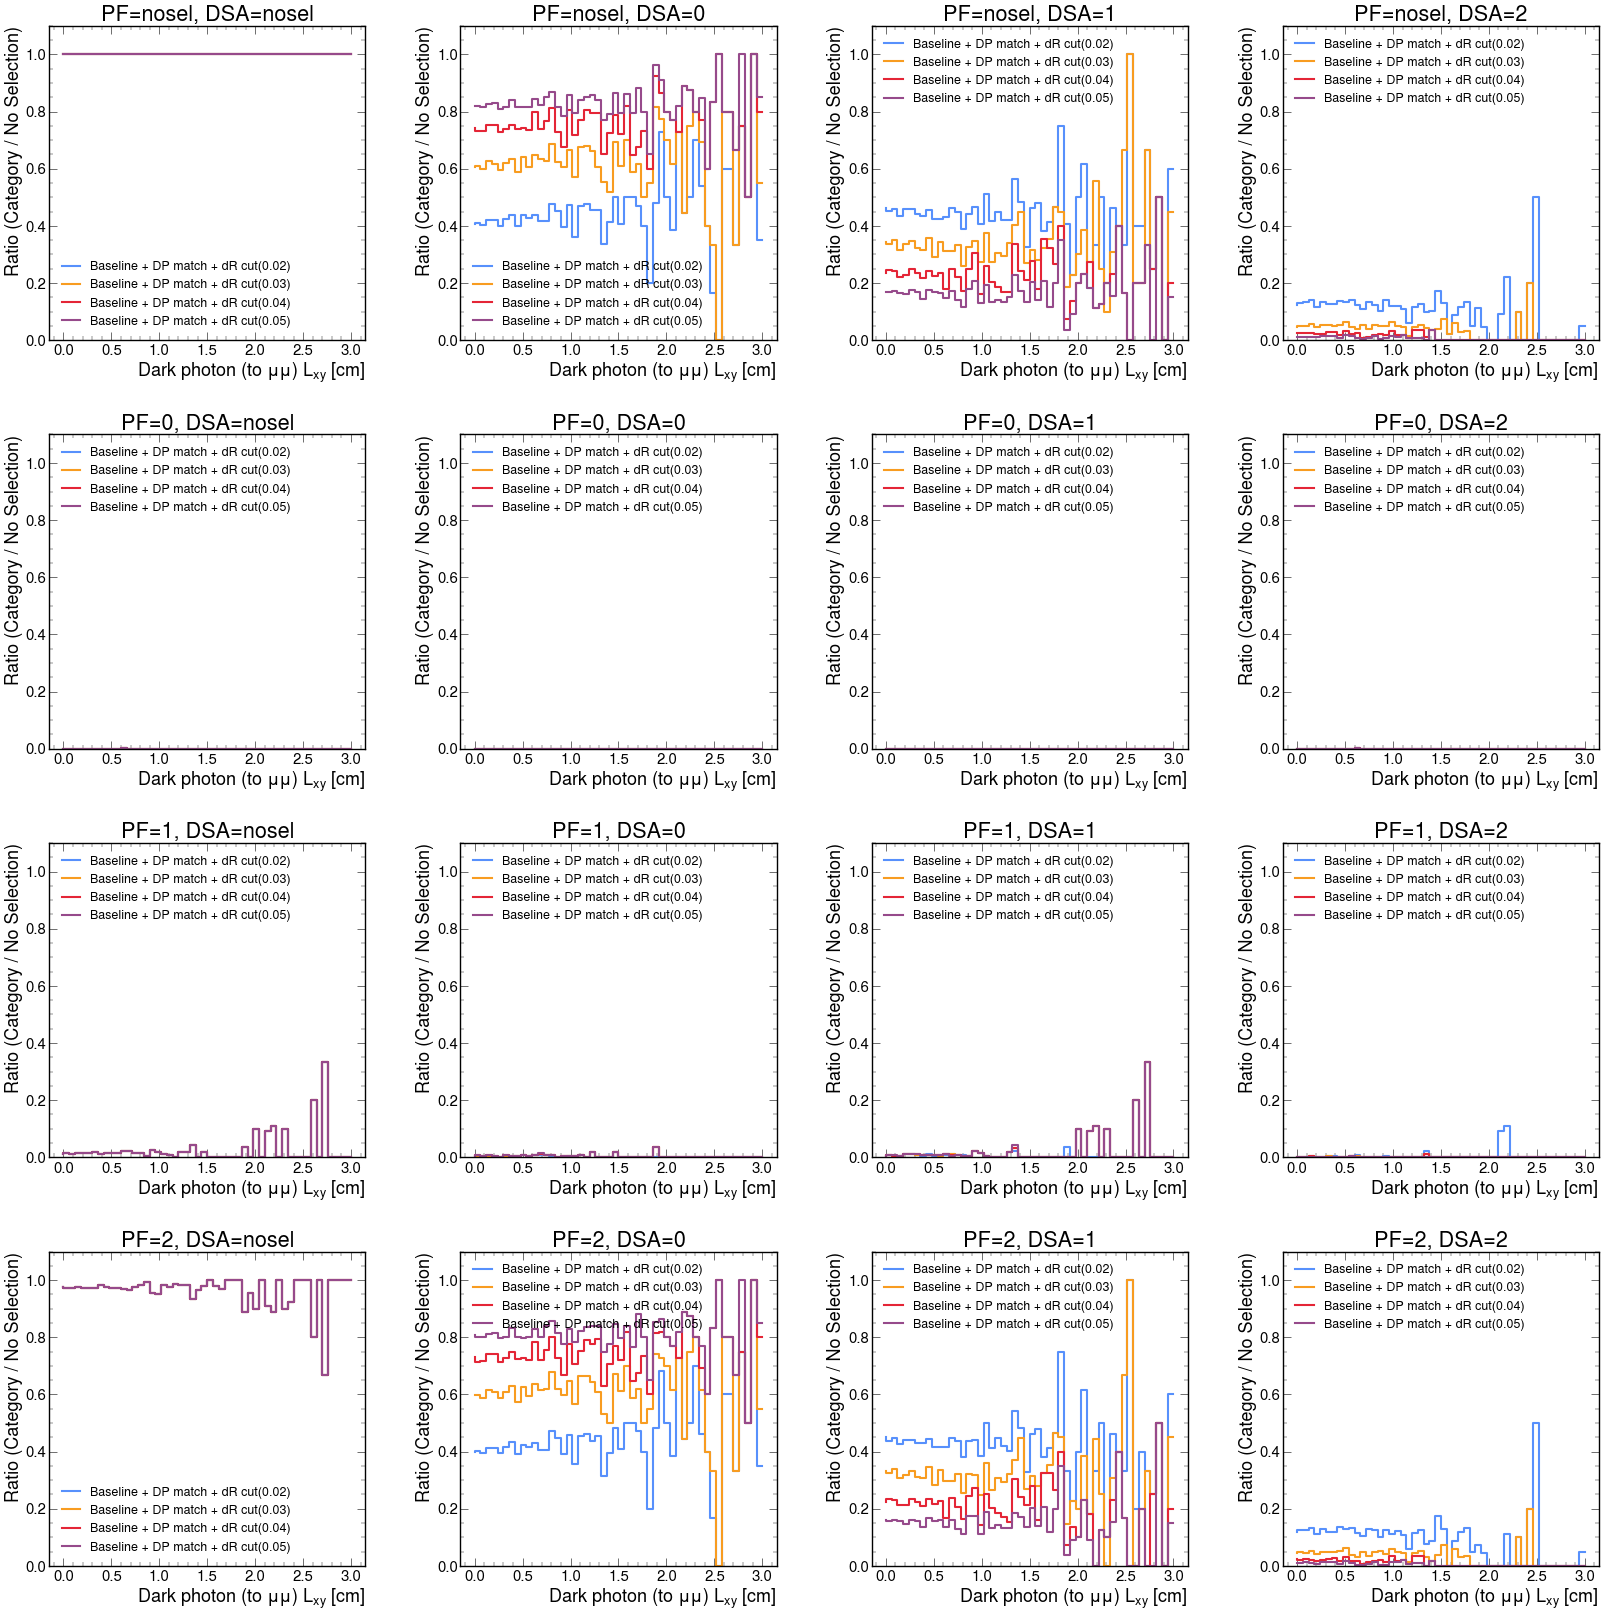

In [19]:
channels = ["baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"]
legends = ["Baseline + DP match + dR cut(0.02)", "Baseline + DP match + dR cut(0.03)", "Baseline + DP match + dR cut(0.04)", "Baseline + DP match + dR cut(0.05)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_basic", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel"]["baseNoLj_basic", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 1:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 12:
        ax.legend(loc='lower left', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

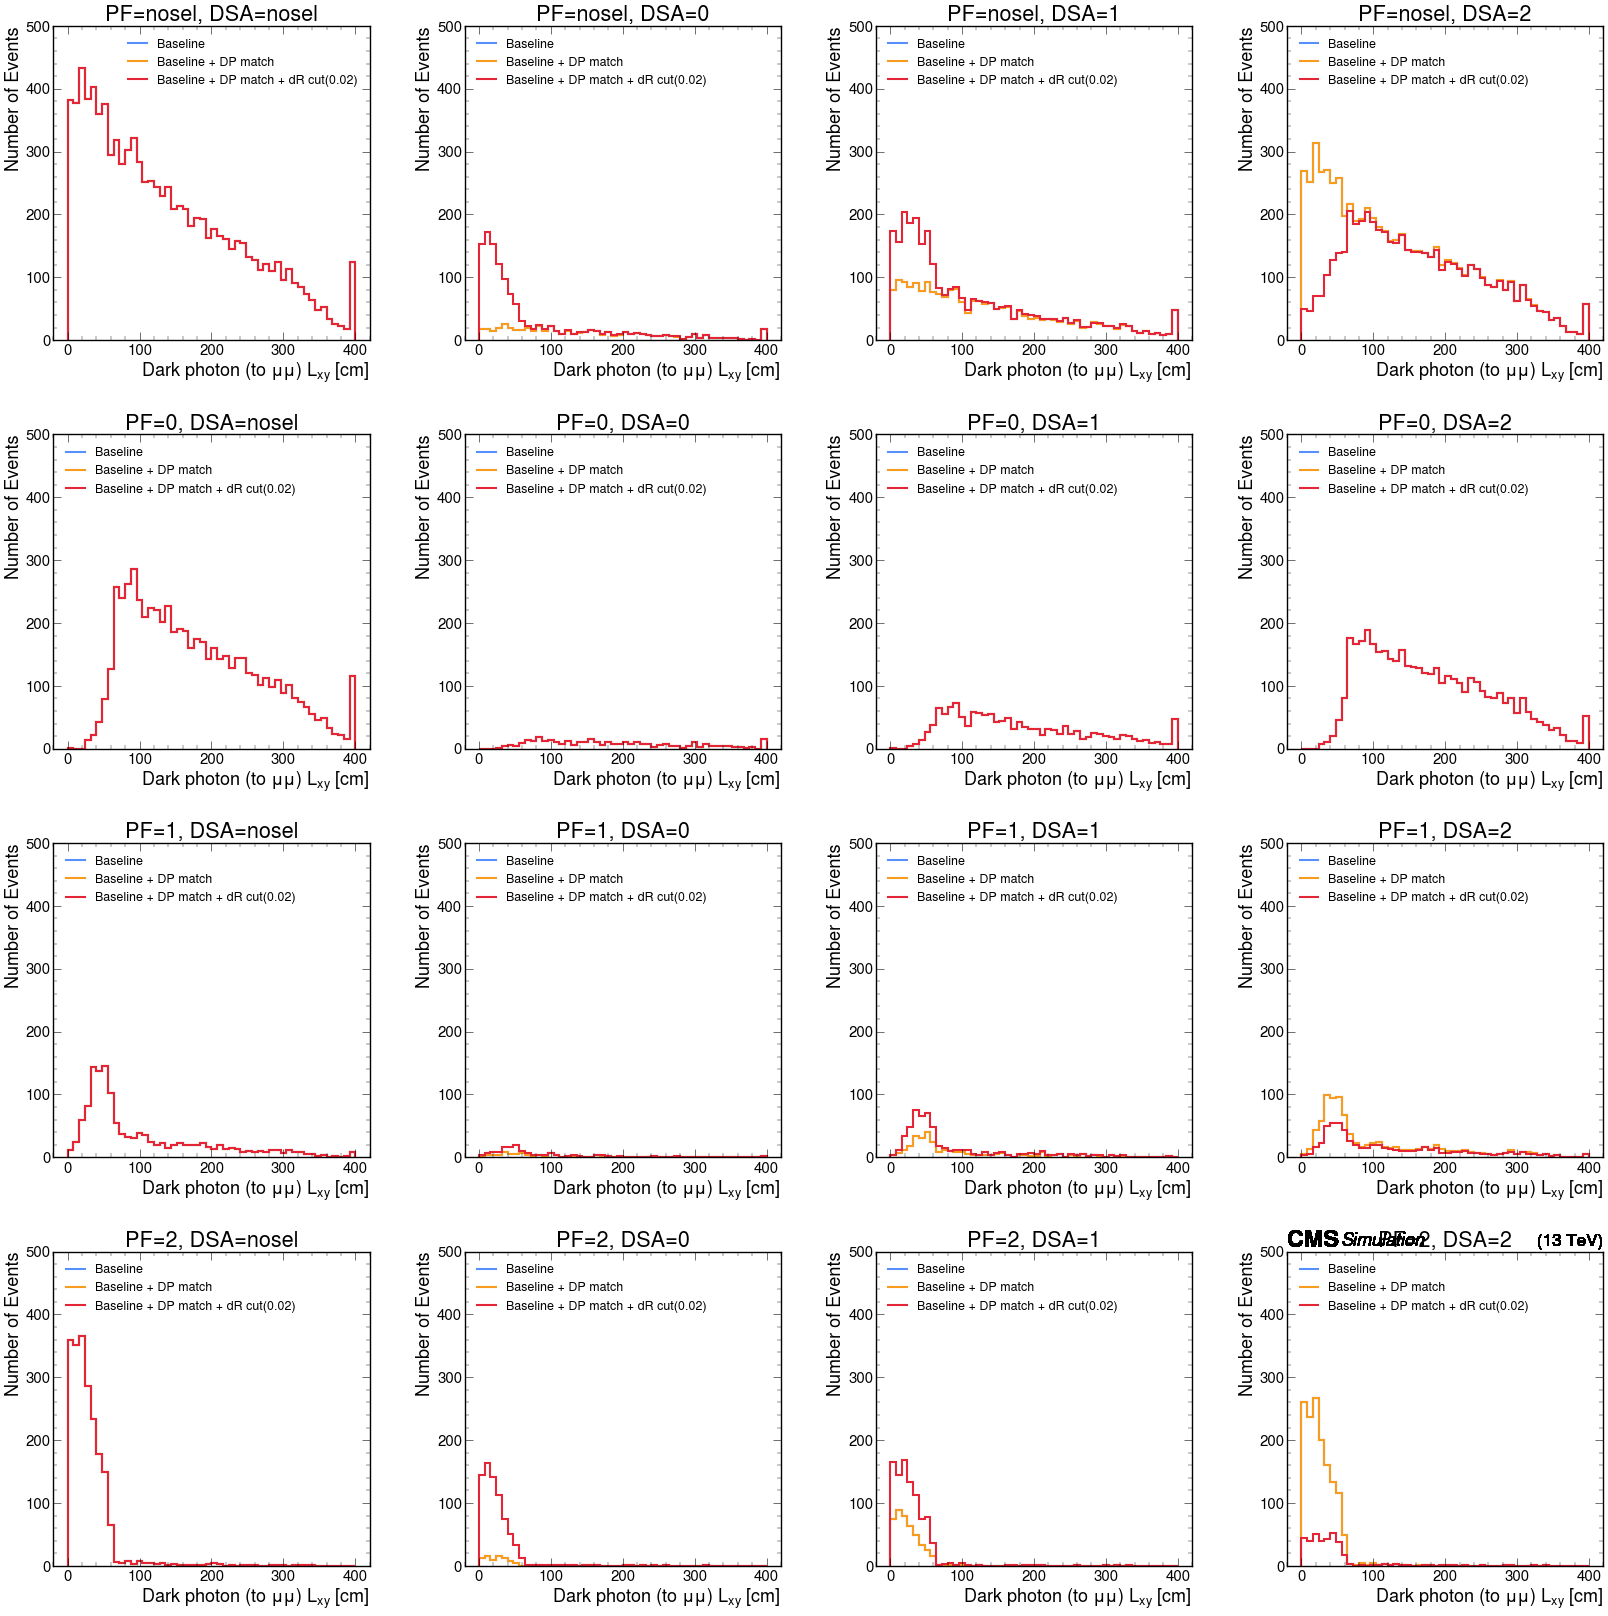

In [21]:
sample = "2Mu2E_200GeV_5p0GeV_200p0mm"

channels = ["baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02"]
legends = ["Baseline", "Baseline + DP match", "Baseline + DP match + dR cut(0.02)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 500)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='upper right', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

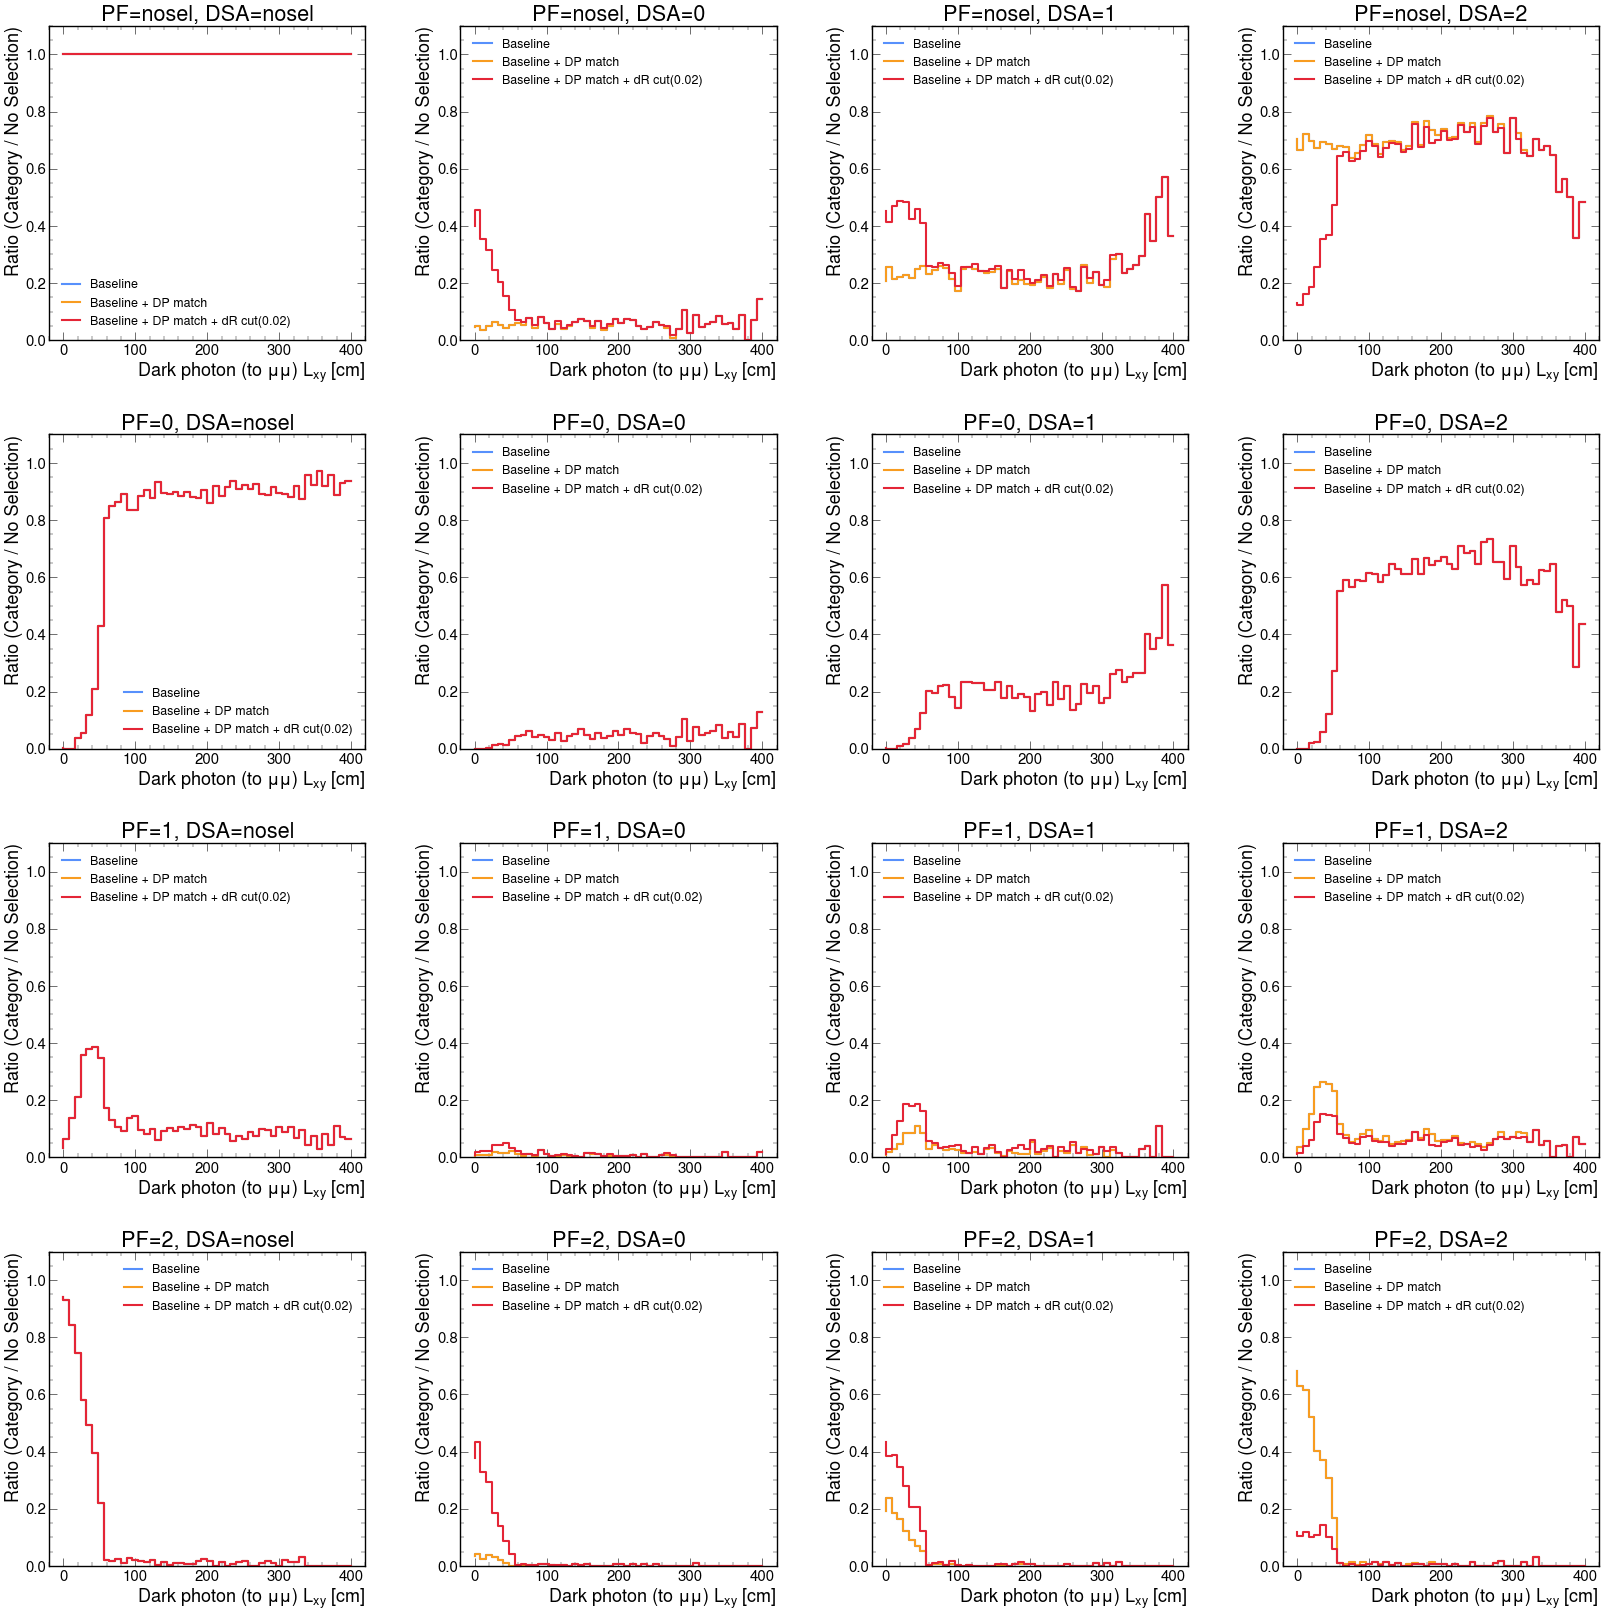

In [22]:
channels = ["baseNoLj_basic", "baseNoLj_DP_matching", "baseNoLj_DP_matching_dR0p02"]
legends = ["Baseline", "Baseline + DP match", "Baseline + DP match + dR cut(0.02)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_basic", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_basic", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 4:
        ax.legend(loc='lower right', fontsize=18)
    elif i == 12:
        ax.legend(loc='upper right', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

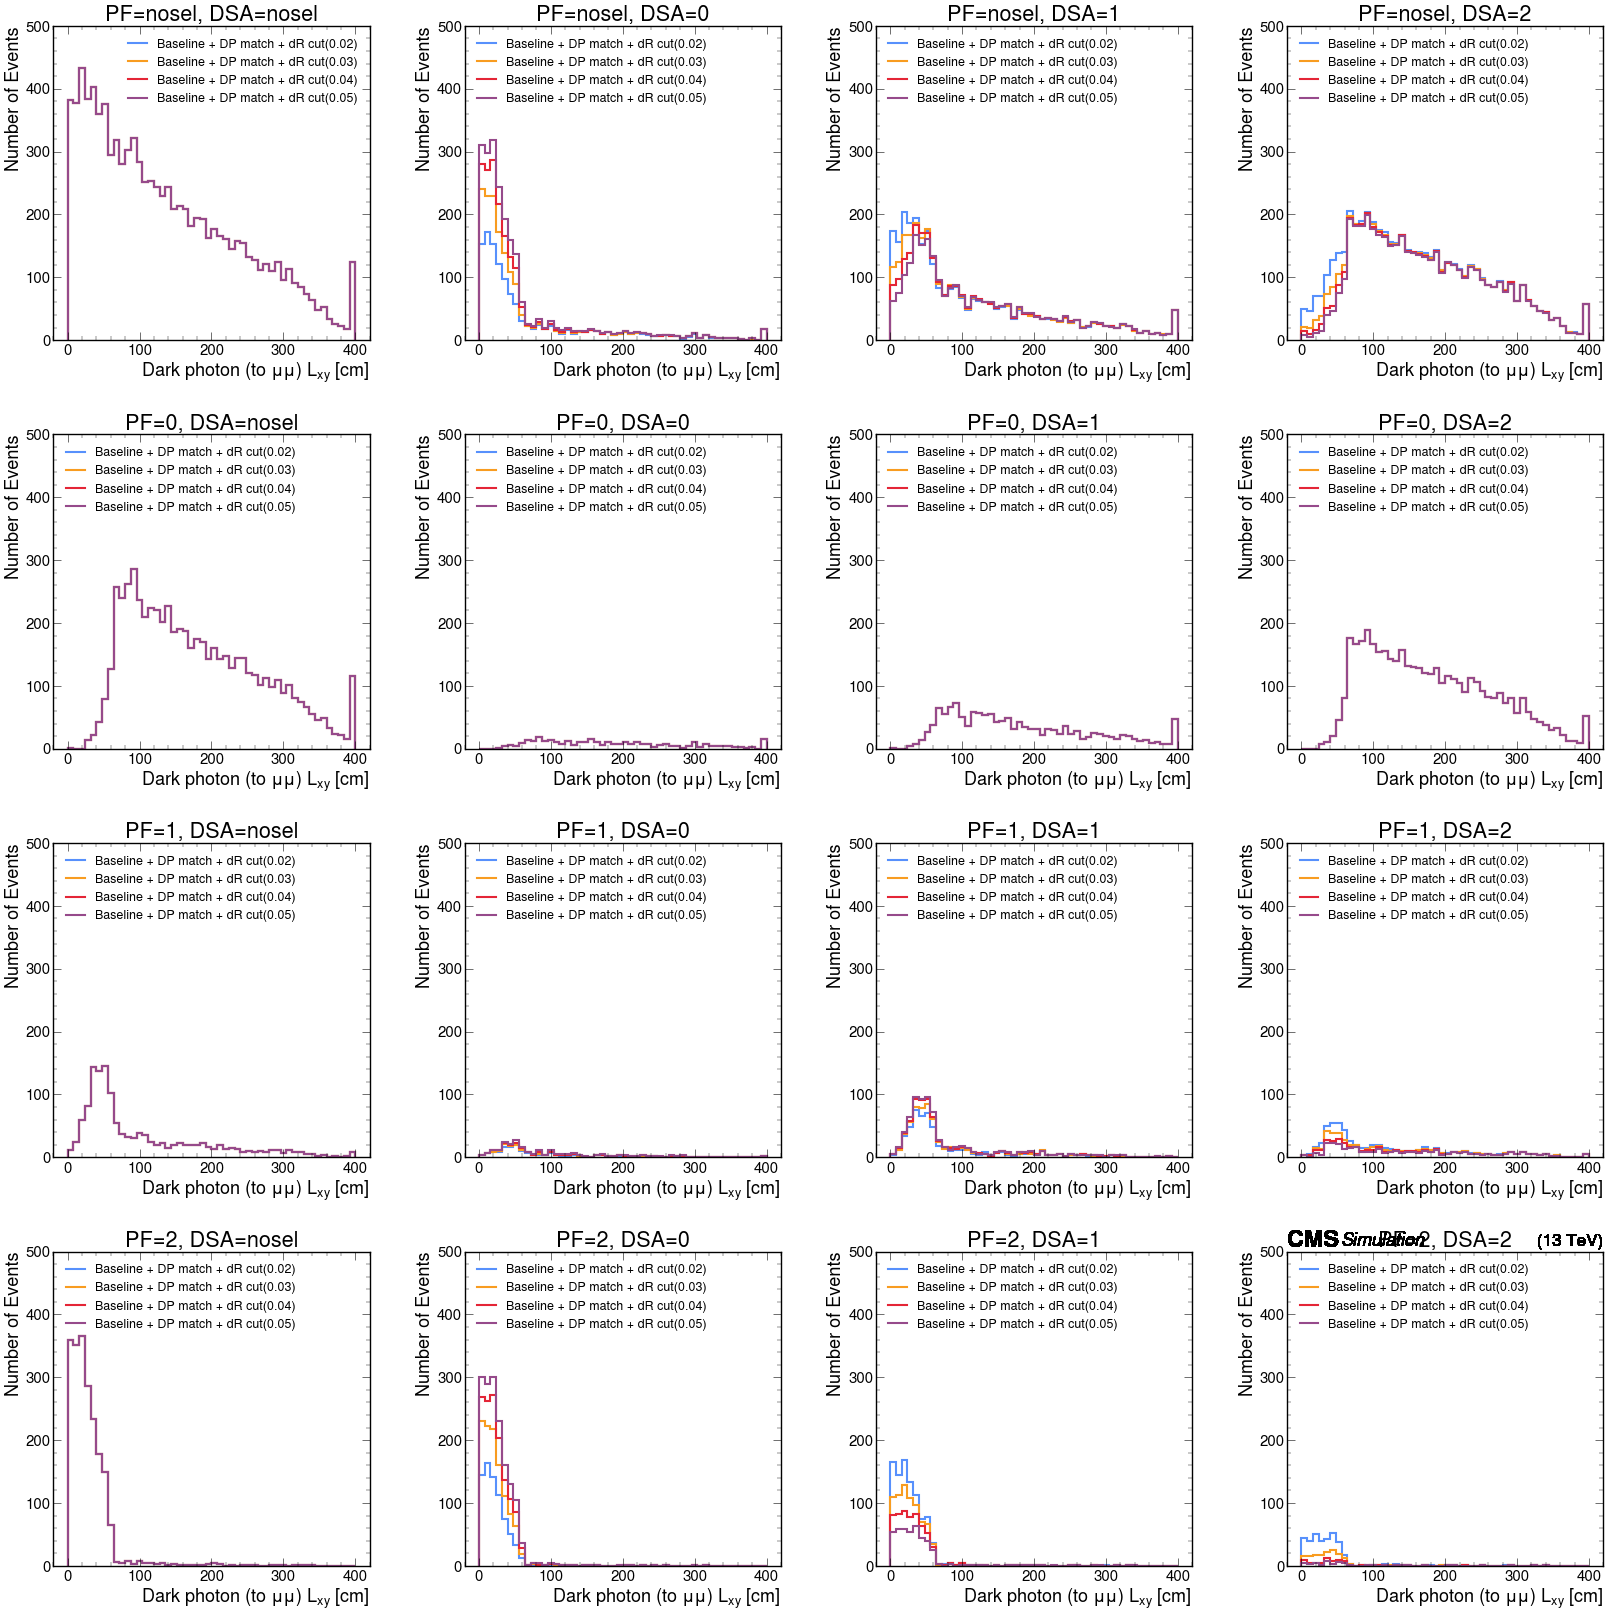

In [24]:
channels = ["baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"]
legends = ["Baseline + DP match + dR cut(0.02)", "Baseline + DP match + dR cut(0.03)", "Baseline + DP match + dR cut(0.04)", "Baseline + DP match + dR cut(0.05)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            utilities.plot(hist, ax=ax, yerr=False, density=False, linewidth=3, label=legends[idx])
            ax.set_title(histtitle[i])
            ax.set_ylim(0, 500)
            ax.set_ylabel("Number of Events")

        except Exception as e:
            ax.text(0.5, 0.5, "No Event", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='upper right', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

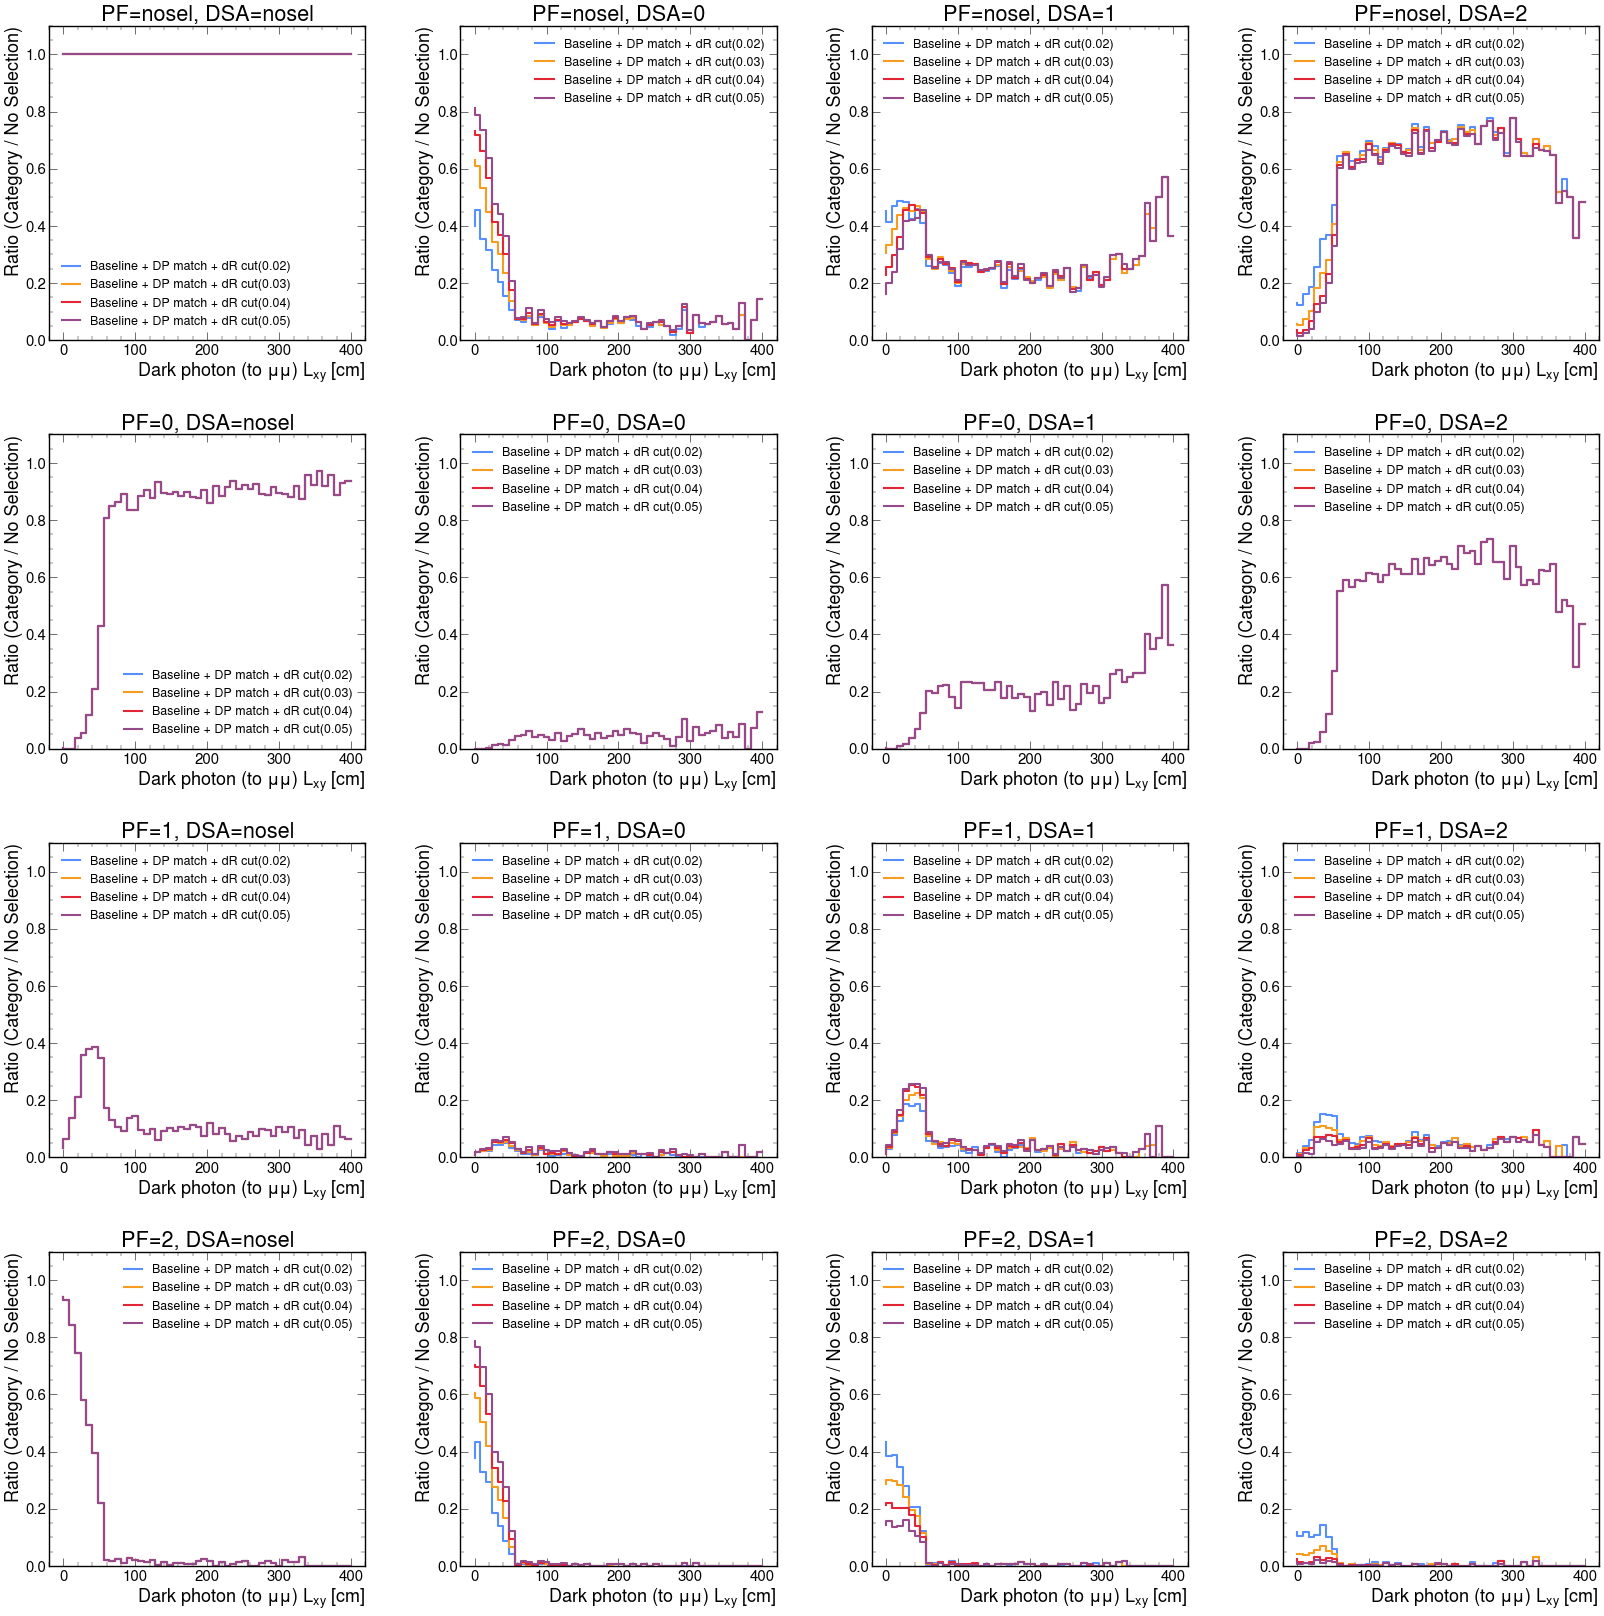

In [26]:
channels = ["baseNoLj_DP_matching_dR0p02", "baseNoLj_DP_matching_dR0p03", "baseNoLj_DP_matching_dR0p04", "baseNoLj_DP_matching_dR0p05"]
legends = ["Baseline + DP match + dR cut(0.02)", "Baseline + DP match + dR cut(0.03)", "Baseline + DP match + dR cut(0.04)", "Baseline + DP match + dR cut(0.05)"]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(40, 40))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

eps = 1e-6

denominator = np.delete(out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_basic", :].values(flow=True), 0)
bin_edges = out[sample]["hists"]["genAs_toMu_lxy_nosel_large"]["baseNoLj_basic", :].axes[0].edges

for i in range(nrows * ncols):
    row, col = divmod(i, ncols)
    ax = axes[row][col]

    for idx, channel in enumerate(channels):
        try:
            hist = out[sample]["hists"][histnames_large[i]][channel, :]
            numerator = np.delete(hist.values(flow=True), 0)
            ratio_vals = numerator / denominator 

            ax.step(bin_edges[:], ratio_vals, linewidth=3, label=legends[idx])
            ax.set_ylim(0, 1.1)
            ax.set_title(histtitle[i])
            ax.set_xlabel("Dark photon (to $\mu\mu$) $L_{xy}$ [cm]")
            ax.set_ylabel("Ratio (Category / No Selection)")

        except Exception as e:
            ax.text(0.5, 0.5, "Missing", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)
            ax.set_title(f"{histtitle[i]} (Missing)")
            ax.axis("off")

    if i == 0:
        ax.legend(loc='lower left', fontsize=18)
    elif i == 1:
        ax.legend(loc='upper right', fontsize=18)
    elif i == 4:
        ax.legend(loc='lower right', fontsize=18)
    elif i == 12:
        ax.legend(loc='upper right', fontsize=18)
    else:
        ax.legend(loc='upper left', fontsize=18)

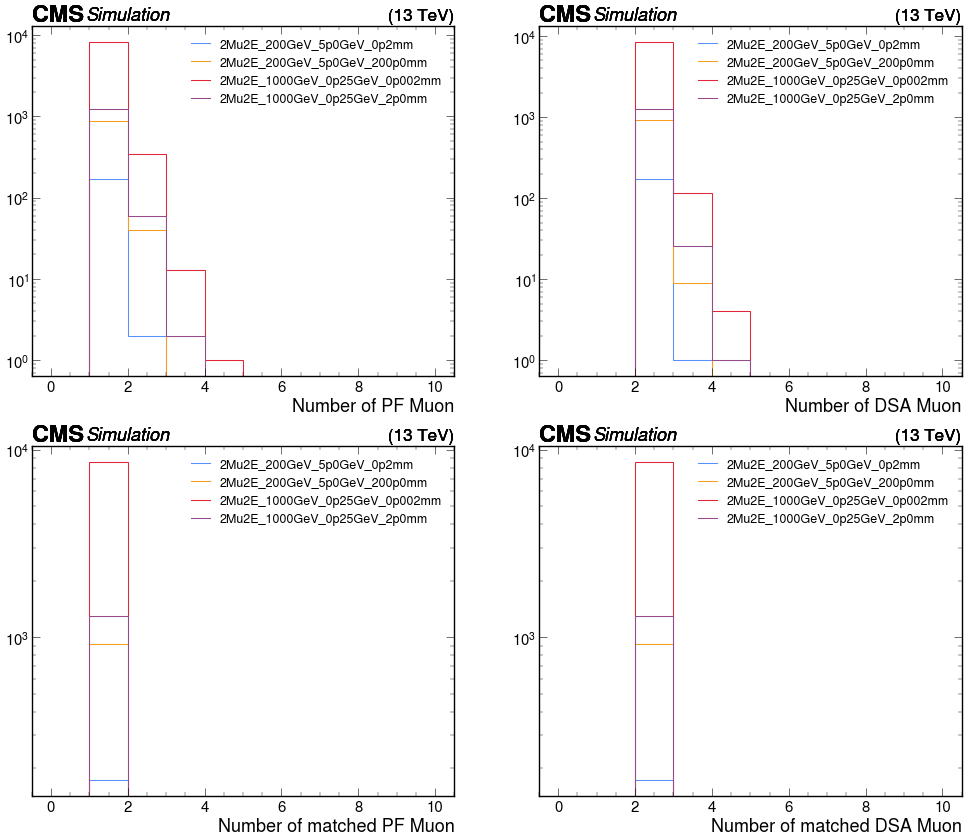

In [7]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["PFcount"][channels[0], :], density=False,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["DSAcount"][channels[0], :], density=False,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,2,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["matchPFcount"][channels[0], :], density=False,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(2,2,4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["matchDSAcount"][channels[0], :], density=False,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

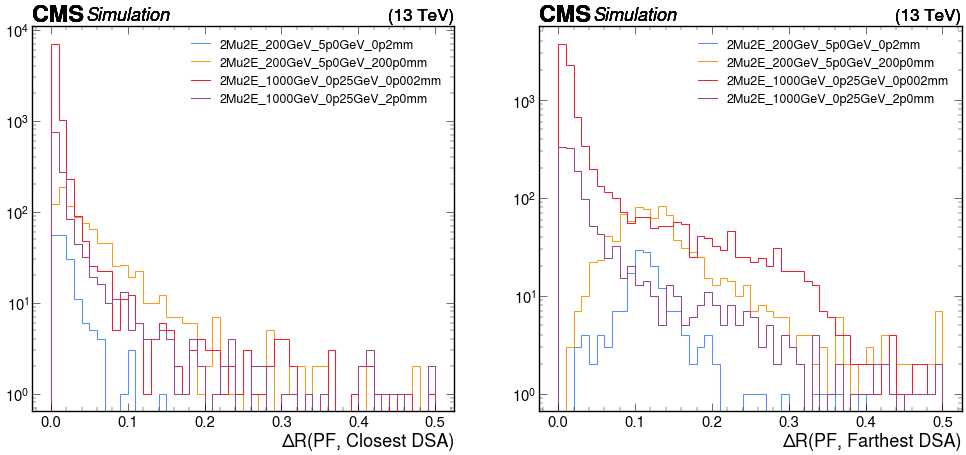

In [8]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["closestDSA_PF_dR"][channels[0], :], density=False,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(1,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["farthestDSA_PF_dR"][channels[0], :], density=False,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

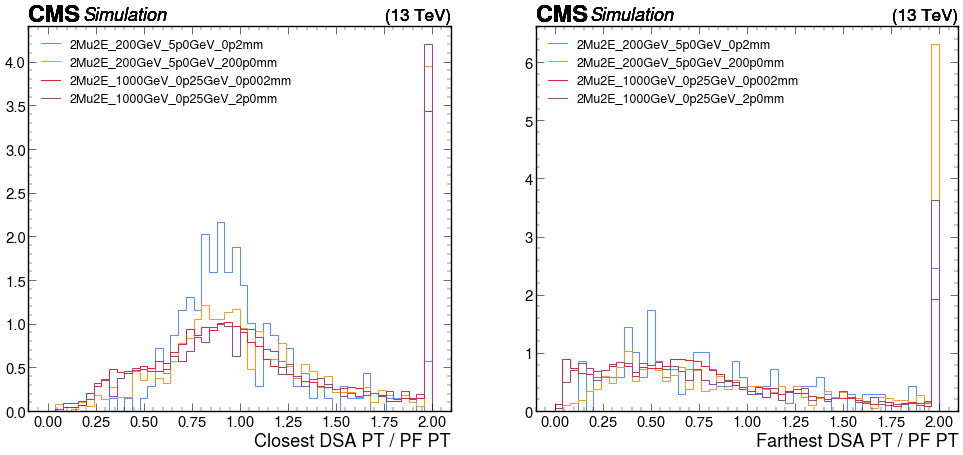

In [12]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["closestDSA_PF_ptRatio"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=2, prop={'size': 18})

plt.subplot(1,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["farthestDSA_PF_ptRatio"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=2, prop={'size': 18})

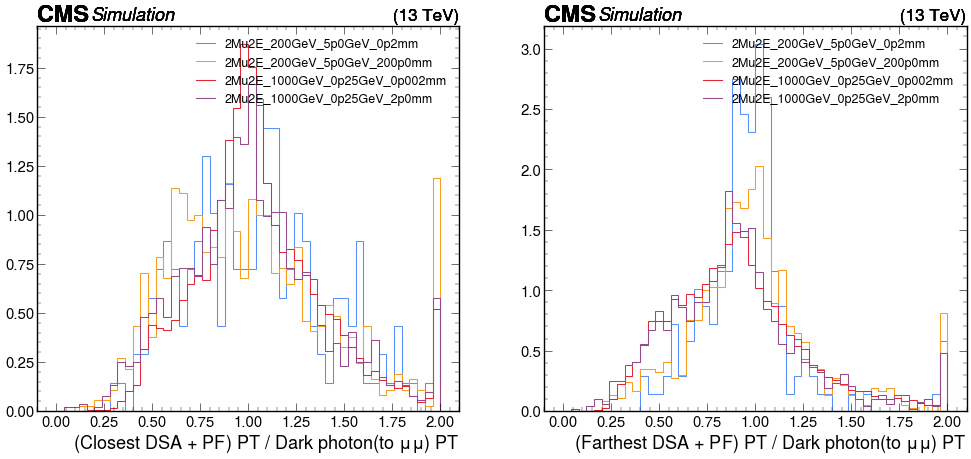

In [14]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["closestDSAplusPF_DP_ptRatio"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["farthestDSAplusPF_DP_ptRatio"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

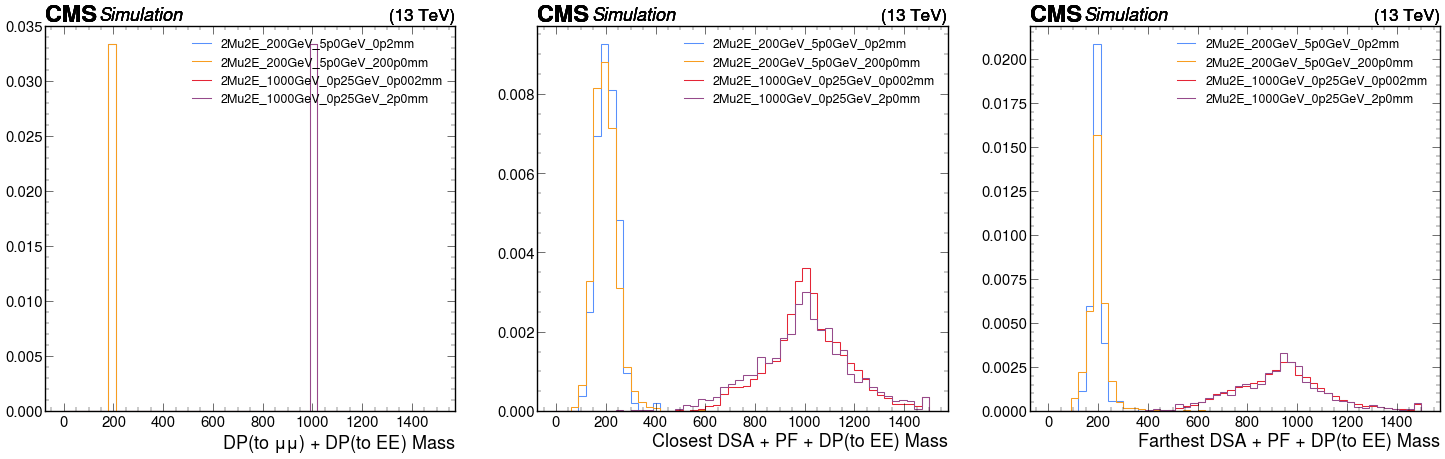

In [18]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["DP_DP_mass"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["closestDSA_PF_DP_mass"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["farthestDSA_PF_DP_mass"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

Text(0.7, 20, '2Mu2E_1000GeV_0p25GeV_2p0mm')

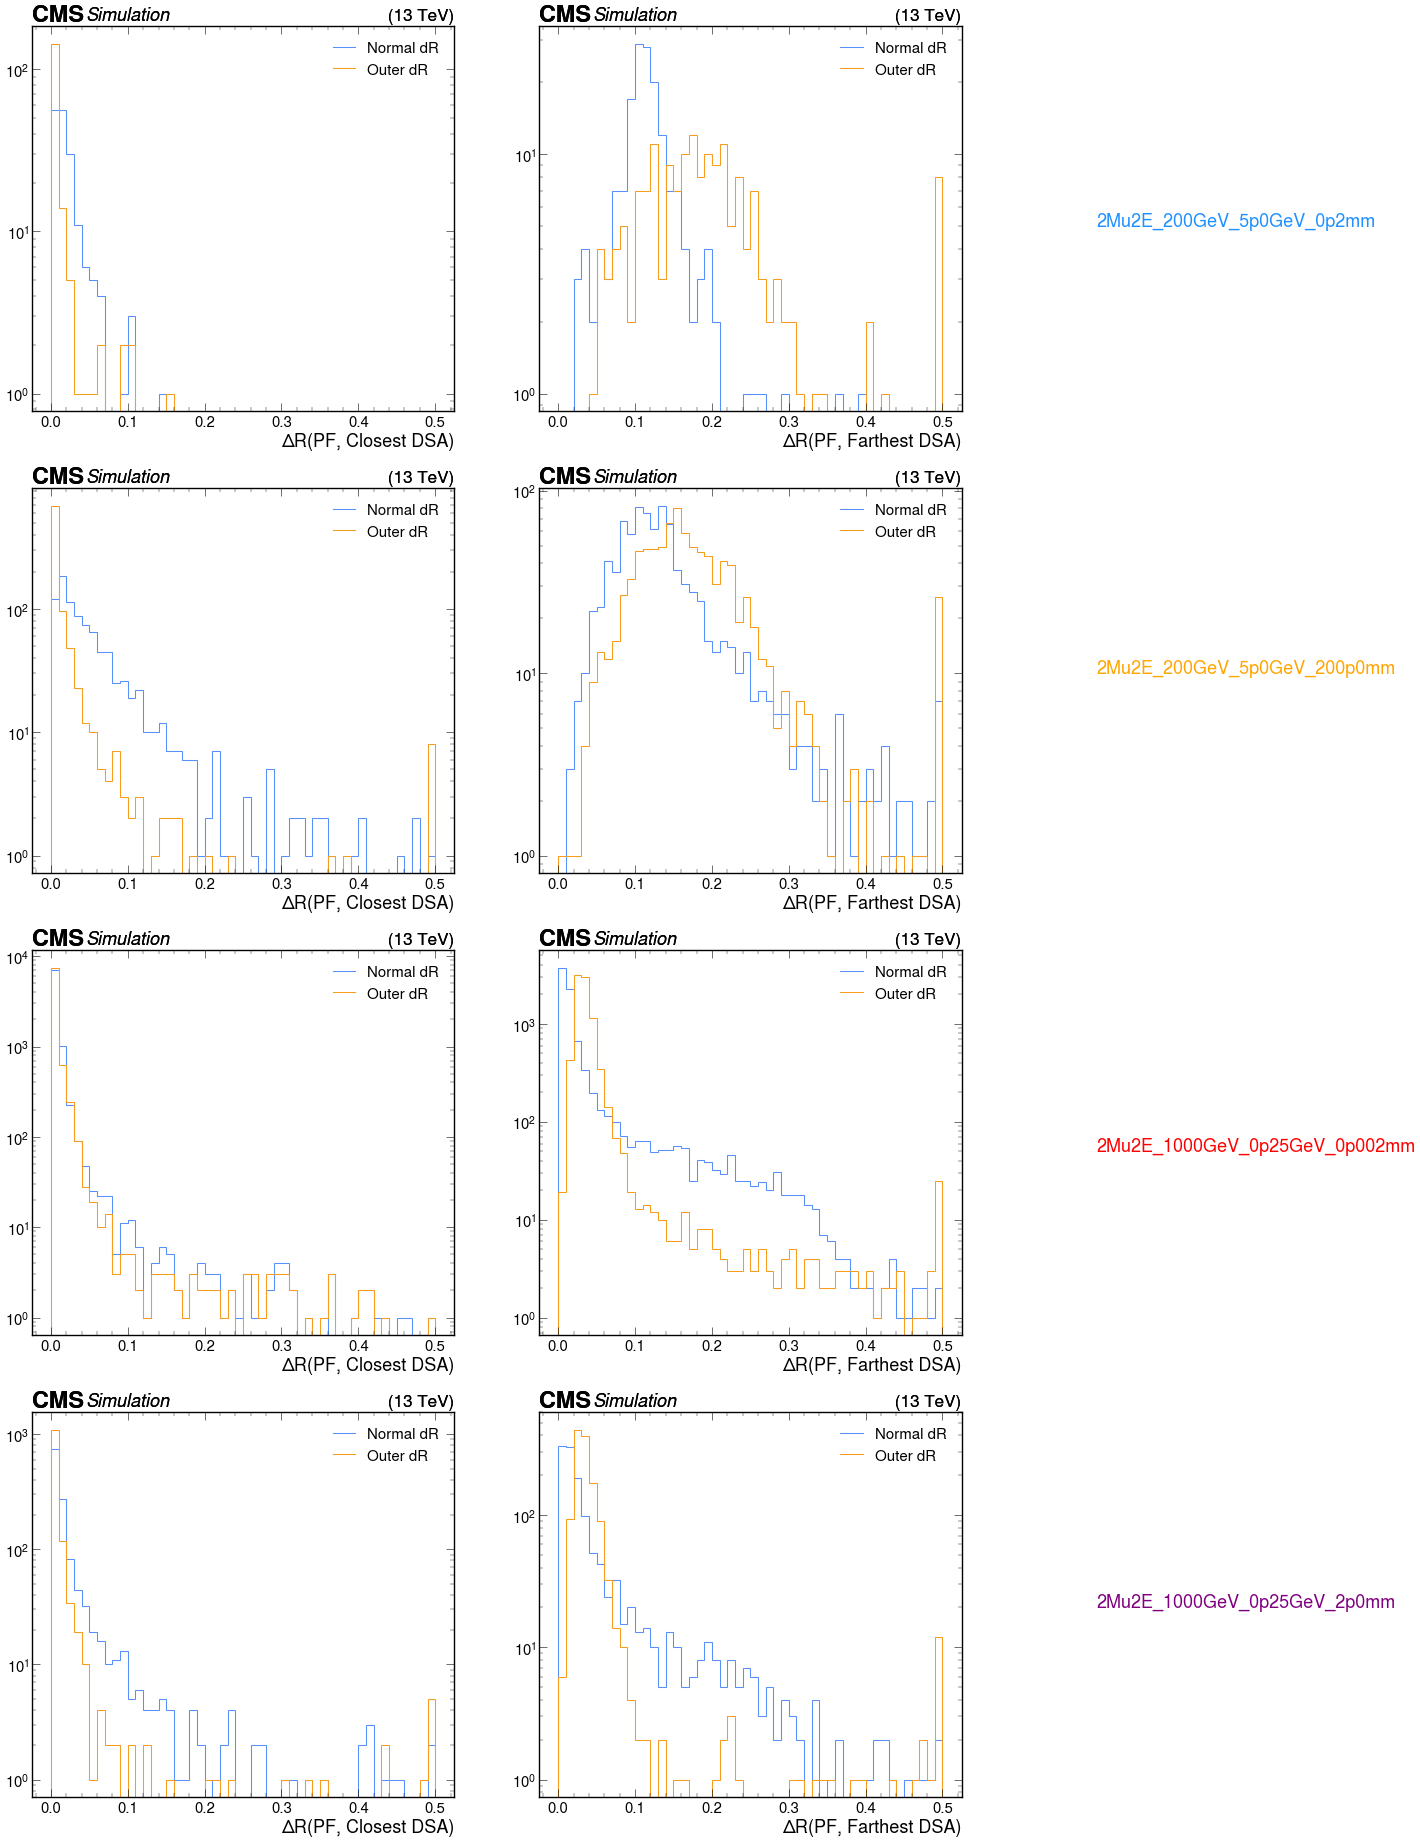

In [6]:
plt.subplots(4,2,figsize=(24,46))

plt.subplot(4,2,1)
utilities.plot(out["2Mu2E_200GeV_5p0GeV_0p2mm"]["hists"]["closestDSA_PF_dR"][channels[0], :], density=False,yerr=False, label='Normal dR')
utilities.plot(out["2Mu2E_200GeV_5p0GeV_0p2mm"]["hists"]["closestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False, label='Outer dR')
plt.legend()
plt.yscale("log")

plt.subplot(4,2,2)
utilities.plot(out["2Mu2E_200GeV_5p0GeV_0p2mm"]["hists"]["farthestDSA_PF_dR"][channels[0], :], density=False,yerr=False, label='Normal dR')
utilities.plot(out["2Mu2E_200GeV_5p0GeV_0p2mm"]["hists"]["farthestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False, label='Outer dR')
plt.legend()
plt.yscale("log")
plt.text(.7,5,"2Mu2E_200GeV_5p0GeV_0p2mm", color="dodgerblue")

plt.subplot(4,2,3)
utilities.plot(out["2Mu2E_200GeV_5p0GeV_200p0mm"]["hists"]["closestDSA_PF_dR"][channels[0], :], density=False,yerr=False, label='Normal dR')
utilities.plot(out["2Mu2E_200GeV_5p0GeV_200p0mm"]["hists"]["closestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False, label='Outer dR')
plt.legend()
plt.yscale("log")

plt.subplot(4,2,4)
utilities.plot(out["2Mu2E_200GeV_5p0GeV_200p0mm"]["hists"]["farthestDSA_PF_dR"][channels[0], :], density=False,yerr=False, label='Normal dR')
utilities.plot(out["2Mu2E_200GeV_5p0GeV_200p0mm"]["hists"]["farthestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False, label='Outer dR')
plt.legend()
plt.yscale("log")
plt.text(.7,10,"2Mu2E_200GeV_5p0GeV_200p0mm", color="orange")

plt.subplot(4,2,5)
utilities.plot(out["2Mu2E_1000GeV_0p25GeV_0p002mm"]["hists"]["closestDSA_PF_dR"][channels[0], :], density=False,yerr=False, label='Normal dR')
utilities.plot(out["2Mu2E_1000GeV_0p25GeV_0p002mm"]["hists"]["closestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False, label='Outer dR')
plt.legend()
plt.yscale("log")

plt.subplot(4,2,6)
utilities.plot(out["2Mu2E_1000GeV_0p25GeV_0p002mm"]["hists"]["farthestDSA_PF_dR"][channels[0], :], density=False,yerr=False, label='Normal dR')
utilities.plot(out["2Mu2E_1000GeV_0p25GeV_0p002mm"]["hists"]["farthestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False, label='Outer dR')
plt.legend()
plt.yscale("log")
plt.text(.7,50,"2Mu2E_1000GeV_0p25GeV_0p002mm", color="r")

plt.subplot(4,2,7)
utilities.plot(out["2Mu2E_1000GeV_0p25GeV_2p0mm"]["hists"]["closestDSA_PF_dR"][channels[0], :], density=False,yerr=False, label='Normal dR')
utilities.plot(out["2Mu2E_1000GeV_0p25GeV_2p0mm"]["hists"]["closestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False, label='Outer dR')
plt.legend()
plt.yscale("log")

plt.subplot(4,2,8)
utilities.plot(out["2Mu2E_1000GeV_0p25GeV_2p0mm"]["hists"]["farthestDSA_PF_dR"][channels[0], :], density=False,yerr=False, label='Normal dR')
utilities.plot(out["2Mu2E_1000GeV_0p25GeV_2p0mm"]["hists"]["farthestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False, label='Outer dR')
plt.legend()
plt.yscale("log")
plt.text(.7,20,"2Mu2E_1000GeV_0p25GeV_2p0mm", color="purple")

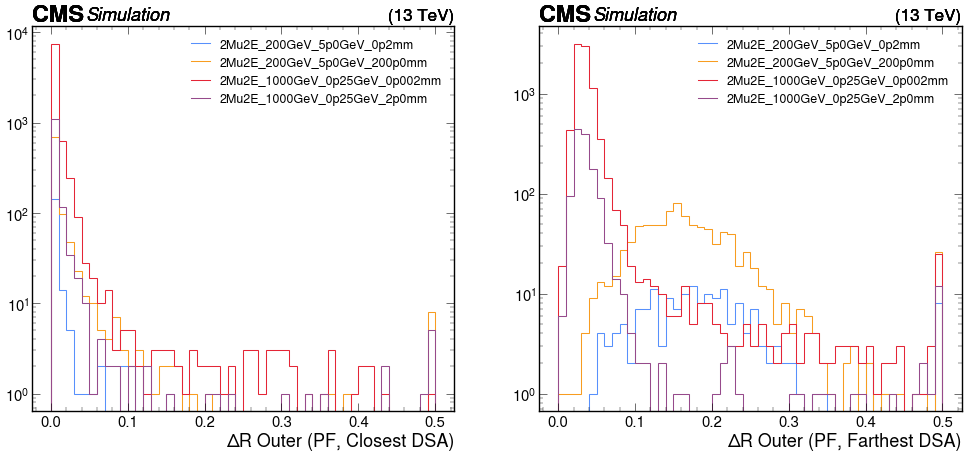

In [8]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["closestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

plt.subplot(1,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["farthestDSA_PF_dR_outer"][channels[0], :], density=False,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})
plt.yscale("log")

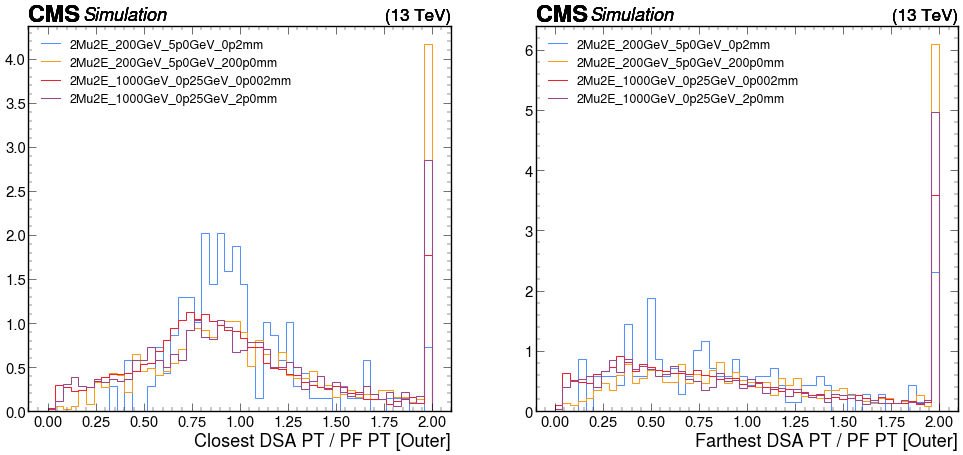

In [9]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["closestDSA_PF_ptRatio_outer"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=2, prop={'size': 18})

plt.subplot(1,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["farthestDSA_PF_ptRatio_outer"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=2, prop={'size': 18})

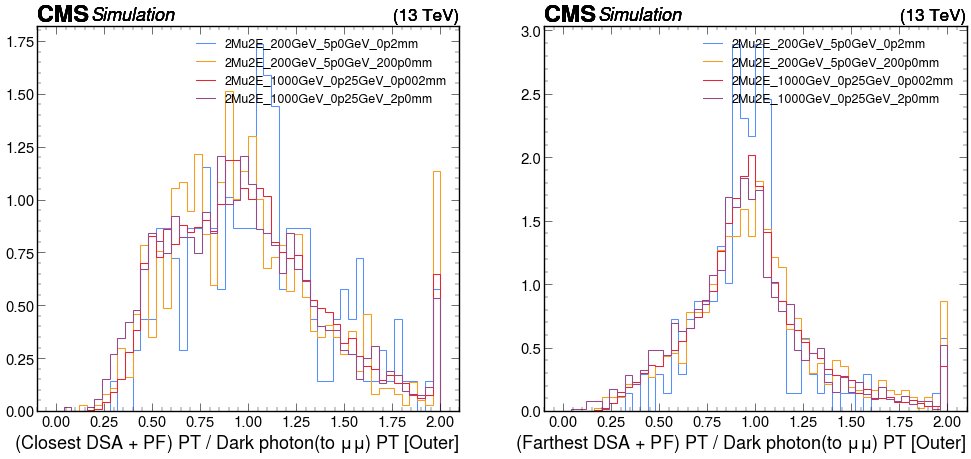

In [10]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["closestDSAplusPF_DP_ptRatio_outer"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,2,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["farthestDSAplusPF_DP_ptRatio_outer"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

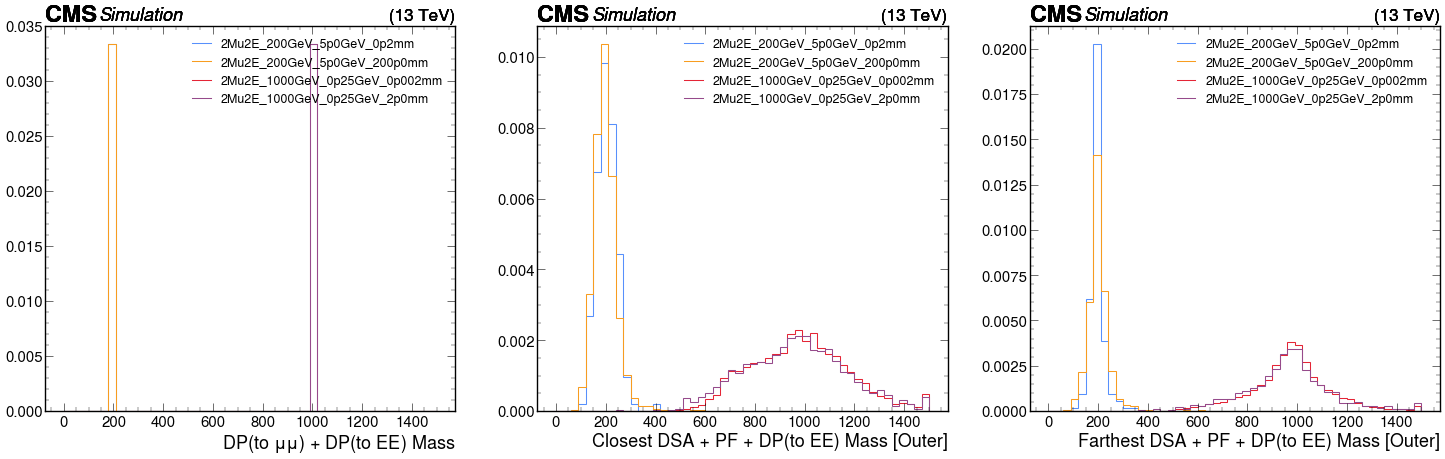

In [11]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["DP_DP_mass"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,3,2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["closestDSA_PF_DP_mass_outer"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})

plt.subplot(1,3,3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["farthestDSA_PF_DP_mass_outer"][channels[0], :], density=True,yerr=False)
plt.legend(samples, loc=1, prop={'size': 18})